### Author : Swapnoneel Kayal <br>
References Used :      


*   For guidance in understanding key concepts : https://sh-tsang.medium.com/review-srgan-srresnet-photo-realistic-super-resolution-gan-super-resolution-96a6fa19490

*   For help in implementating the different blocks of SRGAN: https://medium.com/analytics-vidhya/implementing-srresnet-srgan-super-resolution-with-tensorflow-89900d2ec9b2





In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import requests
import tensorflow_datasets as tfds
import tqdm
import os
import shutil
import re
import cv2
import time
import logging

In [ ]:
class TqdmLoggingHandler(logging.Handler):
    def __init__(self, level=logging.NOTSET):
        super().__init__(level)

    def emit(self, record):
        try:
            msg = self.format(record)
            tqdm.tqdm.write(msg)
            self.flush()
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            self.handleError(record)  
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.addHandler(TqdmLoggingHandler())

In [ ]:
# The paper trained their network on the renowned ImageNet image recognition dataset. Even though, it is beneficial to train models in large amounts of data, the dataset was found out to be too heavy keeping in mind the computation resources we have hence we decided to go with the tf_flowers dataset
# To get more information about the 'tf_flowers' dataset : https://www.tensorflow.org/datasets/catalog/tf_flowers
# This dataset contains 3670 images which does seem like a small dataset especially for training a complex architecture like SRGAN however it proved to be just enough for us to evaluate the performance of the model.

data=tfds.load('tf_flowers')

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Using the 'tensorflow_datasets' module for loading the tf_flowers dataset and taking the first 600 images as a validation dataset

train_data=data['train'].skip(600)
test_data=data['train'].take(600)

In [ ]:
tqdm.tqdm(train_data)

  0%|          | 0/3070 [00:00<?, ?it/s]

In [ ]:
# We define a function to map each image from the dataset to (128,128) crops and a (32,32) low-resolution copy of it. 
@tf.function
def build_data(data):
  cropped=tf.dtypes.cast(tf.image.random_crop(data['image'] / 255,(128,128,3)),tf.float32)

  lr=tf.image.resize(cropped,(32,32))
  #lr=tf.image.resize(lr,(128,128),method=tf.image.ResizeMethod.BICUBIC)
  return (lr,cropped)

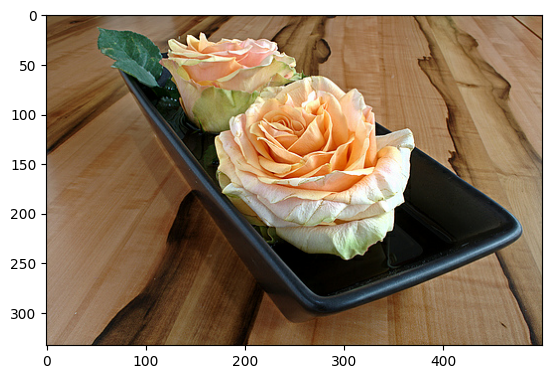

In [ ]:
# Let us visualize one training sample
for x in train_data.take(1):
  plt.imshow(x['image'])
  plt.show()

In [ ]:
def bicubic_interpolate(image,shape):
  img_resized=cv2.resize(image,shape, interpolation=cv2.INTER_CUBIC)
  return img_resized

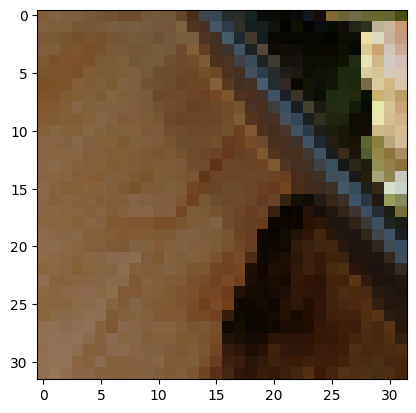

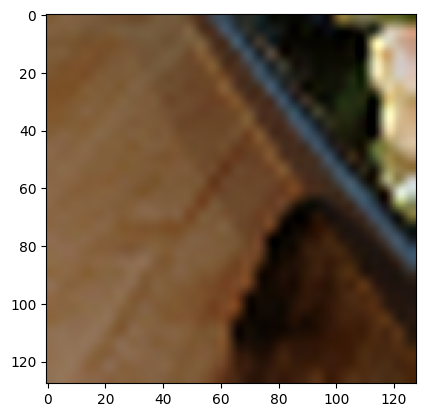

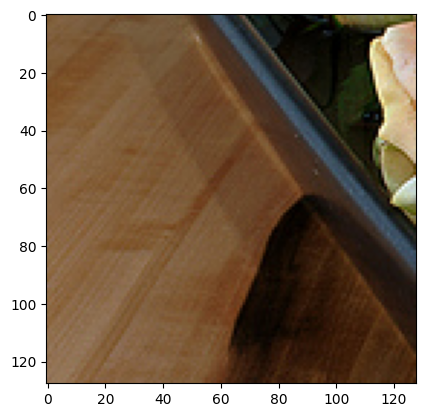

In [ ]:
# The above two functions are now applied on our dataset by using 'train_data.map()'. This will be executed before each training epoch.
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in train_dataset_mapped.take(1):
  plt.imshow(x[0].numpy())
  plt.show()

  plt.imshow(bicubic_interpolate(x[0].numpy(),(128,128)))
  plt.show()
  plt.imshow(x[1].numpy())
  plt.show()

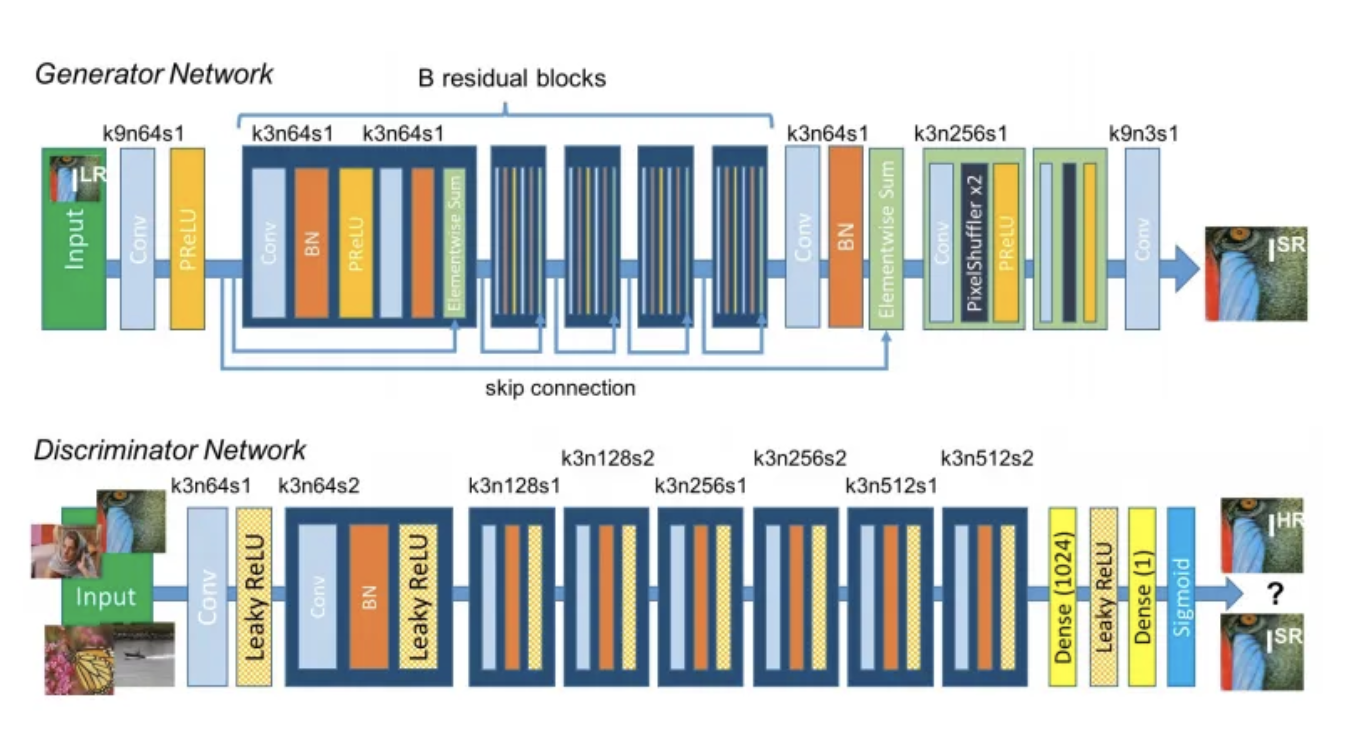

In [ ]:
# We have used Tensorflow for defining the residual generator architecture. Functions were defined to build an entire residual block and element-wise sum skip connections were also implemented.
# 5 residual blocks are connected and the final image is upsampled using the pixel shuffler method which has been implemented in the 'Upsample_block' function.
# Since the network is fully-convolution composed, we do not have to define the input shape which implies that the model can also process images of any size.

def residual_block_gen(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

input_lr=tf.keras.layers.Input(shape=(None,None,3))
input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

SRRes=input_conv
for x in range(5):
  res_output=residual_block_gen()(SRRes)
  SRRes=tf.keras.layers.Add()([SRRes,res_output])

SRRes=tf.keras.layers.Conv2D(64,9,padding='same')(SRRes)
SRRes=tf.keras.layers.BatchNormalization()(SRRes)

SRRes=tf.keras.layers.Add()([SRRes,input_conv])

SRRes=Upsample_block(SRRes)
SRRes=Upsample_block(SRRes)

output_sr=tf.keras.layers.Conv2D(3,9,activation='tanh',padding='same')(SRRes)

SRResnet=tf.keras.models.Model(input_lr,output_sr)

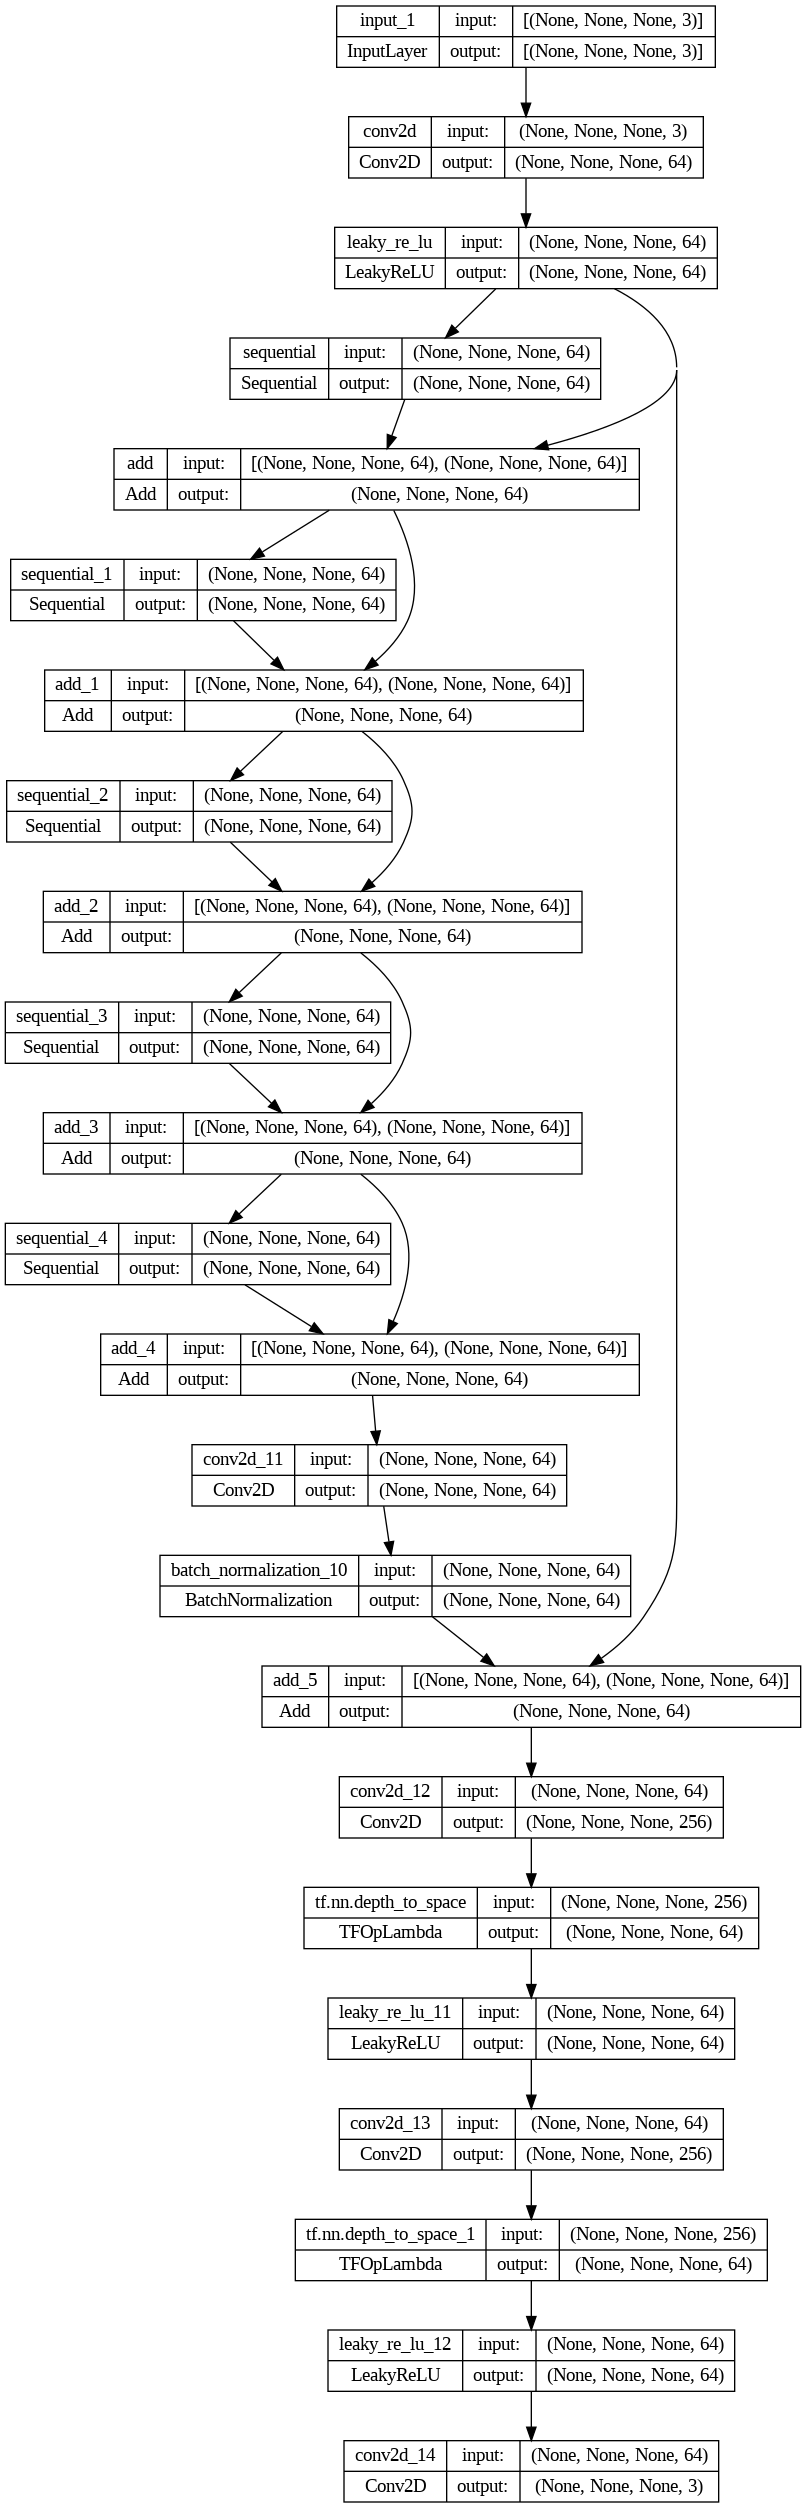

In [ ]:
# The model is built as below :
tf.keras.utils.plot_model(SRResnet,show_shapes=True)

In [ ]:
# The discriminator architecture is also implemented based on the specifications provided in the paper. The network is a conventional CNN which inputs the image and decides the authenticity of the image.

def residual_block_disc(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

input_lr=tf.keras.layers.Input(shape=(128,128,3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

channel_nums=[64,128,128,256,256,512,512]
stride_sizes=[2,1,2,1,2,1,2]

disc=input_conv
for x in range(7):
  disc=residual_block_disc(ch=channel_nums[x],st=stride_sizes[x])(disc)
  
disc=tf.keras.layers.Flatten()(disc)

disc=tf.keras.layers.Dense(1024)(disc)
disc=tf.keras.layers.LeakyReLU()(disc)

disc_output=tf.keras.layers.Dense(1,activation='sigmoid')(disc)

discriminator=tf.keras.models.Model(input_lr,disc_output)

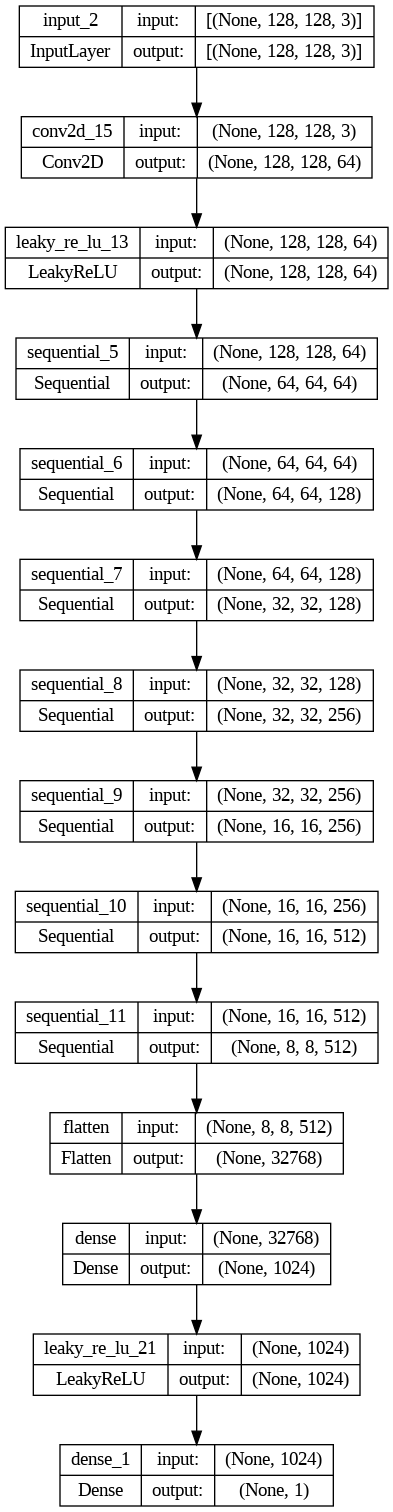

In [ ]:
# The model is built as below :
tf.keras.utils.plot_model(discriminator,show_shapes=True)

In [ ]:
# We define the pixel-wise MSE loss and the PSNR metric for training and evaluation. 
def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def pixel_MSE(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [ ]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))
VGG19.layers

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
# The VGG loss proposed in the paper compares intermediate activation of the pre-trained VGG-19 network when predicting images. We forward propagate through each layer of the VGG model one by one and compare each intermediate output.
# Note that we have defined the intuitive VGG loss as 'VGG_loss_intuitive' and the precise loss as 'VGG_loss'.

VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

VGG_i,VGG_j=2,2
def VGG_loss(y_hr,y_sr,i_m=2,j_m=2):
  i,j=0,0
  accumulated_loss=0.0
  for l in VGG19.layers:
    cl_name=l.__class__.__name__
    if cl_name=='Conv2D':
      j+=1
    if cl_name=='MaxPooling2D':
      i+=1
      j=0
    if i==i_m and j==j_m:
      break
    
    y_hr=l(y_hr)
    y_sr=l(y_sr)
    if cl_name=='Conv2D':
      accumulated_loss+=tf.reduce_mean((y_hr-y_sr)**2) * 0.006

  return accumulated_loss
def VGG_loss_intuitive(y_true,y_pred):
  accumulated_loss=0.0
  for l in VGG19.layers:
    y_true=l(y_true)
    y_pred=l(y_pred)
    accumulated_loss+=tf.reduce_mean((y_true-y_pred)**2) * 0.006
  return accumulated_loss

In [ ]:
# We defined the hyperparameters and loss function for the model to optimize. Note that the adversarial training is only done if adv_learning=True.
# We super resolve the image using the generator model, measure the loss with the given metric, and tape the gradients. 

generator_optimizer=tf.keras.optimizers.SGD(0.0001)
discriminator_optimizer=tf.keras.optimizers.SGD(0.0001)

adv_ratio=0.001
evaluate=['PSNR']
# MSE
loss_func,adv_learning = pixel_MSE,False
# VGG2.2
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),False
# VGG 5.4
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),False
# SRGAN-MSE
loss_func,adv_learning = pixel_MSE,True
# SRGAN-VGG 2.2
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),True
# SRGAN-VGG 5.4
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

#Real loss
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

In [ ]:
# The adversial losses are defined as below:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function()
def train_step(data,loss_func=pixel_MSE,adv_learning=True,evaluate=['PSNR'],adv_ratio=0.001):
  logs={}
  gen_loss,disc_loss=0,0

  low_resolution,high_resolution=data
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    super_resolution = SRResnet(low_resolution, training=True)
    gen_loss=loss_func(high_resolution,super_resolution)

    logs['reconstruction']=gen_loss

    if adv_learning:
      real_output = discriminator(high_resolution, training=True)
      fake_output = discriminator(super_resolution, training=True)
      
      adv_loss_g = generator_loss(fake_output) * adv_ratio
      gen_loss += adv_loss_g

      disc_loss = discriminator_loss(real_output, fake_output)
      
      logs['adv_g']=adv_loss_g
      logs['adv_d']=disc_loss

  gradients_of_generator = gen_tape.gradient(gen_loss, SRResnet.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, SRResnet.trainable_variables))

  if adv_learning:
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  for x in evaluate:
    if x=='PSNR':
      logs[x]=PSNR(high_resolution,super_resolution)

  return logs

In [ ]:
SRResnet=tf.keras.models.load_model('/content/drive/MyDrive/EE769_Project/SRGAN/SRResNet-generator.h5',compile=False)
discriminator=tf.keras.models.load_model('/content/drive/MyDrive/EE769_Project/SRGAN/SRResNet-discriminator.h5',compile=False)

In [ ]:
for x in range(50):
  print('----------------',x,'----------------')
  train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE).batch(64)
  val_dataset_mapped = test_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE).batch(64)
  
  for image_batch in tqdm.tqdm(train_dataset_mapped, position=0, leave=True):
    logs=train_step(image_batch,loss_func,adv_learning,evaluate,adv_ratio)
    for k in logs.keys():
      print(k,':',logs[k],end='  ')
    print()

---------------- 0 ----------------


  2%|▏         | 1/48 [00:41<32:09, 41.06s/it]

reconstruction : tf.Tensor(4.96986, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00072037184, shape=(), dtype=float32)  adv_d : tf.Tensor(1.3825934, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6554427, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:42<13:27, 17.55s/it]

tf.Tensor(5.063178, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0008735583, shape=(), dtype=float32)  adv_d : tf.Tensor(1.3528903, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7392697, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:43<07:31, 10.04s/it]

tf.Tensor(5.0972347, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00088938634, shape=(), dtype=float32)  adv_d : tf.Tensor(1.2546859, shape=(), dtype=float32)  PSNR : tf.Tensor(5.210628, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:44<04:46,  6.51s/it]

tf.Tensor(5.206215, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00077692245, shape=(), dtype=float32)  adv_d : tf.Tensor(1.4116637, shape=(), dtype=float32)  PSNR : tf.Tensor(5.263545, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:45<03:16,  4.56s/it]

tf.Tensor(5.225972, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0008975614, shape=(), dtype=float32)  adv_d : tf.Tensor(1.2643471, shape=(), dtype=float32)  PSNR : tf.Tensor(5.3230157, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:46<02:22,  3.39s/it]

tf.Tensor(4.8337197, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0009242117, shape=(), dtype=float32)  adv_d : tf.Tensor(1.3299799, shape=(), dtype=float32)  PSNR : tf.Tensor(5.277332, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:47<01:48,  2.64s/it]

tf.Tensor(5.0541754, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0010087034, shape=(), dtype=float32)  adv_d : tf.Tensor(1.2177445, shape=(), dtype=float32)  PSNR : tf.Tensor(5.09325, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:48<01:26,  2.15s/it]

tf.Tensor(5.1095905, shape=(), dtype=float32)  adv_g : tf.Tensor(0.001128691, shape=(), dtype=float32)  adv_d : tf.Tensor(1.1493615, shape=(), dtype=float32)  PSNR : tf.Tensor(5.326884, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:49<01:11,  1.83s/it]

tf.Tensor(4.8817654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0011188926, shape=(), dtype=float32)  adv_d : tf.Tensor(0.9775797, shape=(), dtype=float32)  PSNR : tf.Tensor(5.529069, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:50<01:00,  1.60s/it]

tf.Tensor(4.9477906, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0012499118, shape=(), dtype=float32)  adv_d : tf.Tensor(1.0206733, shape=(), dtype=float32)  PSNR : tf.Tensor(5.5665784, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:52<00:53,  1.45s/it]

tf.Tensor(4.771407, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0012810574, shape=(), dtype=float32)  adv_d : tf.Tensor(1.0194368, shape=(), dtype=float32)  PSNR : tf.Tensor(5.2838993, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:53<00:48,  1.35s/it]

tf.Tensor(4.9312506, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0012905425, shape=(), dtype=float32)  adv_d : tf.Tensor(1.0014993, shape=(), dtype=float32)  PSNR : tf.Tensor(5.685876, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:54<00:44,  1.28s/it]

tf.Tensor(4.754948, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0014873894, shape=(), dtype=float32)  adv_d : tf.Tensor(0.8371526, shape=(), dtype=float32)  PSNR : tf.Tensor(5.2004633, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:55<00:41,  1.23s/it]

tf.Tensor(5.052048, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0012291077, shape=(), dtype=float32)  adv_d : tf.Tensor(0.99911684, shape=(), dtype=float32)  PSNR : tf.Tensor(5.5343018, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:56<00:39,  1.20s/it]

tf.Tensor(4.6359987, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0013387062, shape=(), dtype=float32)  adv_d : tf.Tensor(0.88734037, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6820965, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:57<00:37,  1.18s/it]

tf.Tensor(4.7554502, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0014154108, shape=(), dtype=float32)  adv_d : tf.Tensor(0.79542357, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6250086, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:58<00:36,  1.16s/it]

tf.Tensor(4.7264204, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0013828345, shape=(), dtype=float32)  adv_d : tf.Tensor(0.8433275, shape=(), dtype=float32)  PSNR : tf.Tensor(5.333391, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:59<00:34,  1.15s/it]

tf.Tensor(4.847508, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0013115719, shape=(), dtype=float32)  adv_d : tf.Tensor(0.9059651, shape=(), dtype=float32)  PSNR : tf.Tensor(5.187108, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [01:01<00:33,  1.14s/it]

tf.Tensor(4.6228876, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0012896409, shape=(), dtype=float32)  adv_d : tf.Tensor(0.85289466, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7184453, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [01:02<00:31,  1.14s/it]

tf.Tensor(4.631875, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0015634741, shape=(), dtype=float32)  adv_d : tf.Tensor(0.8403009, shape=(), dtype=float32)  PSNR : tf.Tensor(5.437106, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [01:03<00:30,  1.14s/it]

tf.Tensor(4.7280426, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0014091852, shape=(), dtype=float32)  adv_d : tf.Tensor(0.78562534, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6986237, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [01:04<00:29,  1.14s/it]

tf.Tensor(5.048231, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0017321158, shape=(), dtype=float32)  adv_d : tf.Tensor(0.72989315, shape=(), dtype=float32)  PSNR : tf.Tensor(5.322462, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [01:05<00:28,  1.13s/it]

tf.Tensor(4.598692, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0014831496, shape=(), dtype=float32)  adv_d : tf.Tensor(0.7997303, shape=(), dtype=float32)  PSNR : tf.Tensor(5.573345, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [01:06<00:27,  1.14s/it]

tf.Tensor(4.707236, shape=(), dtype=float32)  adv_g : tf.Tensor(0.001579283, shape=(), dtype=float32)  adv_d : tf.Tensor(0.7408402, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6426826, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [01:07<00:26,  1.13s/it]

tf.Tensor(4.550906, shape=(), dtype=float32)  adv_g : tf.Tensor(0.001587507, shape=(), dtype=float32)  adv_d : tf.Tensor(0.61970586, shape=(), dtype=float32)  PSNR : tf.Tensor(5.361985, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [01:09<00:24,  1.13s/it]

tf.Tensor(4.721106, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0016291032, shape=(), dtype=float32)  adv_d : tf.Tensor(0.6503582, shape=(), dtype=float32)  PSNR : tf.Tensor(5.569642, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [01:10<00:23,  1.13s/it]

tf.Tensor(4.326175, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0017549313, shape=(), dtype=float32)  adv_d : tf.Tensor(0.6362225, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8788404, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [01:11<00:22,  1.14s/it]

tf.Tensor(4.417372, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0017962988, shape=(), dtype=float32)  adv_d : tf.Tensor(0.5704328, shape=(), dtype=float32)  PSNR : tf.Tensor(5.314463, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [01:12<00:21,  1.15s/it]

tf.Tensor(4.9058013, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0017071104, shape=(), dtype=float32)  adv_d : tf.Tensor(0.69264495, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7836103, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [01:13<00:20,  1.15s/it]

tf.Tensor(4.897147, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0016805903, shape=(), dtype=float32)  adv_d : tf.Tensor(0.6240329, shape=(), dtype=float32)  PSNR : tf.Tensor(5.3387966, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [01:14<00:19,  1.14s/it]

tf.Tensor(4.5025826, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0018994748, shape=(), dtype=float32)  adv_d : tf.Tensor(0.49488598, shape=(), dtype=float32)  PSNR : tf.Tensor(5.020895, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [01:15<00:18,  1.15s/it]

tf.Tensor(4.690636, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0016692118, shape=(), dtype=float32)  adv_d : tf.Tensor(0.6058989, shape=(), dtype=float32)  PSNR : tf.Tensor(5.3789477, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [01:17<00:17,  1.15s/it]

tf.Tensor(4.862349, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0019322278, shape=(), dtype=float32)  adv_d : tf.Tensor(0.559307, shape=(), dtype=float32)  PSNR : tf.Tensor(5.165056, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [01:18<00:16,  1.14s/it]

tf.Tensor(4.605922, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0019382869, shape=(), dtype=float32)  adv_d : tf.Tensor(0.5106251, shape=(), dtype=float32)  PSNR : tf.Tensor(5.713501, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [01:19<00:14,  1.14s/it]

tf.Tensor(4.52473, shape=(), dtype=float32)  adv_g : tf.Tensor(0.001764787, shape=(), dtype=float32)  adv_d : tf.Tensor(0.60810757, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4206276, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [01:20<00:13,  1.14s/it]

tf.Tensor(4.884209, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0018199661, shape=(), dtype=float32)  adv_d : tf.Tensor(0.5390044, shape=(), dtype=float32)  PSNR : tf.Tensor(5.166918, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [01:21<00:12,  1.14s/it]

tf.Tensor(4.2890406, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0020005193, shape=(), dtype=float32)  adv_d : tf.Tensor(0.5346257, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7693796, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [01:22<00:11,  1.14s/it]

tf.Tensor(4.565183, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0018441384, shape=(), dtype=float32)  adv_d : tf.Tensor(0.58776444, shape=(), dtype=float32)  PSNR : tf.Tensor(5.637866, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [01:23<00:10,  1.15s/it]

tf.Tensor(4.541447, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0018836855, shape=(), dtype=float32)  adv_d : tf.Tensor(0.51350975, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6872287, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [01:25<00:09,  1.14s/it]

tf.Tensor(4.5341954, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0018931067, shape=(), dtype=float32)  adv_d : tf.Tensor(0.56840163, shape=(), dtype=float32)  PSNR : tf.Tensor(5.66258, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [01:26<00:07,  1.14s/it]

tf.Tensor(4.626539, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0021778003, shape=(), dtype=float32)  adv_d : tf.Tensor(0.42883658, shape=(), dtype=float32)  PSNR : tf.Tensor(4.960359, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [01:27<00:06,  1.14s/it]

tf.Tensor(4.4302883, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002135723, shape=(), dtype=float32)  adv_d : tf.Tensor(0.4589783, shape=(), dtype=float32)  PSNR : tf.Tensor(5.2317696, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [01:28<00:05,  1.13s/it]

tf.Tensor(4.638735, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0020935494, shape=(), dtype=float32)  adv_d : tf.Tensor(0.47641194, shape=(), dtype=float32)  PSNR : tf.Tensor(5.4902554, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [01:29<00:04,  1.13s/it]

tf.Tensor(4.7047625, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0018662022, shape=(), dtype=float32)  adv_d : tf.Tensor(0.48078638, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6046567, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [01:30<00:03,  1.13s/it]

tf.Tensor(4.3167934, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0020768896, shape=(), dtype=float32)  adv_d : tf.Tensor(0.43332326, shape=(), dtype=float32)  PSNR : tf.Tensor(5.2577543, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [01:31<00:02,  1.13s/it]

tf.Tensor(4.691952, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0020805101, shape=(), dtype=float32)  adv_d : tf.Tensor(0.44686866, shape=(), dtype=float32)  PSNR : tf.Tensor(5.723476, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [01:32<00:01,  1.12s/it]

tf.Tensor(4.6465864, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0021378675, shape=(), dtype=float32)  adv_d : tf.Tensor(0.4170156, shape=(), dtype=float32)  PSNR : tf.Tensor(5.460818, shape=(), dtype=float32)  


100%|██████████| 48/48 [02:00<00:00,  2.50s/it]


reconstruction : tf.Tensor(4.755476, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0021128627, shape=(), dtype=float32)  adv_d : tf.Tensor(0.3926751, shape=(), dtype=float32)  PSNR : tf.Tensor(5.735513, shape=(), dtype=float32)  
---------------- 1 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.20s/it]

tf.Tensor(4.2140675, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002144176, shape=(), dtype=float32)  adv_d : tf.Tensor(0.41653332, shape=(), dtype=float32)  PSNR : tf.Tensor(5.66911, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.15s/it]

tf.Tensor(4.309274, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0021302043, shape=(), dtype=float32)  adv_d : tf.Tensor(0.41333276, shape=(), dtype=float32)  PSNR : tf.Tensor(5.822595, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(4.5712404, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002099436, shape=(), dtype=float32)  adv_d : tf.Tensor(0.39373624, shape=(), dtype=float32)  PSNR : tf.Tensor(5.5472245, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.12s/it]

tf.Tensor(4.578878, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0022724143, shape=(), dtype=float32)  adv_d : tf.Tensor(0.3919627, shape=(), dtype=float32)  PSNR : tf.Tensor(5.457251, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.12s/it]

tf.Tensor(4.7025876, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002340596, shape=(), dtype=float32)  adv_d : tf.Tensor(0.33405095, shape=(), dtype=float32)  PSNR : tf.Tensor(5.466025, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.12s/it]

tf.Tensor(4.2377715, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0022589285, shape=(), dtype=float32)  adv_d : tf.Tensor(0.37896502, shape=(), dtype=float32)  PSNR : tf.Tensor(5.829439, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.12s/it]

tf.Tensor(4.531847, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0023293141, shape=(), dtype=float32)  adv_d : tf.Tensor(0.33889535, shape=(), dtype=float32)  PSNR : tf.Tensor(5.190398, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(4.620609, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002265734, shape=(), dtype=float32)  adv_d : tf.Tensor(0.3888986, shape=(), dtype=float32)  PSNR : tf.Tensor(5.5479684, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(4.5211143, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002293879, shape=(), dtype=float32)  adv_d : tf.Tensor(0.35891876, shape=(), dtype=float32)  PSNR : tf.Tensor(5.693942, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(4.418956, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0023083172, shape=(), dtype=float32)  adv_d : tf.Tensor(0.3267082, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6956396, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(4.254682, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0023351728, shape=(), dtype=float32)  adv_d : tf.Tensor(0.3414357, shape=(), dtype=float32)  PSNR : tf.Tensor(5.682214, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(4.634705, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0023682984, shape=(), dtype=float32)  adv_d : tf.Tensor(0.31691983, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7897577, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(4.2777176, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0023065663, shape=(), dtype=float32)  adv_d : tf.Tensor(0.3459195, shape=(), dtype=float32)  PSNR : tf.Tensor(5.4124856, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(4.625507, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002256168, shape=(), dtype=float32)  adv_d : tf.Tensor(0.3590041, shape=(), dtype=float32)  PSNR : tf.Tensor(5.744493, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.12s/it]

tf.Tensor(4.4870753, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0025438028, shape=(), dtype=float32)  adv_d : tf.Tensor(0.29849643, shape=(), dtype=float32)  PSNR : tf.Tensor(5.5296926, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.12s/it]

tf.Tensor(4.4278545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002484355, shape=(), dtype=float32)  adv_d : tf.Tensor(0.29659176, shape=(), dtype=float32)  PSNR : tf.Tensor(5.639163, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.13s/it]

tf.Tensor(4.351137, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0022624417, shape=(), dtype=float32)  adv_d : tf.Tensor(0.3157149, shape=(), dtype=float32)  PSNR : tf.Tensor(5.3531213, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.13s/it]

tf.Tensor(4.604183, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0022695782, shape=(), dtype=float32)  adv_d : tf.Tensor(0.33643544, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7503066, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.12s/it]

tf.Tensor(4.27074, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00241987, shape=(), dtype=float32)  adv_d : tf.Tensor(0.3241856, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7819834, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(4.2963295, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0027056076, shape=(), dtype=float32)  adv_d : tf.Tensor(0.26144812, shape=(), dtype=float32)  PSNR : tf.Tensor(5.447627, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(4.3999863, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0023006673, shape=(), dtype=float32)  adv_d : tf.Tensor(0.31731156, shape=(), dtype=float32)  PSNR : tf.Tensor(5.949086, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(4.455203, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0028221507, shape=(), dtype=float32)  adv_d : tf.Tensor(0.2549317, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7107882, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.13s/it]

tf.Tensor(4.2192655, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0024033696, shape=(), dtype=float32)  adv_d : tf.Tensor(0.3300322, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8357806, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.13s/it]

tf.Tensor(4.3997135, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0026937048, shape=(), dtype=float32)  adv_d : tf.Tensor(0.25476837, shape=(), dtype=float32)  PSNR : tf.Tensor(5.5120792, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.13s/it]

tf.Tensor(4.295144, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0024160459, shape=(), dtype=float32)  adv_d : tf.Tensor(0.28189042, shape=(), dtype=float32)  PSNR : tf.Tensor(5.480815, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(4.3457866, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0023874843, shape=(), dtype=float32)  adv_d : tf.Tensor(0.31764287, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8466935, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.12s/it]

tf.Tensor(4.2319593, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002652429, shape=(), dtype=float32)  adv_d : tf.Tensor(0.27963856, shape=(), dtype=float32)  PSNR : tf.Tensor(6.013686, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.12s/it]

tf.Tensor(4.2135496, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002621184, shape=(), dtype=float32)  adv_d : tf.Tensor(0.25345823, shape=(), dtype=float32)  PSNR : tf.Tensor(5.357233, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(4.561996, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002439098, shape=(), dtype=float32)  adv_d : tf.Tensor(0.31820774, shape=(), dtype=float32)  PSNR : tf.Tensor(6.051081, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.13s/it]

tf.Tensor(4.5899262, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002471491, shape=(), dtype=float32)  adv_d : tf.Tensor(0.29853845, shape=(), dtype=float32)  PSNR : tf.Tensor(5.338735, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.13s/it]

tf.Tensor(4.2712245, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0025900144, shape=(), dtype=float32)  adv_d : tf.Tensor(0.26168582, shape=(), dtype=float32)  PSNR : tf.Tensor(5.3149896, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.13s/it]

tf.Tensor(4.367639, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002622189, shape=(), dtype=float32)  adv_d : tf.Tensor(0.2588402, shape=(), dtype=float32)  PSNR : tf.Tensor(5.748994, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(4.4535604, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002624332, shape=(), dtype=float32)  adv_d : tf.Tensor(0.25011736, shape=(), dtype=float32)  PSNR : tf.Tensor(5.2535605, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.13s/it]

tf.Tensor(4.4289923, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0025834932, shape=(), dtype=float32)  adv_d : tf.Tensor(0.24934469, shape=(), dtype=float32)  PSNR : tf.Tensor(5.674651, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.13s/it]

tf.Tensor(4.2882805, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0027327056, shape=(), dtype=float32)  adv_d : tf.Tensor(0.2318062, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2448773, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(4.45383, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0027016196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.24987966, shape=(), dtype=float32)  PSNR : tf.Tensor(5.391865, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(3.9397025, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002714315, shape=(), dtype=float32)  adv_d : tf.Tensor(0.23190954, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7262387, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(4.2859473, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0025922186, shape=(), dtype=float32)  adv_d : tf.Tensor(0.318026, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6725464, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(4.506654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0024787332, shape=(), dtype=float32)  adv_d : tf.Tensor(0.25401807, shape=(), dtype=float32)  PSNR : tf.Tensor(5.852097, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:08,  1.12s/it]

tf.Tensor(4.4277167, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0027110921, shape=(), dtype=float32)  adv_d : tf.Tensor(0.26887658, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6454964, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.12s/it]

tf.Tensor(4.25454, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00266535, shape=(), dtype=float32)  adv_d : tf.Tensor(0.25886756, shape=(), dtype=float32)  PSNR : tf.Tensor(5.457543, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(4.2450633, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0028348549, shape=(), dtype=float32)  adv_d : tf.Tensor(0.2247368, shape=(), dtype=float32)  PSNR : tf.Tensor(5.286876, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(4.390983, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002638742, shape=(), dtype=float32)  adv_d : tf.Tensor(0.26195642, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9306216, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.13s/it]

tf.Tensor(4.557908, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002699557, shape=(), dtype=float32)  adv_d : tf.Tensor(0.23571259, shape=(), dtype=float32)  PSNR : tf.Tensor(5.777187, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(4.3219137, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0027498694, shape=(), dtype=float32)  adv_d : tf.Tensor(0.22584054, shape=(), dtype=float32)  PSNR : tf.Tensor(5.3049827, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(4.27765, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0026859546, shape=(), dtype=float32)  adv_d : tf.Tensor(0.2542441, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8839684, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(4.4368377, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0026274472, shape=(), dtype=float32)  adv_d : tf.Tensor(0.24177295, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0443583, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.12s/it]


tf.Tensor(4.3549438, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029406433, shape=(), dtype=float32)  adv_d : tf.Tensor(0.18632102, shape=(), dtype=float32)  PSNR : tf.Tensor(5.575309, shape=(), dtype=float32)  
---------------- 2 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:55,  1.19s/it]

tf.Tensor(3.9202456, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0028897463, shape=(), dtype=float32)  adv_d : tf.Tensor(0.19842236, shape=(), dtype=float32)  PSNR : tf.Tensor(6.185335, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.14s/it]

tf.Tensor(4.06351, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0027433452, shape=(), dtype=float32)  adv_d : tf.Tensor(0.24980076, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0115, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(4.240065, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0028687385, shape=(), dtype=float32)  adv_d : tf.Tensor(0.18789117, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6814466, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.13s/it]

tf.Tensor(4.368526, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0027884275, shape=(), dtype=float32)  adv_d : tf.Tensor(0.21505395, shape=(), dtype=float32)  PSNR : tf.Tensor(5.723428, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(4.5609455, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0028973618, shape=(), dtype=float32)  adv_d : tf.Tensor(0.23458439, shape=(), dtype=float32)  PSNR : tf.Tensor(5.4915013, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.12s/it]

tf.Tensor(4.065204, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029156725, shape=(), dtype=float32)  adv_d : tf.Tensor(0.19969654, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9637957, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.12s/it]

tf.Tensor(4.448659, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002712053, shape=(), dtype=float32)  adv_d : tf.Tensor(0.22229695, shape=(), dtype=float32)  PSNR : tf.Tensor(5.3329873, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(4.461509, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029279238, shape=(), dtype=float32)  adv_d : tf.Tensor(0.2097482, shape=(), dtype=float32)  PSNR : tf.Tensor(5.5551405, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(4.3274965, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029552924, shape=(), dtype=float32)  adv_d : tf.Tensor(0.18348488, shape=(), dtype=float32)  PSNR : tf.Tensor(5.574015, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(4.167476, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002777144, shape=(), dtype=float32)  adv_d : tf.Tensor(0.20568877, shape=(), dtype=float32)  PSNR : tf.Tensor(5.900173, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(4.0285516, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029645055, shape=(), dtype=float32)  adv_d : tf.Tensor(0.20317757, shape=(), dtype=float32)  PSNR : tf.Tensor(5.98212, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(4.378535, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002791998, shape=(), dtype=float32)  adv_d : tf.Tensor(0.22207427, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9689126, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(4.1599913, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0030506756, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1579817, shape=(), dtype=float32)  PSNR : tf.Tensor(5.420973, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.12s/it]

tf.Tensor(4.5224414, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002888543, shape=(), dtype=float32)  adv_d : tf.Tensor(0.2280997, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7352114, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.11s/it]

tf.Tensor(4.2545385, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003042928, shape=(), dtype=float32)  adv_d : tf.Tensor(0.17498687, shape=(), dtype=float32)  PSNR : tf.Tensor(5.588893, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.11s/it]

tf.Tensor(4.1735296, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003030578, shape=(), dtype=float32)  adv_d : tf.Tensor(0.17968848, shape=(), dtype=float32)  PSNR : tf.Tensor(5.841277, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.12s/it]

tf.Tensor(4.3111563, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0028123057, shape=(), dtype=float32)  adv_d : tf.Tensor(0.19195825, shape=(), dtype=float32)  PSNR : tf.Tensor(5.683856, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.12s/it]

tf.Tensor(4.07733, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002889395, shape=(), dtype=float32)  adv_d : tf.Tensor(0.19269013, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8119726, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.12s/it]

tf.Tensor(4.1477704, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0028903414, shape=(), dtype=float32)  adv_d : tf.Tensor(0.21632905, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8676367, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.12s/it]

tf.Tensor(4.0287156, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031964486, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1652848, shape=(), dtype=float32)  PSNR : tf.Tensor(5.615225, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.12s/it]

tf.Tensor(4.269151, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029032489, shape=(), dtype=float32)  adv_d : tf.Tensor(0.21810408, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2028794, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.12s/it]

tf.Tensor(4.415194, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003011918, shape=(), dtype=float32)  adv_d : tf.Tensor(0.19397733, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8137474, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.12s/it]

tf.Tensor(4.0911217, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0030535937, shape=(), dtype=float32)  adv_d : tf.Tensor(0.20886286, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8610015, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.12s/it]

tf.Tensor(4.1709833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032167302, shape=(), dtype=float32)  adv_d : tf.Tensor(0.17750117, shape=(), dtype=float32)  PSNR : tf.Tensor(5.563295, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.12s/it]

tf.Tensor(4.1845646, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029054533, shape=(), dtype=float32)  adv_d : tf.Tensor(0.19607094, shape=(), dtype=float32)  PSNR : tf.Tensor(5.714656, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(4.316302, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0028829318, shape=(), dtype=float32)  adv_d : tf.Tensor(0.21548855, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9414415, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.13s/it]

tf.Tensor(3.930865, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003277801, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14781134, shape=(), dtype=float32)  PSNR : tf.Tensor(5.99352, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.13s/it]

tf.Tensor(4.067308, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0030182796, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16708452, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7243876, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.13s/it]

tf.Tensor(4.4658227, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029989753, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1713277, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8454523, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.12s/it]

tf.Tensor(4.340495, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029997984, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16189581, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6412187, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.13s/it]

tf.Tensor(4.064453, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0033379595, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14463016, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8227563, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.12s/it]

tf.Tensor(4.384922, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032330276, shape=(), dtype=float32)  adv_d : tf.Tensor(0.18662173, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6863294, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.12s/it]

tf.Tensor(4.439145, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0030390206, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16603905, shape=(), dtype=float32)  PSNR : tf.Tensor(5.4741387, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(4.3006325, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031084907, shape=(), dtype=float32)  adv_d : tf.Tensor(0.18221202, shape=(), dtype=float32)  PSNR : tf.Tensor(5.89968, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(4.1637597, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002588969, shape=(), dtype=float32)  adv_d : tf.Tensor(0.24167824, shape=(), dtype=float32)  PSNR : tf.Tensor(6.751806, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(4.2723923, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029490797, shape=(), dtype=float32)  adv_d : tf.Tensor(0.18555641, shape=(), dtype=float32)  PSNR : tf.Tensor(5.85657, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(3.8086982, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031655123, shape=(), dtype=float32)  adv_d : tf.Tensor(0.15226707, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1468687, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(4.158525, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0030295763, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16492862, shape=(), dtype=float32)  PSNR : tf.Tensor(5.980559, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(4.251304, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031290858, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14868256, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6631207, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:08,  1.12s/it]

tf.Tensor(4.1685257, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032516697, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13875905, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8577657, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.12s/it]

tf.Tensor(4.0705495, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00339008, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12799259, shape=(), dtype=float32)  PSNR : tf.Tensor(5.508966, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(4.2649183, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032335501, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13533443, shape=(), dtype=float32)  PSNR : tf.Tensor(5.554333, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(4.1839013, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031853965, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16579382, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9572616, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(4.414365, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029852283, shape=(), dtype=float32)  adv_d : tf.Tensor(0.18444955, shape=(), dtype=float32)  PSNR : tf.Tensor(5.869911, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(4.166904, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003387086, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13550767, shape=(), dtype=float32)  PSNR : tf.Tensor(5.1942964, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(4.358918, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029519685, shape=(), dtype=float32)  adv_d : tf.Tensor(0.17297217, shape=(), dtype=float32)  PSNR : tf.Tensor(5.872409, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(4.3021975, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00309538, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14673135, shape=(), dtype=float32)  PSNR : tf.Tensor(6.108912, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.12s/it]


tf.Tensor(4.2924013, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0030843248, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14696422, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8585825, shape=(), dtype=float32)  
---------------- 3 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:58,  1.24s/it]

tf.Tensor(3.8991394, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00329572, shape=(), dtype=float32)  adv_d : tf.Tensor(0.15384667, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3164186, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:54,  1.18s/it]

tf.Tensor(4.1635447, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002970888, shape=(), dtype=float32)  adv_d : tf.Tensor(0.17070284, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2631598, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.15s/it]

tf.Tensor(4.1468954, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0030744316, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16099453, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9517894, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.14s/it]

tf.Tensor(4.366847, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003333244, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13101844, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7575054, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(4.2755947, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003067738, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16817951, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8369923, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(3.8036504, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032972256, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14106119, shape=(), dtype=float32)  PSNR : tf.Tensor(6.231971, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.12s/it]

tf.Tensor(4.2673388, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003189656, shape=(), dtype=float32)  adv_d : tf.Tensor(0.15426548, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6115937, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(4.205689, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002908294, shape=(), dtype=float32)  adv_d : tf.Tensor(0.18489659, shape=(), dtype=float32)  PSNR : tf.Tensor(5.974432, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(4.069159, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031739427, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13787962, shape=(), dtype=float32)  PSNR : tf.Tensor(6.149603, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(4.0233984, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032036782, shape=(), dtype=float32)  adv_d : tf.Tensor(0.124459624, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0007296, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(4.0238757, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032814867, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12975198, shape=(), dtype=float32)  PSNR : tf.Tensor(5.81832, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(4.193599, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0030814328, shape=(), dtype=float32)  adv_d : tf.Tensor(0.18005437, shape=(), dtype=float32)  PSNR : tf.Tensor(6.251521, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(4.3203506, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034413626, shape=(), dtype=float32)  adv_d : tf.Tensor(0.111324675, shape=(), dtype=float32)  PSNR : tf.Tensor(5.311185, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(4.2876267, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0030851357, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16093822, shape=(), dtype=float32)  PSNR : tf.Tensor(6.093022, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.13s/it]

tf.Tensor(4.1116056, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003457427, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11556043, shape=(), dtype=float32)  PSNR : tf.Tensor(6.069532, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(4.0008583, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032170296, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12851134, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1930523, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.13s/it]

tf.Tensor(4.107867, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031542184, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14657581, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7608137, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.13s/it]

tf.Tensor(4.0314302, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031201325, shape=(), dtype=float32)  adv_d : tf.Tensor(0.15394926, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3139415, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(3.9643238, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003419675, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11868698, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1902146, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(4.093302, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035248767, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10768114, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6348276, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.12s/it]

tf.Tensor(4.045328, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029949553, shape=(), dtype=float32)  adv_d : tf.Tensor(0.166403, shape=(), dtype=float32)  PSNR : tf.Tensor(6.557629, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(4.31728, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003368435, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13013583, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0657496, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.13s/it]

tf.Tensor(3.8718247, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0033123533, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11782691, shape=(), dtype=float32)  PSNR : tf.Tensor(5.751367, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.13s/it]

tf.Tensor(4.051427, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00342555, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12783231, shape=(), dtype=float32)  PSNR : tf.Tensor(5.958278, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.13s/it]

tf.Tensor(3.9684548, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003512449, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11036983, shape=(), dtype=float32)  PSNR : tf.Tensor(5.684858, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(4.082374, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0033235364, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1242356, shape=(), dtype=float32)  PSNR : tf.Tensor(6.294087, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.13s/it]

tf.Tensor(3.7077622, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034421284, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10806747, shape=(), dtype=float32)  PSNR : tf.Tensor(6.18183, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.13s/it]

tf.Tensor(3.9738712, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032726624, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11192648, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6589723, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.13s/it]

tf.Tensor(4.2518883, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032146983, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14282206, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3328924, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.13s/it]

tf.Tensor(4.2613134, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035475178, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11191374, shape=(), dtype=float32)  PSNR : tf.Tensor(5.789702, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.13s/it]

tf.Tensor(3.984488, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036685125, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11320897, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8613644, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:17,  1.12s/it]

tf.Tensor(4.184431, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034853127, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11158773, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9223037, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.12s/it]

tf.Tensor(4.37389, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035554206, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1046654, shape=(), dtype=float32)  PSNR : tf.Tensor(5.494052, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(4.1610594, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031758868, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12676942, shape=(), dtype=float32)  PSNR : tf.Tensor(6.168983, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(3.9675703, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003324452, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13680047, shape=(), dtype=float32)  PSNR : tf.Tensor(6.857818, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(4.318009, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0033192125, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1276361, shape=(), dtype=float32)  PSNR : tf.Tensor(5.5261793, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(3.7429237, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034624336, shape=(), dtype=float32)  adv_d : tf.Tensor(0.123164326, shape=(), dtype=float32)  PSNR : tf.Tensor(6.336302, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(3.9628932, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031773264, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14714819, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2774377, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(4.132985, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034100136, shape=(), dtype=float32)  adv_d : tf.Tensor(0.108207144, shape=(), dtype=float32)  PSNR : tf.Tensor(5.824255, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:08,  1.12s/it]

tf.Tensor(4.037168, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032772443, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12934506, shape=(), dtype=float32)  PSNR : tf.Tensor(6.231892, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.12s/it]

tf.Tensor(4.073385, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035883624, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10409172, shape=(), dtype=float32)  PSNR : tf.Tensor(5.543593, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(4.1098166, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035379538, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09863298, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6466203, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(4.1539865, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031964092, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13559067, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3499417, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(4.314446, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032333196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.121707916, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7841897, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(4.0560746, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035035117, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11458958, shape=(), dtype=float32)  PSNR : tf.Tensor(5.532606, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(4.026096, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034257667, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11947546, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0344296, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(4.108918, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035479176, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11679202, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0812163, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.11s/it]

tf.Tensor(4.1478953, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032079204, shape=(), dtype=float32)  adv_d : tf.Tensor(0.118670195, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1582465, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 4 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.20s/it]

tf.Tensor(3.5987577, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034254317, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11861132, shape=(), dtype=float32)  PSNR : tf.Tensor(6.504137, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.15s/it]

tf.Tensor(3.899378, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0033493806, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1234103, shape=(), dtype=float32)  PSNR : tf.Tensor(6.22259, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(4.0663195, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036007015, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11887287, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0487814, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.12s/it]

tf.Tensor(4.2220154, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035008765, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10962379, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8897758, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.12s/it]

tf.Tensor(4.2088084, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034569555, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12363056, shape=(), dtype=float32)  PSNR : tf.Tensor(5.99602, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.12s/it]

tf.Tensor(3.6907868, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003483066, shape=(), dtype=float32)  adv_d : tf.Tensor(0.122612566, shape=(), dtype=float32)  PSNR : tf.Tensor(6.281749, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.12s/it]

tf.Tensor(4.15567, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035639766, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09957734, shape=(), dtype=float32)  PSNR : tf.Tensor(5.94142, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:08<00:44,  1.11s/it]

tf.Tensor(4.067428, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0033756988, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13052197, shape=(), dtype=float32)  PSNR : tf.Tensor(6.02415, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.11s/it]

tf.Tensor(4.140548, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034901921, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09494139, shape=(), dtype=float32)  PSNR : tf.Tensor(5.906993, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(4.0191116, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036041238, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09811346, shape=(), dtype=float32)  PSNR : tf.Tensor(5.954408, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(3.8005035, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034447915, shape=(), dtype=float32)  adv_d : tf.Tensor(0.111221164, shape=(), dtype=float32)  PSNR : tf.Tensor(6.248376, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(4.138283, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034273055, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1188961, shape=(), dtype=float32)  PSNR : tf.Tensor(6.280675, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.13s/it]

tf.Tensor(3.7197733, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040069437, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09061723, shape=(), dtype=float32)  PSNR : tf.Tensor(5.448486, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(4.299132, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034942683, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1222189, shape=(), dtype=float32)  PSNR : tf.Tensor(5.887193, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.13s/it]

tf.Tensor(3.9359229, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036921278, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09760515, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0175686, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(4.03696, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036356421, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10273263, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9353557, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.14s/it]

tf.Tensor(3.9971256, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003457132, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10823862, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0943832, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.14s/it]

tf.Tensor(3.955123, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034797643, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1144789, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4944057, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.14s/it]

tf.Tensor(3.7392366, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037240312, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0839911, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2736535, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.14s/it]

tf.Tensor(3.9192133, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037830365, shape=(), dtype=float32)  adv_d : tf.Tensor(0.101042576, shape=(), dtype=float32)  PSNR : tf.Tensor(6.041106, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.14s/it]

tf.Tensor(3.985491, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036280525, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12455574, shape=(), dtype=float32)  PSNR : tf.Tensor(6.427596, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.14s/it]

tf.Tensor(4.1030335, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038002601, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08959085, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2136884, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.15s/it]

tf.Tensor(3.8942432, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035120859, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10518171, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1981387, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.16s/it]

tf.Tensor(3.9723027, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038316483, shape=(), dtype=float32)  adv_d : tf.Tensor(0.090742685, shape=(), dtype=float32)  PSNR : tf.Tensor(5.88201, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.16s/it]

tf.Tensor(3.648626, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035834333, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09010757, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0261273, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.16s/it]

tf.Tensor(3.9645193, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035888297, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0829777, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9009743, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:24,  1.16s/it]

tf.Tensor(3.7030406, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003600136, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10639909, shape=(), dtype=float32)  PSNR : tf.Tensor(6.415014, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:23,  1.17s/it]

tf.Tensor(3.9095354, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036533338, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08907354, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7899165, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:33<00:22,  1.16s/it]

tf.Tensor(4.203146, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003665477, shape=(), dtype=float32)  adv_d : tf.Tensor(0.106195904, shape=(), dtype=float32)  PSNR : tf.Tensor(6.15611, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.16s/it]

tf.Tensor(4.021041, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00387802, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09089509, shape=(), dtype=float32)  PSNR : tf.Tensor(5.928061, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.16s/it]

tf.Tensor(3.7585046, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039186934, shape=(), dtype=float32)  adv_d : tf.Tensor(0.075664885, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6388297, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.16s/it]

tf.Tensor(3.8998246, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038276715, shape=(), dtype=float32)  adv_d : tf.Tensor(0.086581096, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9141645, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.16s/it]

tf.Tensor(4.138409, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003985602, shape=(), dtype=float32)  adv_d : tf.Tensor(0.083338566, shape=(), dtype=float32)  PSNR : tf.Tensor(5.393026, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.16s/it]

tf.Tensor(3.9361463, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034403442, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11511454, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2228227, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:15,  1.16s/it]

tf.Tensor(3.876427, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003553397, shape=(), dtype=float32)  adv_d : tf.Tensor(0.110389404, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7998934, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:41<00:13,  1.15s/it]

tf.Tensor(4.0390334, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036087434, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0968751, shape=(), dtype=float32)  PSNR : tf.Tensor(5.944048, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.15s/it]

tf.Tensor(3.6560128, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038225735, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08419677, shape=(), dtype=float32)  PSNR : tf.Tensor(6.339229, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.14s/it]

tf.Tensor(3.9434102, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035463553, shape=(), dtype=float32)  adv_d : tf.Tensor(0.109819785, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6267786, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.14s/it]

tf.Tensor(3.8583758, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038947354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08194244, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8404813, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.14s/it]

tf.Tensor(3.9151, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036201482, shape=(), dtype=float32)  adv_d : tf.Tensor(0.099007, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2813597, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.14s/it]

tf.Tensor(3.9392755, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041502905, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06900546, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6853995, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(3.9003177, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003821029, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08051468, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6748986, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:49<00:05,  1.13s/it]

tf.Tensor(4.0044446, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036372193, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09230764, shape=(), dtype=float32)  PSNR : tf.Tensor(6.145666, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.13s/it]

tf.Tensor(4.085645, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035183146, shape=(), dtype=float32)  adv_d : tf.Tensor(0.103372954, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1884985, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.13s/it]

tf.Tensor(3.845572, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038325193, shape=(), dtype=float32)  adv_d : tf.Tensor(0.077018976, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7162437, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.13s/it]

tf.Tensor(3.9048905, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034176174, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10061085, shape=(), dtype=float32)  PSNR : tf.Tensor(6.482237, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.13s/it]

tf.Tensor(4.12442, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038582354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.089279495, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1788635, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.14s/it]

tf.Tensor(4.0585604, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036628821, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09487252, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2570086, shape=(), dtype=float32)  
---------------- 5 ----------------



  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.19s/it]

tf.Tensor(3.5847538, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037213601, shape=(), dtype=float32)  adv_d : tf.Tensor(0.085577376, shape=(), dtype=float32)  PSNR : tf.Tensor(6.535259, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.15s/it]

tf.Tensor(3.734018, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035426358, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10993606, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2541127, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(3.8139393, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003972303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.076951265, shape=(), dtype=float32)  PSNR : tf.Tensor(6.106422, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.12s/it]

tf.Tensor(3.9384243, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038484249, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09826499, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9715185, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.12s/it]

tf.Tensor(4.0925107, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039066277, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08184478, shape=(), dtype=float32)  PSNR : tf.Tensor(5.937342, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.12s/it]

tf.Tensor(3.5610604, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003834933, shape=(), dtype=float32)  adv_d : tf.Tensor(0.076306075, shape=(), dtype=float32)  PSNR : tf.Tensor(6.277695, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.12s/it]

tf.Tensor(4.072762, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003711541, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09171401, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9791484, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(4.0176, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035557742, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09782572, shape=(), dtype=float32)  PSNR : tf.Tensor(6.181566, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(4.0467477, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037655253, shape=(), dtype=float32)  adv_d : tf.Tensor(0.088269874, shape=(), dtype=float32)  PSNR : tf.Tensor(6.084086, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.970843, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035658681, shape=(), dtype=float32)  adv_d : tf.Tensor(0.102569774, shape=(), dtype=float32)  PSNR : tf.Tensor(6.368143, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(3.792223, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037893073, shape=(), dtype=float32)  adv_d : tf.Tensor(0.081491224, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1610765, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.8254895, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037001802, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09442949, shape=(), dtype=float32)  PSNR : tf.Tensor(6.30795, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(3.858365, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040053376, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07240293, shape=(), dtype=float32)  PSNR : tf.Tensor(5.924773, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.12s/it]

tf.Tensor(4.1724477, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036868474, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10718994, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1773453, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.11s/it]

tf.Tensor(3.8793752, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003646629, shape=(), dtype=float32)  adv_d : tf.Tensor(0.077626996, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1799197, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.11s/it]

tf.Tensor(4.009833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038090467, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08232187, shape=(), dtype=float32)  PSNR : tf.Tensor(6.189698, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.11s/it]

tf.Tensor(3.8061953, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037536805, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07657988, shape=(), dtype=float32)  PSNR : tf.Tensor(6.161158, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.12s/it]

tf.Tensor(4.0028124, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037615416, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08684922, shape=(), dtype=float32)  PSNR : tf.Tensor(6.089134, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.12s/it]

tf.Tensor(3.8058226, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003911561, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08407233, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1961074, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.12s/it]

tf.Tensor(3.774749, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003891706, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07867123, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3039017, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.12s/it]

tf.Tensor(3.9779372, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036764445, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10313992, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2541733, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.12s/it]

tf.Tensor(4.032044, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038637025, shape=(), dtype=float32)  adv_d : tf.Tensor(0.079230964, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2028418, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:27,  1.12s/it]

tf.Tensor(3.759808, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038898839, shape=(), dtype=float32)  adv_d : tf.Tensor(0.067556955, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9627275, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.11s/it]

tf.Tensor(3.8980184, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038043445, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09577572, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1476164, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:27<00:25,  1.11s/it]

tf.Tensor(3.8168812, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039390554, shape=(), dtype=float32)  adv_d : tf.Tensor(0.076337114, shape=(), dtype=float32)  PSNR : tf.Tensor(6.040002, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.11s/it]

tf.Tensor(3.932888, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003857114, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07827626, shape=(), dtype=float32)  PSNR : tf.Tensor(6.14674, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.12s/it]

tf.Tensor(3.6162226, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003937726, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07168587, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2587676, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.11s/it]

tf.Tensor(3.7378776, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039966935, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0663592, shape=(), dtype=float32)  PSNR : tf.Tensor(5.881842, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(4.1839633, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037118, shape=(), dtype=float32)  adv_d : tf.Tensor(0.089125425, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3319683, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.12s/it]

tf.Tensor(3.8710725, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038374553, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08599359, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0204225, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.12s/it]

tf.Tensor(3.6867087, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039775, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07855765, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8458095, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.12s/it]

tf.Tensor(3.9276543, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037794267, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06939556, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2220073, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:36<00:16,  1.12s/it]

tf.Tensor(4.2573266, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038868806, shape=(), dtype=float32)  adv_d : tf.Tensor(0.064309634, shape=(), dtype=float32)  PSNR : tf.Tensor(5.605665, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(3.888643, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037595662, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07428063, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2566376, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(3.809144, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035396882, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09460206, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6189632, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(4.043177, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003863566, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07353024, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9792295, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(3.4915683, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039634686, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06718642, shape=(), dtype=float32)  PSNR : tf.Tensor(6.573174, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(3.9229016, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034178281, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11798886, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7259235, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(3.9252243, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004148321, shape=(), dtype=float32)  adv_d : tf.Tensor(0.058709987, shape=(), dtype=float32)  PSNR : tf.Tensor(5.950219, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:09,  1.13s/it]

tf.Tensor(3.8081112, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039756135, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08038303, shape=(), dtype=float32)  PSNR : tf.Tensor(6.10629, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:45<00:07,  1.13s/it]

tf.Tensor(3.8507676, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004383394, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05426491, shape=(), dtype=float32)  PSNR : tf.Tensor(5.499962, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(3.9737766, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003788724, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08489774, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9895263, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(3.896793, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037241126, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08699335, shape=(), dtype=float32)  PSNR : tf.Tensor(6.358264, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(4.018297, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003707725, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07374955, shape=(), dtype=float32)  PSNR : tf.Tensor(6.026218, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(3.7954926, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039109397, shape=(), dtype=float32)  adv_d : tf.Tensor(0.065891415, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8100967, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(3.8317947, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037019984, shape=(), dtype=float32)  adv_d : tf.Tensor(0.083258376, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3704944, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(3.968423, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003852333, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09498729, shape=(), dtype=float32)  PSNR : tf.Tensor(6.516208, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.12s/it]


tf.Tensor(4.186971, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039341315, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0672244, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8025584, shape=(), dtype=float32)  
---------------- 6 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.20s/it]

tf.Tensor(3.475464, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039862045, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07181167, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5962477, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(3.6988316, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036796934, shape=(), dtype=float32)  adv_d : tf.Tensor(0.082994886, shape=(), dtype=float32)  PSNR : tf.Tensor(6.479147, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.15s/it]

tf.Tensor(3.8851328, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040603266, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06584815, shape=(), dtype=float32)  PSNR : tf.Tensor(6.308098, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.15s/it]

tf.Tensor(4.0982485, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003679069, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08053071, shape=(), dtype=float32)  PSNR : tf.Tensor(6.044655, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.14s/it]

tf.Tensor(4.0284224, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041755936, shape=(), dtype=float32)  adv_d : tf.Tensor(0.067568935, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7960277, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.14s/it]

tf.Tensor(3.5706677, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004233433, shape=(), dtype=float32)  adv_d : tf.Tensor(0.061752304, shape=(), dtype=float32)  PSNR : tf.Tensor(6.270238, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:08<00:46,  1.14s/it]

tf.Tensor(3.937193, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041281073, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07322617, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9725537, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.14s/it]

tf.Tensor(3.876032, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037270237, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08461018, shape=(), dtype=float32)  PSNR : tf.Tensor(6.116983, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:44,  1.14s/it]

tf.Tensor(3.9036384, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040259706, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06695418, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2903686, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:43,  1.14s/it]

tf.Tensor(3.7121413, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038752814, shape=(), dtype=float32)  adv_d : tf.Tensor(0.070080936, shape=(), dtype=float32)  PSNR : tf.Tensor(6.236018, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.13s/it]

tf.Tensor(3.7285435, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042480435, shape=(), dtype=float32)  adv_d : tf.Tensor(0.056254458, shape=(), dtype=float32)  PSNR : tf.Tensor(6.286571, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(3.9427798, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004045642, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07939389, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4566693, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.14s/it]

tf.Tensor(3.5791554, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040835794, shape=(), dtype=float32)  adv_d : tf.Tensor(0.060422707, shape=(), dtype=float32)  PSNR : tf.Tensor(5.873572, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.14s/it]

tf.Tensor(4.203725, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036758482, shape=(), dtype=float32)  adv_d : tf.Tensor(0.082845435, shape=(), dtype=float32)  PSNR : tf.Tensor(5.984088, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:17<00:37,  1.13s/it]

tf.Tensor(3.7197795, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037360648, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0693845, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4158072, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(3.7887843, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040751565, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07817592, shape=(), dtype=float32)  PSNR : tf.Tensor(6.245846, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.13s/it]

tf.Tensor(3.669982, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003784249, shape=(), dtype=float32)  adv_d : tf.Tensor(0.078961, shape=(), dtype=float32)  PSNR : tf.Tensor(6.519125, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.13s/it]

tf.Tensor(3.9289548, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00387157, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07521883, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2791543, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(3.734884, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039765025, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07901429, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3387856, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(3.6309862, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003945301, shape=(), dtype=float32)  adv_d : tf.Tensor(0.060992695, shape=(), dtype=float32)  PSNR : tf.Tensor(6.34512, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(3.8419461, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004058753, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07863521, shape=(), dtype=float32)  PSNR : tf.Tensor(6.236691, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(4.036649, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004151062, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05958559, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3776884, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.13s/it]

tf.Tensor(3.783314, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039028835, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06778068, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2241416, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.13s/it]

tf.Tensor(3.701596, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040550423, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07536735, shape=(), dtype=float32)  PSNR : tf.Tensor(6.321978, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.13s/it]

tf.Tensor(3.6116996, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004263033, shape=(), dtype=float32)  adv_d : tf.Tensor(0.057171073, shape=(), dtype=float32)  PSNR : tf.Tensor(5.958924, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(3.757006, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038703377, shape=(), dtype=float32)  adv_d : tf.Tensor(0.077504344, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5258803, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.13s/it]

tf.Tensor(3.567294, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003970125, shape=(), dtype=float32)  adv_d : tf.Tensor(0.086564146, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3268914, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.13s/it]

tf.Tensor(3.645041, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040111104, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07469237, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0146675, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.13s/it]

tf.Tensor(4.063177, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037777745, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08270486, shape=(), dtype=float32)  PSNR : tf.Tensor(6.391516, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.12s/it]

tf.Tensor(4.0389185, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039579137, shape=(), dtype=float32)  adv_d : tf.Tensor(0.080605626, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0854983, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.12s/it]

tf.Tensor(3.577903, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041881925, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052701678, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0313687, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:17,  1.12s/it]

tf.Tensor(3.912601, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041360133, shape=(), dtype=float32)  adv_d : tf.Tensor(0.060308672, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1971374, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(4.0490103, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004172882, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05338332, shape=(), dtype=float32)  PSNR : tf.Tensor(5.5550346, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.13s/it]

tf.Tensor(3.902568, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004004617, shape=(), dtype=float32)  adv_d : tf.Tensor(0.069863185, shape=(), dtype=float32)  PSNR : tf.Tensor(5.955807, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.13s/it]

tf.Tensor(3.6585848, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035496221, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08767074, shape=(), dtype=float32)  PSNR : tf.Tensor(7.1771965, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.13s/it]

tf.Tensor(3.991732, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004006211, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07457651, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0458503, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.13s/it]

tf.Tensor(3.4503717, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042144777, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052864883, shape=(), dtype=float32)  PSNR : tf.Tensor(6.317285, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.13s/it]

tf.Tensor(3.8139796, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00398609, shape=(), dtype=float32)  adv_d : tf.Tensor(0.063666485, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7388964, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.13s/it]

tf.Tensor(3.6629753, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041930466, shape=(), dtype=float32)  adv_d : tf.Tensor(0.043652415, shape=(), dtype=float32)  PSNR : tf.Tensor(5.964395, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.13s/it]

tf.Tensor(3.7693624, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003981512, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06619531, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2610593, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.13s/it]

tf.Tensor(3.795641, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043173507, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05245009, shape=(), dtype=float32)  PSNR : tf.Tensor(5.656088, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(3.7931824, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042794324, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05755274, shape=(), dtype=float32)  PSNR : tf.Tensor(5.984015, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(3.8500676, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038320133, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06298856, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3041997, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(4.004721, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004193341, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06107203, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4558525, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(3.882247, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041409563, shape=(), dtype=float32)  adv_d : tf.Tensor(0.057843633, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8654933, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.12s/it]

tf.Tensor(3.7871575, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038066353, shape=(), dtype=float32)  adv_d : tf.Tensor(0.082985684, shape=(), dtype=float32)  PSNR : tf.Tensor(6.385572, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.12s/it]

tf.Tensor(3.915815, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041149636, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052785218, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9418797, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.13s/it]


tf.Tensor(3.776398, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041374783, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052829362, shape=(), dtype=float32)  PSNR : tf.Tensor(5.958653, shape=(), dtype=float32)  
---------------- 7 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:55,  1.19s/it]

tf.Tensor(3.5392056, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043681934, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05232741, shape=(), dtype=float32)  PSNR : tf.Tensor(6.223822, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.14s/it]

tf.Tensor(3.5734797, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036260965, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08288874, shape=(), dtype=float32)  PSNR : tf.Tensor(6.806567, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(3.7683177, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042399485, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051594507, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1071696, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.12s/it]

tf.Tensor(4.037987, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004029043, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06632782, shape=(), dtype=float32)  PSNR : tf.Tensor(6.238171, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.12s/it]

tf.Tensor(4.0206103, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004011349, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06163615, shape=(), dtype=float32)  PSNR : tf.Tensor(5.77722, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.12s/it]

tf.Tensor(3.422034, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041255387, shape=(), dtype=float32)  adv_d : tf.Tensor(0.050102428, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3672237, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.12s/it]

tf.Tensor(3.7967062, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004149726, shape=(), dtype=float32)  adv_d : tf.Tensor(0.065066464, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1219, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]

tf.Tensor(3.7541382, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040443293, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06771061, shape=(), dtype=float32)  PSNR : tf.Tensor(6.460797, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.13s/it]

tf.Tensor(3.8106, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042164046, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04729496, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3338737, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.6277294, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040633995, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05682634, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3095393, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(3.618075, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004410829, shape=(), dtype=float32)  adv_d : tf.Tensor(0.057120517, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1064563, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.7761197, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040427134, shape=(), dtype=float32)  adv_d : tf.Tensor(0.064091586, shape=(), dtype=float32)  PSNR : tf.Tensor(6.731847, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.13s/it]

tf.Tensor(3.52944, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043847975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052445263, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8153567, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(4.062063, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003853592, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07509222, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1565394, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.12s/it]

tf.Tensor(3.6745796, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004372654, shape=(), dtype=float32)  adv_d : tf.Tensor(0.045546144, shape=(), dtype=float32)  PSNR : tf.Tensor(6.108288, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(3.8777258, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004243241, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06039373, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3100505, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.13s/it]

tf.Tensor(3.6612291, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043416303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.046557628, shape=(), dtype=float32)  PSNR : tf.Tensor(6.029165, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.13s/it]

tf.Tensor(3.77201, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003991898, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06272754, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1930943, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(3.4254074, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041416427, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06050229, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6038637, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.12s/it]

tf.Tensor(3.6125417, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044500153, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04835623, shape=(), dtype=float32)  PSNR : tf.Tensor(6.12548, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.12s/it]

tf.Tensor(3.8446367, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040594065, shape=(), dtype=float32)  adv_d : tf.Tensor(0.061448038, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5152016, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.12s/it]

tf.Tensor(3.9187887, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041549387, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06092393, shape=(), dtype=float32)  PSNR : tf.Tensor(6.459235, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.12s/it]

tf.Tensor(3.5962381, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004202787, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0567121, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4314036, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.12s/it]

tf.Tensor(3.5836823, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040344778, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06492714, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5433507, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.12s/it]

tf.Tensor(3.5559273, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004263289, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04652717, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1870494, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.12s/it]

tf.Tensor(3.8158162, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040624687, shape=(), dtype=float32)  adv_d : tf.Tensor(0.050789803, shape=(), dtype=float32)  PSNR : tf.Tensor(6.130275, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.12s/it]

tf.Tensor(3.5156302, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043364214, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05302006, shape=(), dtype=float32)  PSNR : tf.Tensor(6.407866, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.12s/it]

tf.Tensor(3.6005557, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041134832, shape=(), dtype=float32)  adv_d : tf.Tensor(0.054348096, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7939363, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(3.9231563, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038209124, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07452537, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5512033, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.13s/it]

tf.Tensor(3.8453817, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039754473, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06608182, shape=(), dtype=float32)  PSNR : tf.Tensor(6.194438, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.13s/it]

tf.Tensor(3.4960763, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043174885, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04772515, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1599083, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:18,  1.13s/it]

tf.Tensor(3.8186774, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00408031, shape=(), dtype=float32)  adv_d : tf.Tensor(0.063348986, shape=(), dtype=float32)  PSNR : tf.Tensor(6.300151, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(3.8855307, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004278166, shape=(), dtype=float32)  adv_d : tf.Tensor(0.053080235, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8628044, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.13s/it]

tf.Tensor(3.7883008, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004159405, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06262159, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4045277, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.13s/it]

tf.Tensor(3.6754565, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037567369, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07071768, shape=(), dtype=float32)  PSNR : tf.Tensor(7.216939, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.13s/it]

tf.Tensor(3.9206665, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043557133, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051430963, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1233463, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.13s/it]

tf.Tensor(3.4589558, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042681117, shape=(), dtype=float32)  adv_d : tf.Tensor(0.057149887, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2943845, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.13s/it]

tf.Tensor(3.6967943, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004155228, shape=(), dtype=float32)  adv_d : tf.Tensor(0.058998354, shape=(), dtype=float32)  PSNR : tf.Tensor(6.526569, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.13s/it]

tf.Tensor(3.6943557, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004278035, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051281385, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9868126, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:08,  1.12s/it]

tf.Tensor(3.6714268, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00407571, shape=(), dtype=float32)  adv_d : tf.Tensor(0.053073265, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4428687, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.12s/it]

tf.Tensor(3.7154012, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004457715, shape=(), dtype=float32)  adv_d : tf.Tensor(0.047701165, shape=(), dtype=float32)  PSNR : tf.Tensor(6.002462, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(3.8413773, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004488929, shape=(), dtype=float32)  adv_d : tf.Tensor(0.056024365, shape=(), dtype=float32)  PSNR : tf.Tensor(5.74165, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(3.7572315, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038948744, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06006469, shape=(), dtype=float32)  PSNR : tf.Tensor(6.512611, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.13s/it]

tf.Tensor(3.8802223, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040483996, shape=(), dtype=float32)  adv_d : tf.Tensor(0.062062692, shape=(), dtype=float32)  PSNR : tf.Tensor(6.276665, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(3.6468778, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00416449, shape=(), dtype=float32)  adv_d : tf.Tensor(0.049929082, shape=(), dtype=float32)  PSNR : tf.Tensor(5.922616, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(3.9309852, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040839748, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05977985, shape=(), dtype=float32)  PSNR : tf.Tensor(6.255716, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(3.9303694, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004028955, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0596065, shape=(), dtype=float32)  PSNR : tf.Tensor(6.330449, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.11s/it]

tf.Tensor(3.7189674, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004045329, shape=(), dtype=float32)  adv_d : tf.Tensor(0.049934153, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3198953, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 8 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.22s/it]

tf.Tensor(3.4867878, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004263762, shape=(), dtype=float32)  adv_d : tf.Tensor(0.053858064, shape=(), dtype=float32)  PSNR : tf.Tensor(6.56178, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.15s/it]

tf.Tensor(3.5615706, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003863845, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07732599, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7530932, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(3.6267362, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004113814, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04823959, shape=(), dtype=float32)  PSNR : tf.Tensor(6.488344, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.12s/it]

tf.Tensor(3.818967, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043950146, shape=(), dtype=float32)  adv_d : tf.Tensor(0.047716856, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3892765, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:47,  1.12s/it]

tf.Tensor(3.8667107, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004198768, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07035889, shape=(), dtype=float32)  PSNR : tf.Tensor(6.087956, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.12s/it]

tf.Tensor(3.4351642, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004243827, shape=(), dtype=float32)  adv_d : tf.Tensor(0.053474084, shape=(), dtype=float32)  PSNR : tf.Tensor(6.446601, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.11s/it]

tf.Tensor(3.707508, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004268031, shape=(), dtype=float32)  adv_d : tf.Tensor(0.050608438, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8506594, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:08<00:44,  1.11s/it]

tf.Tensor(3.6852963, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004015603, shape=(), dtype=float32)  adv_d : tf.Tensor(0.073710255, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3064613, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(3.7225575, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004235682, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06108193, shape=(), dtype=float32)  PSNR : tf.Tensor(6.475737, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.7236328, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004250975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.046127602, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3152723, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(3.6529875, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004510728, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0409216, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1988616, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.8598566, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040436573, shape=(), dtype=float32)  adv_d : tf.Tensor(0.054056063, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3766217, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(3.578273, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044862567, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039617416, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7049317, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(3.9485254, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004148652, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05423589, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0244484, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.13s/it]

tf.Tensor(3.599156, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044477372, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038888454, shape=(), dtype=float32)  PSNR : tf.Tensor(6.377114, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(3.73136, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041020857, shape=(), dtype=float32)  adv_d : tf.Tensor(0.057199217, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4593225, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.13s/it]

tf.Tensor(3.675891, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00415639, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04945504, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0929904, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.13s/it]

tf.Tensor(3.7256708, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004071498, shape=(), dtype=float32)  adv_d : tf.Tensor(0.080041446, shape=(), dtype=float32)  PSNR : tf.Tensor(6.603875, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(3.5924792, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041212463, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051607855, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5441303, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.14s/it]

tf.Tensor(3.6139133, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043025734, shape=(), dtype=float32)  adv_d : tf.Tensor(0.057049997, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1449723, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.15s/it]

tf.Tensor(3.722672, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004031213, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06431628, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6879873, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.14s/it]

tf.Tensor(3.8418813, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004388375, shape=(), dtype=float32)  adv_d : tf.Tensor(0.053498782, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2682137, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.15s/it]

tf.Tensor(3.6174047, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004160495, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051904477, shape=(), dtype=float32)  PSNR : tf.Tensor(6.124147, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.15s/it]

tf.Tensor(3.7816994, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044426974, shape=(), dtype=float32)  adv_d : tf.Tensor(0.045721374, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8208103, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.15s/it]

tf.Tensor(3.4773455, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00427711, shape=(), dtype=float32)  adv_d : tf.Tensor(0.049271703, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3910627, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.16s/it]

tf.Tensor(3.6507738, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042693303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04509071, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3196554, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:24,  1.16s/it]

tf.Tensor(3.5328336, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043469355, shape=(), dtype=float32)  adv_d : tf.Tensor(0.050430577, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4916058, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:23,  1.17s/it]

tf.Tensor(3.4587524, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044885236, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041837357, shape=(), dtype=float32)  PSNR : tf.Tensor(6.019294, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:33<00:22,  1.17s/it]

tf.Tensor(4.044067, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004112896, shape=(), dtype=float32)  adv_d : tf.Tensor(0.062709376, shape=(), dtype=float32)  PSNR : tf.Tensor(6.442735, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:21,  1.17s/it]

tf.Tensor(3.8109994, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004019187, shape=(), dtype=float32)  adv_d : tf.Tensor(0.055106517, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3464456, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.17s/it]

tf.Tensor(3.4303756, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004488031, shape=(), dtype=float32)  adv_d : tf.Tensor(0.043318093, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1052485, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.17s/it]

tf.Tensor(3.63428, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042743334, shape=(), dtype=float32)  adv_d : tf.Tensor(0.046679884, shape=(), dtype=float32)  PSNR : tf.Tensor(6.488871, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.16s/it]

tf.Tensor(3.840375, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042895623, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05531495, shape=(), dtype=float32)  PSNR : tf.Tensor(5.809587, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.16s/it]

tf.Tensor(3.6550305, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00405758, shape=(), dtype=float32)  adv_d : tf.Tensor(0.059811383, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3371787, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:15,  1.16s/it]

tf.Tensor(3.5512397, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040928526, shape=(), dtype=float32)  adv_d : tf.Tensor(0.058726184, shape=(), dtype=float32)  PSNR : tf.Tensor(7.404713, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:41<00:13,  1.15s/it]

tf.Tensor(3.7637758, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004299332, shape=(), dtype=float32)  adv_d : tf.Tensor(0.043455366, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0213327, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.15s/it]

tf.Tensor(3.3657963, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004460309, shape=(), dtype=float32)  adv_d : tf.Tensor(0.053858437, shape=(), dtype=float32)  PSNR : tf.Tensor(6.642626, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.14s/it]

tf.Tensor(3.585429, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039766007, shape=(), dtype=float32)  adv_d : tf.Tensor(0.054184966, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6485353, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.14s/it]

tf.Tensor(3.5923147, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004253655, shape=(), dtype=float32)  adv_d : tf.Tensor(0.049866438, shape=(), dtype=float32)  PSNR : tf.Tensor(6.30795, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.14s/it]

tf.Tensor(3.5507748, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042358297, shape=(), dtype=float32)  adv_d : tf.Tensor(0.060705863, shape=(), dtype=float32)  PSNR : tf.Tensor(6.536547, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:08,  1.15s/it]

tf.Tensor(3.6955729, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004600946, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03098269, shape=(), dtype=float32)  PSNR : tf.Tensor(5.66228, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.15s/it]

tf.Tensor(3.6118205, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004413573, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04105161, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0321827, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:49<00:05,  1.14s/it]

tf.Tensor(3.7554874, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041756155, shape=(), dtype=float32)  adv_d : tf.Tensor(0.054753214, shape=(), dtype=float32)  PSNR : tf.Tensor(6.558306, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.14s/it]

tf.Tensor(3.9368465, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042165187, shape=(), dtype=float32)  adv_d : tf.Tensor(0.053216964, shape=(), dtype=float32)  PSNR : tf.Tensor(6.395809, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.14s/it]

tf.Tensor(3.6091726, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042230785, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044816457, shape=(), dtype=float32)  PSNR : tf.Tensor(5.810795, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.14s/it]

tf.Tensor(3.6796248, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042116954, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05678075, shape=(), dtype=float32)  PSNR : tf.Tensor(6.64023, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.13s/it]

tf.Tensor(3.7564514, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004299254, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044386804, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5325394, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.12s/it]

tf.Tensor(3.770186, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042282273, shape=(), dtype=float32)  adv_d : tf.Tensor(0.047200676, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3931437, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 9 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:55,  1.19s/it]

tf.Tensor(3.4936898, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043459507, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04447459, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3847966, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.14s/it]

tf.Tensor(3.5556648, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004425009, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04399056, shape=(), dtype=float32)  PSNR : tf.Tensor(6.147757, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.11s/it]

tf.Tensor(3.664165, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004356636, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04868163, shape=(), dtype=float32)  PSNR : tf.Tensor(6.445261, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:48,  1.11s/it]

tf.Tensor(3.6672459, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042533833, shape=(), dtype=float32)  adv_d : tf.Tensor(0.048900336, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3251367, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:47,  1.11s/it]

tf.Tensor(3.8294628, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004409975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.047834486, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9367633, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.11s/it]

tf.Tensor(3.3121796, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045654816, shape=(), dtype=float32)  adv_d : tf.Tensor(0.046587504, shape=(), dtype=float32)  PSNR : tf.Tensor(6.520107, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.11s/it]

tf.Tensor(3.8322136, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043656486, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04572525, shape=(), dtype=float32)  PSNR : tf.Tensor(5.957015, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:08<00:44,  1.11s/it]

tf.Tensor(3.6646276, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00406971, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052199487, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4343104, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.11s/it]

tf.Tensor(3.7185628, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043259957, shape=(), dtype=float32)  adv_d : tf.Tensor(0.043051187, shape=(), dtype=float32)  PSNR : tf.Tensor(6.315988, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.11s/it]

tf.Tensor(3.5028543, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044965525, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037652887, shape=(), dtype=float32)  PSNR : tf.Tensor(6.362808, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.11s/it]

tf.Tensor(3.5418248, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00461135, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037819654, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1865377, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:39,  1.11s/it]

tf.Tensor(3.476738, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040662442, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05736076, shape=(), dtype=float32)  PSNR : tf.Tensor(6.741361, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:38,  1.11s/it]

tf.Tensor(3.495268, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044670147, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03709292, shape=(), dtype=float32)  PSNR : tf.Tensor(6.055975, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.11s/it]

tf.Tensor(3.8891711, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042400933, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052724034, shape=(), dtype=float32)  PSNR : tf.Tensor(6.465578, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.11s/it]

tf.Tensor(3.652859, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044738753, shape=(), dtype=float32)  adv_d : tf.Tensor(0.046971437, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3388267, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.12s/it]

tf.Tensor(3.6669536, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004590076, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038258787, shape=(), dtype=float32)  PSNR : tf.Tensor(6.164047, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:18<00:34,  1.12s/it]

tf.Tensor(3.6748319, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039560227, shape=(), dtype=float32)  adv_d : tf.Tensor(0.059474513, shape=(), dtype=float32)  PSNR : tf.Tensor(6.353432, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.12s/it]

tf.Tensor(3.613496, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043969518, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044703797, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6397657, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.12s/it]

tf.Tensor(3.416832, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042894175, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04994698, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5950537, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.12s/it]

tf.Tensor(3.618617, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045985966, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038143285, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2693915, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(3.6263177, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042291856, shape=(), dtype=float32)  adv_d : tf.Tensor(0.050605047, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7624955, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(3.8095527, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043124864, shape=(), dtype=float32)  adv_d : tf.Tensor(0.045681156, shape=(), dtype=float32)  PSNR : tf.Tensor(6.302147, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.13s/it]

tf.Tensor(3.3517227, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042168563, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0512774, shape=(), dtype=float32)  PSNR : tf.Tensor(6.143191, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:27,  1.13s/it]

tf.Tensor(3.5863323, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043780426, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044430833, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3206997, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.14s/it]

tf.Tensor(3.3714714, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047764885, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035332274, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0302963, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.14s/it]

tf.Tensor(3.5495064, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004214303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.045949765, shape=(), dtype=float32)  PSNR : tf.Tensor(6.554652, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.14s/it]

tf.Tensor(3.5119448, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004711655, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035056695, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2875667, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.14s/it]

tf.Tensor(3.4951394, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004395757, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040140774, shape=(), dtype=float32)  PSNR : tf.Tensor(6.079823, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.15s/it]

tf.Tensor(3.8245597, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00408122, shape=(), dtype=float32)  adv_d : tf.Tensor(0.047993675, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7015405, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.15s/it]

tf.Tensor(3.7144947, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004205638, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04452371, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3994226, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.16s/it]

tf.Tensor(3.4593365, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048411456, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033335518, shape=(), dtype=float32)  PSNR : tf.Tensor(6.327588, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.16s/it]

tf.Tensor(3.6966283, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045107338, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039658137, shape=(), dtype=float32)  PSNR : tf.Tensor(6.122216, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.16s/it]

tf.Tensor(3.9057057, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004531578, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040970497, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9088655, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.16s/it]

tf.Tensor(3.6967597, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044268323, shape=(), dtype=float32)  adv_d : tf.Tensor(0.045284465, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4017797, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:15,  1.16s/it]

tf.Tensor(3.670426, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004287888, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04591727, shape=(), dtype=float32)  PSNR : tf.Tensor(7.0432415, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.16s/it]

tf.Tensor(3.7286003, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042992383, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04450949, shape=(), dtype=float32)  PSNR : tf.Tensor(6.14564, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.15s/it]

tf.Tensor(3.2606359, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044947434, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040740862, shape=(), dtype=float32)  PSNR : tf.Tensor(6.545942, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.15s/it]

tf.Tensor(3.5839136, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004164113, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04729339, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7886662, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.15s/it]

tf.Tensor(3.3032024, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004581869, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036304116, shape=(), dtype=float32)  PSNR : tf.Tensor(6.239108, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.15s/it]

tf.Tensor(3.5455935, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043445625, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044943973, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4610863, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:08,  1.14s/it]

tf.Tensor(3.5833397, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004694707, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029391062, shape=(), dtype=float32)  PSNR : tf.Tensor(5.846156, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.14s/it]

tf.Tensor(3.5675435, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044387416, shape=(), dtype=float32)  adv_d : tf.Tensor(0.046776474, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1114497, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.14s/it]

tf.Tensor(3.7017682, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043704743, shape=(), dtype=float32)  adv_d : tf.Tensor(0.048788395, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4791646, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.14s/it]

tf.Tensor(3.7529151, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044073802, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044924483, shape=(), dtype=float32)  PSNR : tf.Tensor(6.381689, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.14s/it]

tf.Tensor(3.4221137, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00440488, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040896483, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0273366, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.14s/it]

tf.Tensor(3.627263, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004168142, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051474035, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5762486, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.13s/it]

tf.Tensor(3.854212, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004419717, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037493397, shape=(), dtype=float32)  PSNR : tf.Tensor(6.109406, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.13s/it]


tf.Tensor(3.732058, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004502871, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03605517, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2085686, shape=(), dtype=float32)  
---------------- 10 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.21s/it]

tf.Tensor(3.268754, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004569471, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03894522, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5660734, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(3.5664632, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042941933, shape=(), dtype=float32)  adv_d : tf.Tensor(0.042330313, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5529323, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.15s/it]

tf.Tensor(3.5159645, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00445361, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040822886, shape=(), dtype=float32)  PSNR : tf.Tensor(6.413777, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.14s/it]

tf.Tensor(3.5494914, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004377064, shape=(), dtype=float32)  adv_d : tf.Tensor(0.050375424, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3744173, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:49,  1.14s/it]

tf.Tensor(3.8708868, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045081405, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037928913, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1427717, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.14s/it]

tf.Tensor(3.3254485, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004192555, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052331105, shape=(), dtype=float32)  PSNR : tf.Tensor(6.554889, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(3.6597242, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046745026, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038077198, shape=(), dtype=float32)  PSNR : tf.Tensor(6.029761, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]

tf.Tensor(3.5542924, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042677787, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04938939, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5394177, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.13s/it]

tf.Tensor(3.6763844, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004419144, shape=(), dtype=float32)  adv_d : tf.Tensor(0.045094136, shape=(), dtype=float32)  PSNR : tf.Tensor(6.503544, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.4764538, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004370228, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040784974, shape=(), dtype=float32)  PSNR : tf.Tensor(6.367985, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(3.459051, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004642783, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03299298, shape=(), dtype=float32)  PSNR : tf.Tensor(6.325391, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.5670464, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044203545, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04489576, shape=(), dtype=float32)  PSNR : tf.Tensor(6.450419, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.11s/it]

tf.Tensor(3.578142, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045009414, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041211814, shape=(), dtype=float32)  PSNR : tf.Tensor(6.123839, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.12s/it]

tf.Tensor(3.8409956, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042253565, shape=(), dtype=float32)  adv_d : tf.Tensor(0.048970938, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3163652, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.12s/it]

tf.Tensor(3.6379933, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045642853, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04293377, shape=(), dtype=float32)  PSNR : tf.Tensor(6.285029, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:35,  1.11s/it]

tf.Tensor(3.6023202, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004705912, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03260219, shape=(), dtype=float32)  PSNR : tf.Tensor(6.255075, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.11s/it]

tf.Tensor(3.4507604, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004285968, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041954786, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2711844, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.11s/it]

tf.Tensor(3.500406, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041676057, shape=(), dtype=float32)  adv_d : tf.Tensor(0.049981836, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8217726, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.11s/it]

tf.Tensor(3.4753802, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044852383, shape=(), dtype=float32)  adv_d : tf.Tensor(0.047778193, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4103694, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.12s/it]

tf.Tensor(3.5706415, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004638495, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035014488, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2996655, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.11s/it]

tf.Tensor(3.6391106, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044193394, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044361386, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8040385, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:28,  1.11s/it]

tf.Tensor(3.7949543, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045927763, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037597954, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4542766, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:27,  1.12s/it]

tf.Tensor(3.4848793, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004344538, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041399125, shape=(), dtype=float32)  PSNR : tf.Tensor(6.354391, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.11s/it]

tf.Tensor(3.557615, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045823767, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04400017, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2401757, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.11s/it]

tf.Tensor(3.4376984, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004546514, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039496206, shape=(), dtype=float32)  PSNR : tf.Tensor(6.439837, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.11s/it]

tf.Tensor(3.5170212, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043000192, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03938993, shape=(), dtype=float32)  PSNR : tf.Tensor(6.544194, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.11s/it]

tf.Tensor(3.3103573, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004359581, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039689142, shape=(), dtype=float32)  PSNR : tf.Tensor(6.483165, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.11s/it]

tf.Tensor(3.4724424, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004469786, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039000183, shape=(), dtype=float32)  PSNR : tf.Tensor(6.259559, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(3.7873662, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043856823, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044106852, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5979595, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.12s/it]

tf.Tensor(3.5727696, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041391547, shape=(), dtype=float32)  adv_d : tf.Tensor(0.047788605, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4452066, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:18,  1.11s/it]

tf.Tensor(3.5579891, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047860807, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027885513, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8336363, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.11s/it]

tf.Tensor(3.5502095, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004451971, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0432237, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4315786, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:36<00:16,  1.11s/it]

tf.Tensor(3.7795773, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045730863, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034579523, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8714876, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.11s/it]

tf.Tensor(3.7130246, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045501436, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041299753, shape=(), dtype=float32)  PSNR : tf.Tensor(6.184111, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(3.5658932, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042021526, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05190943, shape=(), dtype=float32)  PSNR : tf.Tensor(6.9028177, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(3.6522949, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044087525, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03914202, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2767134, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(3.2837715, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043253005, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044406287, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6163983, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(3.6907768, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043595466, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044735324, shape=(), dtype=float32)  PSNR : tf.Tensor(6.518349, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(3.370298, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048765973, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03068855, shape=(), dtype=float32)  PSNR : tf.Tensor(5.838909, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:08,  1.12s/it]

tf.Tensor(3.5336215, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044562435, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039774768, shape=(), dtype=float32)  PSNR : tf.Tensor(6.375924, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:45<00:07,  1.12s/it]

tf.Tensor(3.521167, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047967937, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026864178, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9355216, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(3.6131527, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004810635, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034750573, shape=(), dtype=float32)  PSNR : tf.Tensor(6.203591, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(3.5348442, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004222357, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051319994, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7885647, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.7399797, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046417383, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034453146, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3302364, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(3.6577883, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004441166, shape=(), dtype=float32)  adv_d : tf.Tensor(0.042506613, shape=(), dtype=float32)  PSNR : tf.Tensor(5.867066, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(3.6030486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004291649, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04288018, shape=(), dtype=float32)  PSNR : tf.Tensor(6.462855, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(3.6980107, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045206835, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031020436, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2604055, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.11s/it]

tf.Tensor(3.5149136, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004590766, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036368567, shape=(), dtype=float32)  PSNR : tf.Tensor(6.437715, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 11 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.23s/it]

tf.Tensor(3.2930217, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004447756, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038984865, shape=(), dtype=float32)  PSNR : tf.Tensor(6.703924, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.15s/it]

tf.Tensor(3.3368797, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004408908, shape=(), dtype=float32)  adv_d : tf.Tensor(0.050053313, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7046943, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(3.4606643, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004641569, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039930157, shape=(), dtype=float32)  PSNR : tf.Tensor(6.184042, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.12s/it]

tf.Tensor(3.8365536, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043963636, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04229271, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1727147, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.12s/it]

tf.Tensor(3.7179127, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046848706, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036249653, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2125793, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(3.2974248, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047128918, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027190056, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5318246, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(3.621178, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004469402, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039698876, shape=(), dtype=float32)  PSNR : tf.Tensor(6.272938, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]

tf.Tensor(3.5783317, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042603756, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04500469, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4037957, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:44,  1.13s/it]

tf.Tensor(3.4818337, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043269256, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040330645, shape=(), dtype=float32)  PSNR : tf.Tensor(6.580996, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.13s/it]

tf.Tensor(3.3515654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004092211, shape=(), dtype=float32)  adv_d : tf.Tensor(0.048936784, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7103515, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.13s/it]

tf.Tensor(3.453033, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045219804, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03731378, shape=(), dtype=float32)  PSNR : tf.Tensor(6.460219, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(3.5744078, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004403816, shape=(), dtype=float32)  adv_d : tf.Tensor(0.046215445, shape=(), dtype=float32)  PSNR : tf.Tensor(6.555205, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.13s/it]

tf.Tensor(3.3479874, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004755918, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03417347, shape=(), dtype=float32)  PSNR : tf.Tensor(6.203752, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.14s/it]

tf.Tensor(3.8151197, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045109466, shape=(), dtype=float32)  adv_d : tf.Tensor(0.042735204, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3731356, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:17<00:37,  1.14s/it]

tf.Tensor(3.3345966, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046640146, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039532863, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2416716, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.14s/it]

tf.Tensor(3.4912026, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004809618, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034837976, shape=(), dtype=float32)  PSNR : tf.Tensor(6.248208, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.14s/it]

tf.Tensor(3.5458024, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044870344, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04365138, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4686003, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.14s/it]

tf.Tensor(3.444977, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044571133, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032452777, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5482454, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:33,  1.15s/it]

tf.Tensor(3.3185177, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046071648, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03152892, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4173183, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:32,  1.15s/it]

tf.Tensor(3.301485, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004869904, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034351736, shape=(), dtype=float32)  PSNR : tf.Tensor(6.456646, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:31,  1.15s/it]

tf.Tensor(3.4182673, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043165595, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044583224, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5271187, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:25<00:29,  1.15s/it]

tf.Tensor(3.7424595, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004840152, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036667187, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3804436, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.15s/it]

tf.Tensor(3.390974, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004449381, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044238087, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4336624, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.15s/it]

tf.Tensor(3.461714, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004479016, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03998346, shape=(), dtype=float32)  PSNR : tf.Tensor(6.500727, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.15s/it]

tf.Tensor(3.3467355, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046784845, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03138961, shape=(), dtype=float32)  PSNR : tf.Tensor(6.286559, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.15s/it]

tf.Tensor(3.5139198, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043674707, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041071005, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5599666, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:24,  1.16s/it]

tf.Tensor(3.4470658, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048965774, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03367882, shape=(), dtype=float32)  PSNR : tf.Tensor(6.506267, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:23,  1.16s/it]

tf.Tensor(3.394636, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004648003, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038371347, shape=(), dtype=float32)  PSNR : tf.Tensor(6.182573, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:33<00:21,  1.15s/it]

tf.Tensor(3.8399477, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003964997, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05578524, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6460047, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.16s/it]

tf.Tensor(3.7378407, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046201423, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039374024, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9456253, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.15s/it]

tf.Tensor(3.3259995, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005084123, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027577452, shape=(), dtype=float32)  PSNR : tf.Tensor(6.076507, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.15s/it]

tf.Tensor(3.4781916, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044675064, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05138869, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5045757, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.15s/it]

tf.Tensor(3.753683, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004750671, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027692782, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7342434, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.15s/it]

tf.Tensor(3.6718378, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045693917, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044306275, shape=(), dtype=float32)  PSNR : tf.Tensor(6.524079, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:40<00:14,  1.15s/it]

tf.Tensor(3.5261254, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043919077, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044801302, shape=(), dtype=float32)  PSNR : tf.Tensor(7.086454, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:41<00:13,  1.14s/it]

tf.Tensor(3.7927454, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044401293, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03920738, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2796726, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.14s/it]

tf.Tensor(3.2046654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004410455, shape=(), dtype=float32)  adv_d : tf.Tensor(0.042614434, shape=(), dtype=float32)  PSNR : tf.Tensor(6.721021, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.14s/it]

tf.Tensor(3.5540466, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004402528, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04190176, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6283593, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.14s/it]

tf.Tensor(3.565091, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004683457, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033072304, shape=(), dtype=float32)  PSNR : tf.Tensor(6.090926, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.14s/it]

tf.Tensor(3.3992944, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004331137, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044365793, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6584873, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.13s/it]

tf.Tensor(3.4513352, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048483065, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02479852, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0174866, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.14s/it]

tf.Tensor(3.404475, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049392837, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03198516, shape=(), dtype=float32)  PSNR : tf.Tensor(6.044317, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:49<00:05,  1.13s/it]

tf.Tensor(3.4493105, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046081375, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03336102, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3442545, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.13s/it]

tf.Tensor(3.7681837, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00449608, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037614457, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4064527, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.13s/it]

tf.Tensor(3.394105, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004442838, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039146475, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9832172, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.13s/it]

tf.Tensor(3.5304701, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004427974, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041714728, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3310604, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.12s/it]

tf.Tensor(3.5337245, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00462741, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034265824, shape=(), dtype=float32)  PSNR : tf.Tensor(6.549651, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.11s/it]

tf.Tensor(3.6194854, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004782602, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028405532, shape=(), dtype=float32)  PSNR : tf.Tensor(6.399741, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 12 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.22s/it]

tf.Tensor(3.1333544, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045559686, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034628946, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7984886, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.14s/it]

tf.Tensor(3.2994874, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004651229, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035169087, shape=(), dtype=float32)  PSNR : tf.Tensor(6.447375, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.12s/it]

tf.Tensor(3.4137132, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044808164, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033650465, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4853983, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:48,  1.11s/it]

tf.Tensor(3.7546558, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004595955, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033374563, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3074613, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:47,  1.11s/it]

tf.Tensor(3.6617506, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004683032, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039618023, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1663504, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.11s/it]

tf.Tensor(3.1935394, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004711911, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03153363, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6249304, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.11s/it]

tf.Tensor(3.5232143, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046434305, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030290898, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8824306, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:08<00:44,  1.11s/it]

tf.Tensor(3.4260335, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004391843, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03845796, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4634647, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.11s/it]

tf.Tensor(3.478447, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047356724, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02909258, shape=(), dtype=float32)  PSNR : tf.Tensor(6.392106, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.11s/it]

tf.Tensor(3.4366934, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00410761, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04151646, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6418247, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.11s/it]

tf.Tensor(3.4055803, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047593694, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032949075, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4046135, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.11s/it]

tf.Tensor(3.4495018, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045842, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031369194, shape=(), dtype=float32)  PSNR : tf.Tensor(6.625528, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:38,  1.11s/it]

tf.Tensor(3.3509502, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004697881, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033933856, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0521636, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.12s/it]

tf.Tensor(3.7349215, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004760015, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03528732, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2339683, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.12s/it]

tf.Tensor(3.4148064, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004723654, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036544703, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4528036, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.12s/it]

tf.Tensor(3.4194841, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049806694, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024543008, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4247293, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:18<00:34,  1.12s/it]

tf.Tensor(3.3008037, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004457767, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036195315, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6907625, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.12s/it]

tf.Tensor(3.4876783, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045508435, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032854594, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4974403, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(3.3216872, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046552033, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03024013, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2341137, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(3.3197649, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048272796, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03034642, shape=(), dtype=float32)  PSNR : tf.Tensor(6.319867, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(3.4660633, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004653569, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035850726, shape=(), dtype=float32)  PSNR : tf.Tensor(6.604245, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(3.6183407, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047677597, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03163834, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4468274, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.13s/it]

tf.Tensor(3.2905986, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043461574, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037413906, shape=(), dtype=float32)  PSNR : tf.Tensor(6.451446, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:27,  1.14s/it]

tf.Tensor(3.4299457, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004544441, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03397729, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3062687, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.14s/it]

tf.Tensor(3.355246, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004514334, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033911977, shape=(), dtype=float32)  PSNR : tf.Tensor(6.307938, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.14s/it]

tf.Tensor(3.4869208, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044613085, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034862064, shape=(), dtype=float32)  PSNR : tf.Tensor(6.551583, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.14s/it]

tf.Tensor(3.3058605, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047351774, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03523075, shape=(), dtype=float32)  PSNR : tf.Tensor(6.569899, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.14s/it]

tf.Tensor(3.1887639, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004488261, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03725591, shape=(), dtype=float32)  PSNR : tf.Tensor(6.350802, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.15s/it]

tf.Tensor(3.5998974, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043169507, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04174824, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7767935, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.15s/it]

tf.Tensor(3.6247077, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004303734, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04731604, shape=(), dtype=float32)  PSNR : tf.Tensor(6.67579, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.16s/it]

tf.Tensor(3.3368826, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005111051, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02469736, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8283834, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.16s/it]

tf.Tensor(3.3198724, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004810534, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027620513, shape=(), dtype=float32)  PSNR : tf.Tensor(6.170971, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.16s/it]

tf.Tensor(3.5880792, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004652489, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034156777, shape=(), dtype=float32)  PSNR : tf.Tensor(5.951623, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.16s/it]

tf.Tensor(3.4967017, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046585593, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031380907, shape=(), dtype=float32)  PSNR : tf.Tensor(6.141604, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:15,  1.16s/it]

tf.Tensor(3.5238354, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045067077, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041427042, shape=(), dtype=float32)  PSNR : tf.Tensor(6.9227543, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.16s/it]

tf.Tensor(3.566712, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004634411, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034171686, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1670322, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.16s/it]

tf.Tensor(3.1202054, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00478784, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025855817, shape=(), dtype=float32)  PSNR : tf.Tensor(6.18035, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.16s/it]

tf.Tensor(3.4174454, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004368335, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041941576, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6211424, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.15s/it]

tf.Tensor(3.446212, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004726019, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022908036, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1499834, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.16s/it]

tf.Tensor(3.4414856, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004279219, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039173037, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4075117, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:08,  1.16s/it]

tf.Tensor(3.3869345, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048518083, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028342912, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1236753, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.15s/it]

tf.Tensor(3.217419, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004894789, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027483523, shape=(), dtype=float32)  PSNR : tf.Tensor(6.042671, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.14s/it]

tf.Tensor(3.3400526, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044439672, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036538392, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3568683, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.14s/it]

tf.Tensor(3.5048137, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045695677, shape=(), dtype=float32)  adv_d : tf.Tensor(0.042809747, shape=(), dtype=float32)  PSNR : tf.Tensor(6.686438, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.14s/it]

tf.Tensor(3.3092659, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045973333, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035012927, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1599474, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.14s/it]

tf.Tensor(3.6519675, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046199514, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038213506, shape=(), dtype=float32)  PSNR : tf.Tensor(6.267523, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.13s/it]

tf.Tensor(3.5308692, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00472675, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02836793, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4192357, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.14s/it]


tf.Tensor(3.5146081, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047547957, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029368687, shape=(), dtype=float32)  PSNR : tf.Tensor(6.199918, shape=(), dtype=float32)  
---------------- 13 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:59,  1.26s/it]

tf.Tensor(3.0913227, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046722633, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0351427, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7461166, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:54,  1.19s/it]

tf.Tensor(3.3912983, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044446317, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04020296, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5134997, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:52,  1.16s/it]

tf.Tensor(3.3593252, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004773785, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032596096, shape=(), dtype=float32)  PSNR : tf.Tensor(6.582818, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.15s/it]

tf.Tensor(3.644248, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004707146, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037702307, shape=(), dtype=float32)  PSNR : tf.Tensor(6.174821, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:49,  1.14s/it]

tf.Tensor(3.6846657, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048064315, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03626143, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2415447, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.14s/it]

tf.Tensor(3.075311, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048698294, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028734446, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4155836, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:08<00:46,  1.13s/it]

tf.Tensor(3.4528255, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004795319, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031083621, shape=(), dtype=float32)  PSNR : tf.Tensor(5.901087, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]

tf.Tensor(3.3093114, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004361832, shape=(), dtype=float32)  adv_d : tf.Tensor(0.042283304, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4708786, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(3.4228504, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004615262, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033071414, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5848665, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.3230176, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047026076, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025796931, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4374905, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(3.2821794, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049851984, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024615679, shape=(), dtype=float32)  PSNR : tf.Tensor(6.336295, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.11s/it]

tf.Tensor(3.352737, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004495914, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036985897, shape=(), dtype=float32)  PSNR : tf.Tensor(6.373159, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:38,  1.11s/it]

tf.Tensor(3.2512121, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004937751, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027884582, shape=(), dtype=float32)  PSNR : tf.Tensor(5.813326, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.11s/it]

tf.Tensor(3.6364734, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004641179, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036439005, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4544506, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.12s/it]

tf.Tensor(3.5380862, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004949471, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024609968, shape=(), dtype=float32)  PSNR : tf.Tensor(6.214041, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:35,  1.12s/it]

tf.Tensor(3.304439, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047985297, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029114513, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4045854, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.11s/it]

tf.Tensor(3.3712063, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004321031, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04533466, shape=(), dtype=float32)  PSNR : tf.Tensor(6.668142, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.11s/it]

tf.Tensor(3.5134041, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047704536, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02690984, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3776464, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.11s/it]

tf.Tensor(3.281676, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048883213, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02711018, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2304, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.11s/it]

tf.Tensor(3.3960025, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049349684, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026641311, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1381736, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.11s/it]

tf.Tensor(3.5962431, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046850857, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03454643, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7566047, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:28,  1.11s/it]

tf.Tensor(3.5856485, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004889761, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026661664, shape=(), dtype=float32)  PSNR : tf.Tensor(6.691, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:27,  1.11s/it]

tf.Tensor(3.2861466, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046299165, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032708347, shape=(), dtype=float32)  PSNR : tf.Tensor(6.476418, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.11s/it]

tf.Tensor(3.4332213, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049312087, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031353287, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0326366, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.11s/it]

tf.Tensor(3.3168697, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047260397, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027114103, shape=(), dtype=float32)  PSNR : tf.Tensor(6.119075, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.11s/it]

tf.Tensor(3.4335976, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004684293, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029248422, shape=(), dtype=float32)  PSNR : tf.Tensor(6.272549, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.11s/it]

tf.Tensor(3.3574307, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004727115, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029943343, shape=(), dtype=float32)  PSNR : tf.Tensor(6.486735, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.11s/it]

tf.Tensor(3.2787979, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004682357, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028018663, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0310016, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.11s/it]

tf.Tensor(3.6329963, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041702464, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04554844, shape=(), dtype=float32)  PSNR : tf.Tensor(6.669819, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.11s/it]

tf.Tensor(3.4738894, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046172002, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034397654, shape=(), dtype=float32)  PSNR : tf.Tensor(6.389733, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:18,  1.12s/it]

tf.Tensor(3.2329147, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004854397, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027546633, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4466553, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.11s/it]

tf.Tensor(3.4574342, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004633692, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03162381, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5330195, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:36<00:16,  1.11s/it]

tf.Tensor(3.6236782, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047797225, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022557354, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9838395, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.11s/it]

tf.Tensor(3.4727342, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044295746, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041248847, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7328367, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.11s/it]

tf.Tensor(3.2584581, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004067843, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04854662, shape=(), dtype=float32)  PSNR : tf.Tensor(7.3076563, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(3.6101217, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004784463, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030404381, shape=(), dtype=float32)  PSNR : tf.Tensor(6.208145, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(3.098185, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004813048, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03164398, shape=(), dtype=float32)  PSNR : tf.Tensor(6.509243, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(3.4236565, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004669188, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03437005, shape=(), dtype=float32)  PSNR : tf.Tensor(6.346458, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(3.4436922, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004839013, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029377207, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0621824, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:08,  1.12s/it]

tf.Tensor(3.3087368, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004902857, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028858904, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3892555, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:45<00:07,  1.12s/it]

tf.Tensor(3.397986, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051853037, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01875455, shape=(), dtype=float32)  PSNR : tf.Tensor(5.759201, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(3.4078352, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004914674, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025877796, shape=(), dtype=float32)  PSNR : tf.Tensor(5.954799, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(3.3092637, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047643185, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026008524, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3091393, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.5629911, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004738844, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030026516, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1199675, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(3.3048902, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00520351, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024086628, shape=(), dtype=float32)  PSNR : tf.Tensor(5.882137, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(3.546449, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045751883, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03409756, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4970155, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(3.4241858, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004720646, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031564243, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3904977, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.12s/it]


tf.Tensor(3.6519794, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047976673, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029917404, shape=(), dtype=float32)  PSNR : tf.Tensor(6.030616, shape=(), dtype=float32)  
---------------- 14 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.20s/it]

tf.Tensor(3.2080097, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048787207, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027220607, shape=(), dtype=float32)  PSNR : tf.Tensor(6.444471, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.15s/it]

tf.Tensor(3.3796682, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004615733, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03263695, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3017035, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.14s/it]

tf.Tensor(3.3018327, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004687642, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026799804, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3367624, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.13s/it]

tf.Tensor(3.590977, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004856213, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027493676, shape=(), dtype=float32)  PSNR : tf.Tensor(6.133812, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(3.479548, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048147975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032368, shape=(), dtype=float32)  PSNR : tf.Tensor(6.127344, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(3.1812901, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00465996, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03051588, shape=(), dtype=float32)  PSNR : tf.Tensor(6.538001, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(3.3963425, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048483936, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029410508, shape=(), dtype=float32)  PSNR : tf.Tensor(5.827569, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]

tf.Tensor(3.363956, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044609015, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034311704, shape=(), dtype=float32)  PSNR : tf.Tensor(6.302362, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:44,  1.13s/it]

tf.Tensor(3.4779096, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004804632, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025121307, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5357428, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:43,  1.13s/it]

tf.Tensor(3.4092298, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004729948, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032126162, shape=(), dtype=float32)  PSNR : tf.Tensor(6.299526, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:42,  1.14s/it]

tf.Tensor(3.196728, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004901725, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029990925, shape=(), dtype=float32)  PSNR : tf.Tensor(6.609766, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.14s/it]

tf.Tensor(3.4617903, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004622248, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031961955, shape=(), dtype=float32)  PSNR : tf.Tensor(6.535806, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.14s/it]

tf.Tensor(3.143738, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049880603, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02072003, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9244323, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(3.6681774, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046683466, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039573066, shape=(), dtype=float32)  PSNR : tf.Tensor(6.406205, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:17<00:37,  1.13s/it]

tf.Tensor(3.252831, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048376857, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025987543, shape=(), dtype=float32)  PSNR : tf.Tensor(6.612261, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(3.3778794, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049222424, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02541745, shape=(), dtype=float32)  PSNR : tf.Tensor(6.413259, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.13s/it]

tf.Tensor(3.4050848, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004686597, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03591621, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5241613, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.13s/it]

tf.Tensor(3.3850389, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004741682, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032432925, shape=(), dtype=float32)  PSNR : tf.Tensor(6.334169, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:33,  1.14s/it]

tf.Tensor(3.2435935, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046628183, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034609996, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5799837, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:32,  1.14s/it]

tf.Tensor(3.1945305, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049145008, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023240581, shape=(), dtype=float32)  PSNR : tf.Tensor(6.221981, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.14s/it]

tf.Tensor(3.3910928, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042868187, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038421698, shape=(), dtype=float32)  PSNR : tf.Tensor(6.629736, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.14s/it]

tf.Tensor(3.637252, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004917244, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028922316, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1723027, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.13s/it]

tf.Tensor(3.2151396, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044828826, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037133478, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2208033, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.14s/it]

tf.Tensor(3.3142438, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048620184, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02645757, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0845075, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.14s/it]

tf.Tensor(3.1873403, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047857286, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025534745, shape=(), dtype=float32)  PSNR : tf.Tensor(6.307415, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(3.3788602, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046456875, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029520817, shape=(), dtype=float32)  PSNR : tf.Tensor(6.436597, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.13s/it]

tf.Tensor(3.0263238, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049674944, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022226723, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6753464, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.13s/it]

tf.Tensor(3.2449768, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004932307, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02329271, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8846035, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.14s/it]

tf.Tensor(3.4825592, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046459218, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044166155, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5336714, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.14s/it]

tf.Tensor(3.4325678, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045666755, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030624477, shape=(), dtype=float32)  PSNR : tf.Tensor(6.431916, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.14s/it]

tf.Tensor(3.2863834, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052359565, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02255847, shape=(), dtype=float32)  PSNR : tf.Tensor(6.091043, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.14s/it]

tf.Tensor(3.365254, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046036597, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03099721, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3865356, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(3.6735573, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005008076, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022770787, shape=(), dtype=float32)  PSNR : tf.Tensor(5.762013, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.13s/it]

tf.Tensor(3.368516, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045951637, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03670173, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5964537, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.13s/it]

tf.Tensor(3.3271637, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004125195, shape=(), dtype=float32)  adv_d : tf.Tensor(0.055771943, shape=(), dtype=float32)  PSNR : tf.Tensor(7.30819, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.13s/it]

tf.Tensor(3.4511302, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046577733, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033716522, shape=(), dtype=float32)  PSNR : tf.Tensor(6.065792, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.14s/it]

tf.Tensor(3.080937, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004775442, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026555866, shape=(), dtype=float32)  PSNR : tf.Tensor(6.549464, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.13s/it]

tf.Tensor(3.2624424, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00456903, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028473854, shape=(), dtype=float32)  PSNR : tf.Tensor(6.287575, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.13s/it]

tf.Tensor(3.3560305, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046736402, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032365225, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3328958, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.13s/it]

tf.Tensor(3.38517, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047361692, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025511775, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2717853, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.13s/it]

tf.Tensor(3.3222616, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050778626, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018305238, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8771024, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(3.3669984, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049691717, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030779757, shape=(), dtype=float32)  PSNR : tf.Tensor(6.222958, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(3.3779752, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004263594, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037071638, shape=(), dtype=float32)  PSNR : tf.Tensor(6.71603, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.13s/it]

tf.Tensor(3.524668, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047705937, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024487726, shape=(), dtype=float32)  PSNR : tf.Tensor(6.146877, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.13s/it]

tf.Tensor(3.37997, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004916137, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022980854, shape=(), dtype=float32)  PSNR : tf.Tensor(6.012889, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.13s/it]

tf.Tensor(3.44445, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046406956, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034689452, shape=(), dtype=float32)  PSNR : tf.Tensor(6.644047, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.13s/it]

tf.Tensor(3.6239328, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004830185, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02523112, shape=(), dtype=float32)  PSNR : tf.Tensor(6.428565, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.11s/it]

tf.Tensor(3.4648073, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004865237, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025317818, shape=(), dtype=float32)  PSNR : tf.Tensor(6.253853, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 15 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.21s/it]

tf.Tensor(3.0810175, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044674273, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03391473, shape=(), dtype=float32)  PSNR : tf.Tensor(6.650574, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.14s/it]

tf.Tensor(3.3178897, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046491018, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034142382, shape=(), dtype=float32)  PSNR : tf.Tensor(6.873533, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.12s/it]

tf.Tensor(3.2546635, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050003626, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023756634, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4940557, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.12s/it]

tf.Tensor(3.5005658, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046652937, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028923657, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3044043, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:47,  1.12s/it]

tf.Tensor(3.5882518, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046128035, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032157317, shape=(), dtype=float32)  PSNR : tf.Tensor(6.375595, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.12s/it]

tf.Tensor(3.0487492, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046632416, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027734425, shape=(), dtype=float32)  PSNR : tf.Tensor(6.515328, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.12s/it]

tf.Tensor(3.4308844, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005081095, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023600379, shape=(), dtype=float32)  PSNR : tf.Tensor(6.014732, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:08<00:44,  1.12s/it]

tf.Tensor(3.2976902, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00459209, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035139285, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4052367, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(3.4367113, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004943242, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027152974, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4303284, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.2625685, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047279596, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028905425, shape=(), dtype=float32)  PSNR : tf.Tensor(6.379231, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(3.2578082, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004965509, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024980145, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2433834, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.558444, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047388813, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02996577, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6019096, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(3.1045964, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050189565, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020493824, shape=(), dtype=float32)  PSNR : tf.Tensor(5.927957, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(3.6254659, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045548957, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03592167, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4482193, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.12s/it]

tf.Tensor(3.2019067, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005189953, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017806325, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0593934, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:36,  1.13s/it]

tf.Tensor(3.3635917, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047446312, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031543016, shape=(), dtype=float32)  PSNR : tf.Tensor(6.594055, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.13s/it]

tf.Tensor(3.2016299, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045532254, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035893735, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7698545, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.13s/it]

tf.Tensor(3.3935683, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004623278, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028851729, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4668097, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(3.2420938, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050242236, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020200823, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1250935, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.14s/it]

tf.Tensor(3.3646927, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049464596, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030527363, shape=(), dtype=float32)  PSNR : tf.Tensor(6.374626, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.14s/it]

tf.Tensor(3.2417822, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047997916, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027191803, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6937814, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.14s/it]

tf.Tensor(3.5942848, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005206321, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021761786, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4064245, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.14s/it]

tf.Tensor(3.2029293, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004461906, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03032281, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4304166, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.14s/it]

tf.Tensor(3.3546453, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047827, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028494587, shape=(), dtype=float32)  PSNR : tf.Tensor(6.220125, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.15s/it]

tf.Tensor(3.198243, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004863394, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025149219, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1313186, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.15s/it]

tf.Tensor(3.5373802, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045722444, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03506084, shape=(), dtype=float32)  PSNR : tf.Tensor(6.377271, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:24,  1.16s/it]

tf.Tensor(3.1646924, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050951676, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02521941, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2986827, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:23,  1.16s/it]

tf.Tensor(3.1133244, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00482935, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022453623, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1829934, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.16s/it]

tf.Tensor(3.6648507, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004383588, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036511518, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4949937, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.16s/it]

tf.Tensor(3.6013014, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004744424, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028179519, shape=(), dtype=float32)  PSNR : tf.Tensor(6.255734, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.16s/it]

tf.Tensor(3.186682, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051778723, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021823967, shape=(), dtype=float32)  PSNR : tf.Tensor(6.07647, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.17s/it]

tf.Tensor(3.5132444, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004932882, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022231389, shape=(), dtype=float32)  PSNR : tf.Tensor(6.370909, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.16s/it]

tf.Tensor(3.4170961, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049709175, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025669005, shape=(), dtype=float32)  PSNR : tf.Tensor(5.898499, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.16s/it]

tf.Tensor(3.3434498, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048158816, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02856467, shape=(), dtype=float32)  PSNR : tf.Tensor(6.390485, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:15,  1.16s/it]

tf.Tensor(3.2618823, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004380602, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040527254, shape=(), dtype=float32)  PSNR : tf.Tensor(7.2384214, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:41<00:13,  1.16s/it]

tf.Tensor(3.6039762, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004931381, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027418599, shape=(), dtype=float32)  PSNR : tf.Tensor(6.202341, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.15s/it]

tf.Tensor(3.1650524, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048967944, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025242815, shape=(), dtype=float32)  PSNR : tf.Tensor(6.46093, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.15s/it]

tf.Tensor(3.1491868, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046934932, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035571475, shape=(), dtype=float32)  PSNR : tf.Tensor(6.990449, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.15s/it]

tf.Tensor(3.2561412, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048210323, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028567338, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4245996, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.15s/it]

tf.Tensor(3.3856535, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048456155, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02689906, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2652574, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.14s/it]

tf.Tensor(3.2898312, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051250043, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02038733, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9368176, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.14s/it]

tf.Tensor(3.3011806, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051187794, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027490214, shape=(), dtype=float32)  PSNR : tf.Tensor(6.093109, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:49<00:05,  1.14s/it]

tf.Tensor(3.288694, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046594734, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03143269, shape=(), dtype=float32)  PSNR : tf.Tensor(6.554192, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.14s/it]

tf.Tensor(3.5471206, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004969866, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026683588, shape=(), dtype=float32)  PSNR : tf.Tensor(6.465399, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.14s/it]

tf.Tensor(3.2099578, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005019516, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019954171, shape=(), dtype=float32)  PSNR : tf.Tensor(5.88418, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.13s/it]

tf.Tensor(3.3681548, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004906562, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030724663, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4297943, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.13s/it]

tf.Tensor(3.510343, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050134147, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024355322, shape=(), dtype=float32)  PSNR : tf.Tensor(6.29237, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.14s/it]


tf.Tensor(3.4710379, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004901748, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028017145, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2855654, shape=(), dtype=float32)  
---------------- 16 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.20s/it]

tf.Tensor(2.924353, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048567, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022341264, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6836605, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.15s/it]

tf.Tensor(3.1097772, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045278342, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032214124, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7419767, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.13s/it]

tf.Tensor(3.3294544, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004804349, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029129382, shape=(), dtype=float32)  PSNR : tf.Tensor(6.298258, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.14s/it]

tf.Tensor(3.5159214, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048142755, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032294814, shape=(), dtype=float32)  PSNR : tf.Tensor(6.379616, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:49,  1.14s/it]

tf.Tensor(3.4649556, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00510107, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022268787, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2654, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.9678566, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005040641, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025393324, shape=(), dtype=float32)  PSNR : tf.Tensor(6.780837, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.12s/it]

tf.Tensor(3.4547458, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005160556, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023547824, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8717475, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(3.2774622, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004344113, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036807608, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4391036, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(3.3557951, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050447094, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023691079, shape=(), dtype=float32)  PSNR : tf.Tensor(6.302664, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.2879744, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004874346, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025592707, shape=(), dtype=float32)  PSNR : tf.Tensor(6.373436, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(3.2159066, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048843795, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026763828, shape=(), dtype=float32)  PSNR : tf.Tensor(6.545974, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.4171624, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004869783, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027268967, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2001686, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(3.2565937, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052391104, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018679494, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0052843, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.12s/it]

tf.Tensor(3.5345068, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048709414, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026957463, shape=(), dtype=float32)  PSNR : tf.Tensor(6.341881, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.12s/it]

tf.Tensor(3.2711208, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050751152, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021521036, shape=(), dtype=float32)  PSNR : tf.Tensor(6.404015, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.12s/it]

tf.Tensor(3.312378, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050806925, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023995928, shape=(), dtype=float32)  PSNR : tf.Tensor(6.445032, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.11s/it]

tf.Tensor(3.2458158, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047245324, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03437788, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1234818, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.11s/it]

tf.Tensor(3.2850285, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004822082, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02460353, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5757055, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.11s/it]

tf.Tensor(3.1443903, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050383923, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02343501, shape=(), dtype=float32)  PSNR : tf.Tensor(6.659231, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.11s/it]

tf.Tensor(3.1291912, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004777346, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03234314, shape=(), dtype=float32)  PSNR : tf.Tensor(6.366754, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.11s/it]

tf.Tensor(3.324988, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004773142, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027156046, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7068443, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.12s/it]

tf.Tensor(3.529771, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052442136, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026738029, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4518743, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:27,  1.12s/it]

tf.Tensor(3.1555512, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004631866, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033218324, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6927533, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.12s/it]

tf.Tensor(3.262084, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048685507, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027688006, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2864714, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.12s/it]

tf.Tensor(3.0585752, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004832246, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023442004, shape=(), dtype=float32)  PSNR : tf.Tensor(6.216627, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.12s/it]

tf.Tensor(3.4134264, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047932207, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031722017, shape=(), dtype=float32)  PSNR : tf.Tensor(6.311347, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.12s/it]

tf.Tensor(3.1496134, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048793685, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023971733, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4957476, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.11s/it]

tf.Tensor(3.3045077, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004625554, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024137134, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1805882, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.11s/it]

tf.Tensor(3.4472451, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004705913, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02887766, shape=(), dtype=float32)  PSNR : tf.Tensor(6.563609, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.11s/it]

tf.Tensor(3.384364, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004812273, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029390715, shape=(), dtype=float32)  PSNR : tf.Tensor(6.227211, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:18,  1.11s/it]

tf.Tensor(3.1703053, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005588157, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015679155, shape=(), dtype=float32)  PSNR : tf.Tensor(5.915962, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.11s/it]

tf.Tensor(3.1910915, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050438377, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021709114, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4327006, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:36<00:16,  1.12s/it]

tf.Tensor(3.5367818, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047207177, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02789881, shape=(), dtype=float32)  PSNR : tf.Tensor(6.035744, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(3.462613, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004593198, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036183193, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5185056, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(3.235606, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004265255, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040561356, shape=(), dtype=float32)  PSNR : tf.Tensor(7.2510605, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.13s/it]

tf.Tensor(3.5206163, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050076214, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023657672, shape=(), dtype=float32)  PSNR : tf.Tensor(6.166944, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.9044864, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048527494, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02929219, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5716963, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(3.127047, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045198575, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030846825, shape=(), dtype=float32)  PSNR : tf.Tensor(6.657612, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(3.289884, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004908857, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023083182, shape=(), dtype=float32)  PSNR : tf.Tensor(6.312026, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:08,  1.12s/it]

tf.Tensor(3.382831, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049061715, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024988286, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1557436, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:45<00:07,  1.12s/it]

tf.Tensor(3.2995508, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052366653, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015989002, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6492867, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(3.4270859, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005172753, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024446895, shape=(), dtype=float32)  PSNR : tf.Tensor(5.919853, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(3.3119416, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004878726, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024812654, shape=(), dtype=float32)  PSNR : tf.Tensor(6.446735, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.4711561, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004830493, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028108262, shape=(), dtype=float32)  PSNR : tf.Tensor(6.406543, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(3.164061, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049826386, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02017769, shape=(), dtype=float32)  PSNR : tf.Tensor(5.886051, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.13s/it]

tf.Tensor(3.3827147, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004845889, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03069547, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3669662, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.13s/it]

tf.Tensor(3.4294364, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005063705, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021886125, shape=(), dtype=float32)  PSNR : tf.Tensor(6.420469, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.12s/it]


tf.Tensor(3.3586206, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005229523, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018529188, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1275525, shape=(), dtype=float32)  
---------------- 17 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.21s/it]

tf.Tensor(3.053666, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00477225, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02492949, shape=(), dtype=float32)  PSNR : tf.Tensor(6.774778, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(3.202707, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046381485, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033542383, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6375747, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.14s/it]

tf.Tensor(3.2427528, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005169528, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022493938, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1688695, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.13s/it]

tf.Tensor(3.6662815, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050050826, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023480384, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1424956, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(3.477738, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005111932, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02256448, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0716834, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.9490452, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050217174, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021592211, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4409184, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(3.3106587, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004919608, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026566483, shape=(), dtype=float32)  PSNR : tf.Tensor(6.331549, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]

tf.Tensor(3.2336833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004721616, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036475644, shape=(), dtype=float32)  PSNR : tf.Tensor(6.40103, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:44,  1.13s/it]

tf.Tensor(3.3024988, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051394454, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021097418, shape=(), dtype=float32)  PSNR : tf.Tensor(6.361943, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.13s/it]

tf.Tensor(3.2056222, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050673718, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021334063, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3390145, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.13s/it]

tf.Tensor(3.1981537, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049948646, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021443818, shape=(), dtype=float32)  PSNR : tf.Tensor(6.653275, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.14s/it]

tf.Tensor(3.3001895, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004656699, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031360313, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6400843, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.14s/it]

tf.Tensor(3.0963693, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051156227, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020033034, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0150633, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(3.4371123, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004407486, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041683983, shape=(), dtype=float32)  PSNR : tf.Tensor(6.520485, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:17<00:37,  1.13s/it]

tf.Tensor(3.1186266, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005106728, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021736164, shape=(), dtype=float32)  PSNR : tf.Tensor(6.409358, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(3.207376, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051995516, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021920562, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2652383, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.13s/it]

tf.Tensor(3.190524, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004873284, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02549123, shape=(), dtype=float32)  PSNR : tf.Tensor(6.34211, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.13s/it]

tf.Tensor(3.3563745, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048903893, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024569439, shape=(), dtype=float32)  PSNR : tf.Tensor(6.474455, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(3.165101, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048490227, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028828174, shape=(), dtype=float32)  PSNR : tf.Tensor(6.652623, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(3.2682407, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050344407, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022537867, shape=(), dtype=float32)  PSNR : tf.Tensor(6.143862, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(3.1125884, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049392255, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028242584, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8503284, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(3.2748055, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005185864, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022271968, shape=(), dtype=float32)  PSNR : tf.Tensor(6.366267, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.13s/it]

tf.Tensor(3.247412, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044748764, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028080612, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5110974, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.13s/it]

tf.Tensor(3.1730096, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053680646, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020250577, shape=(), dtype=float32)  PSNR : tf.Tensor(6.146797, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.13s/it]

tf.Tensor(3.0874665, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004921721, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023141647, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2134714, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(3.142781, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004747467, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023754105, shape=(), dtype=float32)  PSNR : tf.Tensor(6.482625, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.13s/it]

tf.Tensor(3.2014077, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005087639, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02139536, shape=(), dtype=float32)  PSNR : tf.Tensor(6.363329, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.13s/it]

tf.Tensor(3.1090155, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049136793, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021301571, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1475215, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(3.5092766, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048702266, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031396616, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6082544, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.13s/it]

tf.Tensor(3.3133945, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047223945, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028246596, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4026823, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.13s/it]

tf.Tensor(3.125808, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005371879, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018208556, shape=(), dtype=float32)  PSNR : tf.Tensor(5.99293, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.13s/it]

tf.Tensor(3.1736088, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048565282, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028905978, shape=(), dtype=float32)  PSNR : tf.Tensor(6.598794, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(3.4128816, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004907988, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02070451, shape=(), dtype=float32)  PSNR : tf.Tensor(6.05724, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.13s/it]

tf.Tensor(3.3345995, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004745259, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026970522, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4810762, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.14s/it]

tf.Tensor(3.1958952, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004565434, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038046457, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8693624, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.14s/it]

tf.Tensor(3.4176483, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004807712, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023964636, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3995275, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.13s/it]

tf.Tensor(3.0584257, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048263907, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0265871, shape=(), dtype=float32)  PSNR : tf.Tensor(6.385159, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.13s/it]

tf.Tensor(3.2186084, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004799393, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03061452, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5799785, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.13s/it]

tf.Tensor(3.1748357, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004992082, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020757753, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1763396, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:08,  1.12s/it]

tf.Tensor(3.2795057, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049315505, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02646166, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4159474, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.12s/it]

tf.Tensor(3.2220402, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052377046, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018074546, shape=(), dtype=float32)  PSNR : tf.Tensor(5.803409, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(3.2196758, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005138007, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023483831, shape=(), dtype=float32)  PSNR : tf.Tensor(6.078821, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(3.3229136, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004518118, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030928826, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5962644, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.13s/it]

tf.Tensor(3.341751, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004922946, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025694609, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3615746, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(3.2078388, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005324613, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020187404, shape=(), dtype=float32)  PSNR : tf.Tensor(5.914887, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.13s/it]

tf.Tensor(3.2763565, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004860114, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02828298, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5247197, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.12s/it]

tf.Tensor(3.3162405, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048596696, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024641618, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4467134, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.13s/it]


tf.Tensor(3.4488094, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00472236, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027495012, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2703977, shape=(), dtype=float32)  
---------------- 18 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.20s/it]

tf.Tensor(2.8692656, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004905757, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025539182, shape=(), dtype=float32)  PSNR : tf.Tensor(6.570745, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.15s/it]

tf.Tensor(3.0925758, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047019483, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027237475, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5743904, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(3.1981363, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049042096, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025908586, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6169343, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.12s/it]

tf.Tensor(3.38472, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005159061, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022016343, shape=(), dtype=float32)  PSNR : tf.Tensor(6.193008, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.12s/it]

tf.Tensor(3.4278524, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049315034, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024962522, shape=(), dtype=float32)  PSNR : tf.Tensor(6.348381, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.12s/it]

tf.Tensor(2.811059, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005270102, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018558323, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5321975, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.12s/it]

tf.Tensor(3.3108366, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052029327, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020699412, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0549874, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(3.281839, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044394773, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033851355, shape=(), dtype=float32)  PSNR : tf.Tensor(6.730156, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(3.3884084, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005019002, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022414442, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5212884, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.1899805, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004697957, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028057784, shape=(), dtype=float32)  PSNR : tf.Tensor(6.642455, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(3.2183294, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052506286, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02184749, shape=(), dtype=float32)  PSNR : tf.Tensor(6.325184, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.11s/it]

tf.Tensor(3.2914317, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048003197, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027885906, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4786673, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(3.083136, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005179089, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021453593, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0972004, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.12s/it]

tf.Tensor(3.405331, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047929795, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028446883, shape=(), dtype=float32)  PSNR : tf.Tensor(6.427276, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.12s/it]

tf.Tensor(3.1952167, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005020878, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020613432, shape=(), dtype=float32)  PSNR : tf.Tensor(6.337738, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.12s/it]

tf.Tensor(3.2393181, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051869787, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017606558, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5380325, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.12s/it]

tf.Tensor(3.1957097, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044452646, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0344032, shape=(), dtype=float32)  PSNR : tf.Tensor(6.766177, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.12s/it]

tf.Tensor(3.2336354, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00492, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026851892, shape=(), dtype=float32)  PSNR : tf.Tensor(6.696073, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.12s/it]

tf.Tensor(3.0397108, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049360506, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025253337, shape=(), dtype=float32)  PSNR : tf.Tensor(6.684499, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.12s/it]

tf.Tensor(3.1583445, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050543854, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021568395, shape=(), dtype=float32)  PSNR : tf.Tensor(6.248441, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.12s/it]

tf.Tensor(3.272838, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004974832, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023681313, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6773524, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.12s/it]

tf.Tensor(3.3576014, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005011105, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026266754, shape=(), dtype=float32)  PSNR : tf.Tensor(6.605916, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.12s/it]

tf.Tensor(3.1918788, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049555427, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024189066, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3949795, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.12s/it]

tf.Tensor(3.1761289, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050740284, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020207517, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1668816, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.12s/it]

tf.Tensor(3.0079758, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005043815, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02127315, shape=(), dtype=float32)  PSNR : tf.Tensor(6.243318, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.12s/it]

tf.Tensor(3.2308583, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048097232, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024290819, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5324545, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.12s/it]

tf.Tensor(2.9156213, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051495023, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018702393, shape=(), dtype=float32)  PSNR : tf.Tensor(6.495187, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.12s/it]

tf.Tensor(3.0504465, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050757485, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019971916, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2136216, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(3.377291, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048176204, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027967673, shape=(), dtype=float32)  PSNR : tf.Tensor(6.549858, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.13s/it]

tf.Tensor(3.2056673, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050686626, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022092223, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2147384, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.12s/it]

tf.Tensor(3.0074267, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055263634, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012757212, shape=(), dtype=float32)  PSNR : tf.Tensor(5.849234, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:18,  1.13s/it]

tf.Tensor(3.2005682, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053964583, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016223574, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2572713, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(3.434364, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048038173, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031702854, shape=(), dtype=float32)  PSNR : tf.Tensor(6.210611, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.13s/it]

tf.Tensor(3.422888, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004942443, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02639848, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4623904, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.14s/it]

tf.Tensor(3.2054338, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004995598, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026927307, shape=(), dtype=float32)  PSNR : tf.Tensor(7.160724, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.14s/it]

tf.Tensor(3.2983947, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004928049, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029847862, shape=(), dtype=float32)  PSNR : tf.Tensor(6.324907, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.13s/it]

tf.Tensor(2.919891, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048753056, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024505444, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7691317, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.14s/it]

tf.Tensor(3.1282516, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047783805, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025578892, shape=(), dtype=float32)  PSNR : tf.Tensor(6.636854, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.13s/it]

tf.Tensor(3.264811, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005301702, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015194783, shape=(), dtype=float32)  PSNR : tf.Tensor(5.94693, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:09,  1.13s/it]

tf.Tensor(3.2425933, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052337456, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020480935, shape=(), dtype=float32)  PSNR : tf.Tensor(6.351107, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.13s/it]

tf.Tensor(3.1203752, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005213975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01635811, shape=(), dtype=float32)  PSNR : tf.Tensor(5.968196, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(3.257669, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049955505, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019420743, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2086077, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(3.2707038, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048877336, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019553382, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3652773, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.3763416, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052247187, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020911578, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3361197, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(3.167913, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050695813, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020441566, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8700066, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.13s/it]

tf.Tensor(3.3544426, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004885725, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028823687, shape=(), dtype=float32)  PSNR : tf.Tensor(6.443627, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(3.1914077, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005004471, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021116411, shape=(), dtype=float32)  PSNR : tf.Tensor(6.317039, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.12s/it]

tf.Tensor(3.340019, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004751485, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02512138, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2855816, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 19 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.23s/it]

tf.Tensor(2.9017124, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050378665, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023590313, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7733135, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.15s/it]

tf.Tensor(3.1589592, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048562065, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024317246, shape=(), dtype=float32)  PSNR : tf.Tensor(6.462352, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(3.2145987, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052557434, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019269083, shape=(), dtype=float32)  PSNR : tf.Tensor(6.458115, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.12s/it]

tf.Tensor(3.3881772, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050995867, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021288404, shape=(), dtype=float32)  PSNR : tf.Tensor(6.305373, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:47,  1.11s/it]

tf.Tensor(3.3809679, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004988948, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026608884, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3051605, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.12s/it]

tf.Tensor(2.9029362, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005324735, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019951893, shape=(), dtype=float32)  PSNR : tf.Tensor(6.47687, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.12s/it]

tf.Tensor(3.3192015, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052852924, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020316409, shape=(), dtype=float32)  PSNR : tf.Tensor(5.86695, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:08<00:44,  1.12s/it]

tf.Tensor(3.1235397, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004586709, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031700056, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3196654, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(3.1624167, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050367597, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02064063, shape=(), dtype=float32)  PSNR : tf.Tensor(6.359427, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.2122421, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049770386, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020621128, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3972707, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(3.0945795, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005109259, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02381228, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3882775, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.3932657, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005178384, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023711652, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5848236, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(3.1005435, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005239287, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021095313, shape=(), dtype=float32)  PSNR : tf.Tensor(6.109446, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(3.3547518, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050548157, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021125123, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5062933, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.13s/it]

tf.Tensor(3.1279914, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052170926, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018186428, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3143234, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(3.1165824, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005133452, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022593616, shape=(), dtype=float32)  PSNR : tf.Tensor(6.455754, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.14s/it]

tf.Tensor(3.253495, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047465763, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028375972, shape=(), dtype=float32)  PSNR : tf.Tensor(6.502994, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.14s/it]

tf.Tensor(3.24864, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050287475, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018659778, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2414045, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:33,  1.15s/it]

tf.Tensor(3.0151165, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052099545, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021531135, shape=(), dtype=float32)  PSNR : tf.Tensor(6.558357, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:32,  1.15s/it]

tf.Tensor(3.100655, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005212313, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017434675, shape=(), dtype=float32)  PSNR : tf.Tensor(6.258545, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.15s/it]

tf.Tensor(3.096519, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048496067, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022049248, shape=(), dtype=float32)  PSNR : tf.Tensor(6.626282, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.15s/it]

tf.Tensor(3.4942083, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053734467, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017470827, shape=(), dtype=float32)  PSNR : tf.Tensor(6.262722, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.15s/it]

tf.Tensor(3.076089, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004891061, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023206588, shape=(), dtype=float32)  PSNR : tf.Tensor(6.318585, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.15s/it]

tf.Tensor(3.1349142, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051932824, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020655682, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1181717, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.15s/it]

tf.Tensor(3.0053055, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052813166, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01751593, shape=(), dtype=float32)  PSNR : tf.Tensor(6.182732, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.15s/it]

tf.Tensor(3.2207806, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049579805, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020994632, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5495334, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:24,  1.15s/it]

tf.Tensor(3.0314293, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005242381, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021990575, shape=(), dtype=float32)  PSNR : tf.Tensor(6.437297, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:23,  1.15s/it]

tf.Tensor(3.0341225, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050425674, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020685675, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1744313, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.15s/it]

tf.Tensor(3.3383002, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004680383, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026855279, shape=(), dtype=float32)  PSNR : tf.Tensor(6.813113, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.15s/it]

tf.Tensor(3.279703, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050569065, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024227291, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3786483, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.15s/it]

tf.Tensor(2.9935496, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005351786, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017551687, shape=(), dtype=float32)  PSNR : tf.Tensor(6.267696, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.15s/it]

tf.Tensor(3.1782446, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051440373, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02025085, shape=(), dtype=float32)  PSNR : tf.Tensor(6.393735, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.16s/it]

tf.Tensor(3.2693775, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047830776, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023702629, shape=(), dtype=float32)  PSNR : tf.Tensor(6.186069, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.15s/it]

tf.Tensor(3.2930357, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004924686, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026709147, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3661222, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.15s/it]

tf.Tensor(3.3099556, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005109105, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023677146, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7985854, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:41<00:13,  1.15s/it]

tf.Tensor(3.4798617, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005288305, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01975295, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1034145, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.14s/it]

tf.Tensor(2.941103, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052049346, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01823257, shape=(), dtype=float32)  PSNR : tf.Tensor(6.339894, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.14s/it]

tf.Tensor(3.0867767, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004885274, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02350999, shape=(), dtype=float32)  PSNR : tf.Tensor(6.929388, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.14s/it]

tf.Tensor(3.1456885, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048637614, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02867822, shape=(), dtype=float32)  PSNR : tf.Tensor(6.540082, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.14s/it]

tf.Tensor(3.2179422, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049740253, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021935336, shape=(), dtype=float32)  PSNR : tf.Tensor(6.521904, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.14s/it]

tf.Tensor(3.2466574, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053253826, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016181327, shape=(), dtype=float32)  PSNR : tf.Tensor(5.766917, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.14s/it]

tf.Tensor(3.1068478, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005287772, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018591043, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0367923, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(3.3171837, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044831764, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02900869, shape=(), dtype=float32)  PSNR : tf.Tensor(6.636064, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.13s/it]

tf.Tensor(3.3337328, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005115359, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019981144, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3930917, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.14s/it]

tf.Tensor(2.9946196, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005531166, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014063297, shape=(), dtype=float32)  PSNR : tf.Tensor(5.949005, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.14s/it]

tf.Tensor(3.1815991, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049576084, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026343007, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5304766, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.13s/it]

tf.Tensor(3.3680089, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051271156, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021783642, shape=(), dtype=float32)  PSNR : tf.Tensor(6.433355, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.14s/it]


tf.Tensor(3.2734005, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051186015, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019153185, shape=(), dtype=float32)  PSNR : tf.Tensor(6.142992, shape=(), dtype=float32)  
---------------- 20 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.21s/it]

tf.Tensor(2.8139846, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005095058, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020735642, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7773004, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(3.0593076, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049814507, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024307948, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5979123, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.15s/it]

tf.Tensor(3.122973, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051816856, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018369203, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1474757, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.14s/it]

tf.Tensor(3.2460241, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050142226, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02418917, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3269234, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(3.5391285, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005125435, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021288842, shape=(), dtype=float32)  PSNR : tf.Tensor(6.200725, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.12s/it]

tf.Tensor(2.8081365, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005203149, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02144028, shape=(), dtype=float32)  PSNR : tf.Tensor(6.560736, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.12s/it]

tf.Tensor(3.260872, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005100891, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023419319, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9695215, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(3.2241116, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048502223, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027171498, shape=(), dtype=float32)  PSNR : tf.Tensor(6.414539, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.11s/it]

tf.Tensor(3.1954427, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050082286, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021154895, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5104213, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.1087422, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050685904, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020987755, shape=(), dtype=float32)  PSNR : tf.Tensor(6.500729, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.11s/it]

tf.Tensor(3.0364354, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005442925, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01387496, shape=(), dtype=float32)  PSNR : tf.Tensor(6.20753, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.11s/it]

tf.Tensor(3.1228032, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049017966, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022175549, shape=(), dtype=float32)  PSNR : tf.Tensor(6.479034, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(3.2258682, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054379, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01610519, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1119447, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(3.4024186, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048084566, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028698117, shape=(), dtype=float32)  PSNR : tf.Tensor(6.330741, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.12s/it]

tf.Tensor(3.1630478, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005235062, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016854357, shape=(), dtype=float32)  PSNR : tf.Tensor(6.428644, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.12s/it]

tf.Tensor(3.0686061, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052811923, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020628307, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4677944, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.12s/it]

tf.Tensor(2.9995587, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004899298, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024477683, shape=(), dtype=float32)  PSNR : tf.Tensor(6.537532, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.11s/it]

tf.Tensor(3.0812674, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051948987, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021214627, shape=(), dtype=float32)  PSNR : tf.Tensor(6.793291, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.12s/it]

tf.Tensor(2.997059, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005059664, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021689657, shape=(), dtype=float32)  PSNR : tf.Tensor(6.561874, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.11s/it]

tf.Tensor(3.0819962, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005388284, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01809412, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1090198, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.11s/it]

tf.Tensor(3.181841, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004939999, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023452824, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8166857, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:28,  1.12s/it]

tf.Tensor(3.5320625, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054971757, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020524733, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0874925, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:27,  1.11s/it]

tf.Tensor(3.0820746, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005218477, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015931351, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1108227, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.11s/it]

tf.Tensor(3.0528622, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053191506, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019739237, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2266893, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.12s/it]

tf.Tensor(3.0049944, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005012213, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02154851, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2479296, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.12s/it]

tf.Tensor(3.2232215, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004772838, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023898683, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6009974, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.11s/it]

tf.Tensor(3.107356, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052622855, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017243732, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2612967, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.11s/it]

tf.Tensor(2.9818673, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005115891, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018615138, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2128706, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.11s/it]

tf.Tensor(3.4529898, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004874991, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03011353, shape=(), dtype=float32)  PSNR : tf.Tensor(6.60691, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.12s/it]

tf.Tensor(3.3007305, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005050375, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021336783, shape=(), dtype=float32)  PSNR : tf.Tensor(6.410758, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.12s/it]

tf.Tensor(3.0752351, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005257582, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01722359, shape=(), dtype=float32)  PSNR : tf.Tensor(6.287037, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.12s/it]

tf.Tensor(3.1148512, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005266254, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021201696, shape=(), dtype=float32)  PSNR : tf.Tensor(6.14593, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:36<00:16,  1.13s/it]

tf.Tensor(3.3599403, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005281628, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017015299, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7028346, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(3.23588, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005036426, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018452853, shape=(), dtype=float32)  PSNR : tf.Tensor(6.463674, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(3.221005, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047392915, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032393478, shape=(), dtype=float32)  PSNR : tf.Tensor(7.051216, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(3.2679782, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050412877, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020405237, shape=(), dtype=float32)  PSNR : tf.Tensor(6.045459, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.9112291, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050435625, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022975717, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6535234, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(3.1653483, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050419294, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025086898, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6190376, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(3.0641437, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052907164, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013491082, shape=(), dtype=float32)  PSNR : tf.Tensor(5.966556, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:08,  1.12s/it]

tf.Tensor(3.2388988, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050969506, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023160798, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5209513, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:45<00:07,  1.12s/it]

tf.Tensor(2.9931395, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00539687, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013656836, shape=(), dtype=float32)  PSNR : tf.Tensor(5.866681, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(3.2334306, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052491277, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018855732, shape=(), dtype=float32)  PSNR : tf.Tensor(5.955427, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(3.2201402, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005115862, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0220762, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4586024, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.13s/it]

tf.Tensor(3.3428314, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005045868, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018513236, shape=(), dtype=float32)  PSNR : tf.Tensor(6.414499, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(3.1318848, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053864555, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016707484, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0319967, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.13s/it]

tf.Tensor(3.1601522, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004900458, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024359073, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5764227, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.13s/it]

tf.Tensor(3.2984545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005211096, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01870799, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3850217, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.12s/it]


tf.Tensor(3.4788353, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005301714, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016661432, shape=(), dtype=float32)  PSNR : tf.Tensor(5.919797, shape=(), dtype=float32)  
---------------- 21 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.21s/it]

tf.Tensor(2.8600607, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005389088, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017240196, shape=(), dtype=float32)  PSNR : tf.Tensor(6.731445, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(3.2265713, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004736465, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027293809, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6990366, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.14s/it]

tf.Tensor(3.17902, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051576104, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016466513, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4290514, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.13s/it]

tf.Tensor(3.236876, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005132401, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024049371, shape=(), dtype=float32)  PSNR : tf.Tensor(6.411635, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(3.3797793, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053784037, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020478372, shape=(), dtype=float32)  PSNR : tf.Tensor(6.156352, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.14s/it]

tf.Tensor(2.9048657, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054240646, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016287753, shape=(), dtype=float32)  PSNR : tf.Tensor(6.427337, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(3.2894459, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054164003, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016410042, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1938977, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]

tf.Tensor(3.0412471, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048412187, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023004651, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3480263, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:44,  1.14s/it]

tf.Tensor(3.1725378, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050865165, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026260713, shape=(), dtype=float32)  PSNR : tf.Tensor(6.534836, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:43,  1.13s/it]

tf.Tensor(3.1457124, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00488823, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023475226, shape=(), dtype=float32)  PSNR : tf.Tensor(6.580835, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.13s/it]

tf.Tensor(3.032492, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005096647, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0217397, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5437117, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(3.3510327, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049224715, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026882509, shape=(), dtype=float32)  PSNR : tf.Tensor(6.656512, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.13s/it]

tf.Tensor(3.049365, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005360856, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013801912, shape=(), dtype=float32)  PSNR : tf.Tensor(6.047719, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(3.3655496, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046859067, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02925321, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6215067, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:17<00:37,  1.13s/it]

tf.Tensor(3.112442, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052169613, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016648501, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2265363, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(3.0507631, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051716613, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01881784, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5644026, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.13s/it]

tf.Tensor(3.1359622, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049955836, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022239082, shape=(), dtype=float32)  PSNR : tf.Tensor(6.421173, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.13s/it]

tf.Tensor(3.2713213, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052386783, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018366728, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5253987, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.14s/it]

tf.Tensor(2.989769, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051509785, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017876348, shape=(), dtype=float32)  PSNR : tf.Tensor(6.574811, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(3.1412725, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054934975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015561561, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0852933, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(3.176322, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049074003, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023217294, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7724047, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(3.4463532, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005383628, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018714823, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2723904, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.13s/it]

tf.Tensor(3.079712, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048063365, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021684276, shape=(), dtype=float32)  PSNR : tf.Tensor(6.435964, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.13s/it]

tf.Tensor(3.1440823, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005387488, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019520275, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0434103, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.13s/it]

tf.Tensor(2.8963296, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054026805, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017263552, shape=(), dtype=float32)  PSNR : tf.Tensor(6.112384, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(3.2650845, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00475003, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025320701, shape=(), dtype=float32)  PSNR : tf.Tensor(6.796744, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.13s/it]

tf.Tensor(2.903224, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052604848, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017466258, shape=(), dtype=float32)  PSNR : tf.Tensor(6.516531, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.13s/it]

tf.Tensor(2.8257618, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052704965, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01367254, shape=(), dtype=float32)  PSNR : tf.Tensor(6.066035, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.13s/it]

tf.Tensor(3.2519722, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046697077, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02940036, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8368583, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.13s/it]

tf.Tensor(3.1416512, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050287363, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02278421, shape=(), dtype=float32)  PSNR : tf.Tensor(6.27497, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.13s/it]

tf.Tensor(2.9341788, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005399552, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015753478, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2866297, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.13s/it]

tf.Tensor(3.1512945, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005054084, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019215588, shape=(), dtype=float32)  PSNR : tf.Tensor(6.449567, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(3.3947012, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050004832, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020971812, shape=(), dtype=float32)  PSNR : tf.Tensor(5.974933, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.13s/it]

tf.Tensor(3.2747421, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004876444, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022543874, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4786115, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.13s/it]

tf.Tensor(3.1367245, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004855869, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025364079, shape=(), dtype=float32)  PSNR : tf.Tensor(6.898308, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(3.319479, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051676505, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02056446, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1018496, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.8355842, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005363964, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018431613, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5127726, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(3.2187335, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050066737, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022828657, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5260024, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.12s/it]

tf.Tensor(3.1191835, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00541096, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015486046, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2010803, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:08,  1.12s/it]

tf.Tensor(3.1182473, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049878233, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02252756, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4161115, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.12s/it]

tf.Tensor(3.0984077, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054161805, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012339752, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7863092, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(3.1739147, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053027924, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02040653, shape=(), dtype=float32)  PSNR : tf.Tensor(5.971939, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(3.2001054, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004943267, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023233116, shape=(), dtype=float32)  PSNR : tf.Tensor(6.45114, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.2098265, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049194805, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024405599, shape=(), dtype=float32)  PSNR : tf.Tensor(6.35045, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(3.0745945, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051996815, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016549312, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7973557, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(3.2423348, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004951482, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022327777, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3611856, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.12s/it]

tf.Tensor(3.3070142, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051403604, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018870872, shape=(), dtype=float32)  PSNR : tf.Tensor(6.321031, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.13s/it]


tf.Tensor(3.290839, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052430932, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017201006, shape=(), dtype=float32)  PSNR : tf.Tensor(6.214962, shape=(), dtype=float32)  
---------------- 22 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.20s/it]

tf.Tensor(2.8421626, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053505795, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015939025, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5721054, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.15s/it]

tf.Tensor(3.0116646, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047722845, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027359271, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7403617, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.13s/it]

tf.Tensor(3.0989568, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005101417, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017037828, shape=(), dtype=float32)  PSNR : tf.Tensor(6.508044, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.13s/it]

tf.Tensor(3.3791783, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053118537, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024444878, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3950334, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(3.2999363, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054800487, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01685775, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2274923, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.7322278, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052908296, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016605169, shape=(), dtype=float32)  PSNR : tf.Tensor(6.563413, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.12s/it]

tf.Tensor(3.3007832, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054858094, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014056864, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8446846, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(3.2489853, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048991865, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024432683, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2994843, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(3.092993, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052713836, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019683028, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5960746, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.1376681, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049631135, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02118904, shape=(), dtype=float32)  PSNR : tf.Tensor(6.332928, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(3.0309527, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052842028, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01973083, shape=(), dtype=float32)  PSNR : tf.Tensor(6.450269, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.149161, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004829928, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02516029, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6267114, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.13s/it]

tf.Tensor(2.9294465, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055098417, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017324038, shape=(), dtype=float32)  PSNR : tf.Tensor(5.933057, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(3.3582659, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004903579, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029785646, shape=(), dtype=float32)  PSNR : tf.Tensor(6.601747, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.13s/it]

tf.Tensor(3.0485487, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005253483, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015543245, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1501427, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(3.1108022, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005396893, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014725301, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2982125, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.12s/it]

tf.Tensor(3.0980465, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005077927, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02160669, shape=(), dtype=float32)  PSNR : tf.Tensor(6.309805, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.12s/it]

tf.Tensor(3.3627872, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005065903, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017641354, shape=(), dtype=float32)  PSNR : tf.Tensor(6.404321, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.12s/it]

tf.Tensor(3.015515, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052661044, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020234805, shape=(), dtype=float32)  PSNR : tf.Tensor(6.456045, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(3.0008008, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005283026, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020469282, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1396384, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(3.1411533, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004596064, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03392498, shape=(), dtype=float32)  PSNR : tf.Tensor(6.9865365, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(3.214864, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055537224, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015267942, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4369564, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.13s/it]

tf.Tensor(3.0936618, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005370553, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014928088, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8703218, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.13s/it]

tf.Tensor(2.9045262, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005073481, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019415738, shape=(), dtype=float32)  PSNR : tf.Tensor(6.300818, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.13s/it]

tf.Tensor(3.0194762, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053174845, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014823033, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1222324, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.12s/it]

tf.Tensor(3.088403, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048302463, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02383694, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7724233, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.12s/it]

tf.Tensor(2.928359, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052011884, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016225487, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6010885, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.12s/it]

tf.Tensor(3.0118372, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005123706, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018213693, shape=(), dtype=float32)  PSNR : tf.Tensor(6.156457, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(3.3365545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050414354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021575583, shape=(), dtype=float32)  PSNR : tf.Tensor(6.628514, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.12s/it]

tf.Tensor(3.2776222, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004977134, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028154964, shape=(), dtype=float32)  PSNR : tf.Tensor(6.41365, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.12s/it]

tf.Tensor(2.899953, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055102827, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014867583, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1706185, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:17,  1.12s/it]

tf.Tensor(3.1528914, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00528502, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014531033, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3040996, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.12s/it]

tf.Tensor(3.3446338, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050320122, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016747704, shape=(), dtype=float32)  PSNR : tf.Tensor(6.118715, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(3.1772115, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050987434, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020298522, shape=(), dtype=float32)  PSNR : tf.Tensor(6.380047, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.13s/it]

tf.Tensor(3.060724, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048019066, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02529841, shape=(), dtype=float32)  PSNR : tf.Tensor(7.107405, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.14s/it]

tf.Tensor(3.2274137, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050488436, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020909887, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3600507, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.13s/it]

tf.Tensor(2.7791524, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052613714, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015484426, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5438333, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.13s/it]

tf.Tensor(3.2090254, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050918204, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020112194, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4119005, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.13s/it]

tf.Tensor(3.0722592, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005193027, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018430602, shape=(), dtype=float32)  PSNR : tf.Tensor(6.37673, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:08,  1.12s/it]

tf.Tensor(3.1643443, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050679287, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024627721, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4808183, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.12s/it]

tf.Tensor(3.198534, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005402245, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013479276, shape=(), dtype=float32)  PSNR : tf.Tensor(5.796822, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(3.0954103, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005541685, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017429132, shape=(), dtype=float32)  PSNR : tf.Tensor(6.041987, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(3.1635103, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052172244, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018306382, shape=(), dtype=float32)  PSNR : tf.Tensor(6.383717, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.13s/it]

tf.Tensor(3.4169197, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051998436, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022258904, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3583527, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(2.999323, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050568352, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017296642, shape=(), dtype=float32)  PSNR : tf.Tensor(6.13909, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.13s/it]

tf.Tensor(3.0513723, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049006627, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026104895, shape=(), dtype=float32)  PSNR : tf.Tensor(6.756039, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.13s/it]

tf.Tensor(3.1904135, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052973633, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017257128, shape=(), dtype=float32)  PSNR : tf.Tensor(6.450817, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.13s/it]


tf.Tensor(3.2381215, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005153424, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018086974, shape=(), dtype=float32)  PSNR : tf.Tensor(6.291282, shape=(), dtype=float32)  
---------------- 23 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.21s/it]

tf.Tensor(2.9056091, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049992115, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022266787, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6713595, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(3.0560658, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004949231, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022584578, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5402045, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.14s/it]

tf.Tensor(3.1572876, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005083982, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02059057, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5807757, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.13s/it]

tf.Tensor(3.2224376, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052968725, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01763796, shape=(), dtype=float32)  PSNR : tf.Tensor(6.410774, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(3.3720398, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005450292, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021598062, shape=(), dtype=float32)  PSNR : tf.Tensor(6.187868, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.8081234, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050865263, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022856604, shape=(), dtype=float32)  PSNR : tf.Tensor(6.682932, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(3.1354084, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053494163, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016875837, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8653784, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]

tf.Tensor(3.208002, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004956499, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022361506, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6490045, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.13s/it]

tf.Tensor(3.1613925, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051505417, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016274562, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5827584, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.13s/it]

tf.Tensor(3.1126618, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005330874, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0147805475, shape=(), dtype=float32)  PSNR : tf.Tensor(6.311701, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(3.0476186, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005784938, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013245659, shape=(), dtype=float32)  PSNR : tf.Tensor(6.368634, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.1224632, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050747013, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021197394, shape=(), dtype=float32)  PSNR : tf.Tensor(6.662768, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.13s/it]

tf.Tensor(2.9564567, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054450505, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013858751, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9051733, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(3.351385, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050170794, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018690316, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3430624, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.13s/it]

tf.Tensor(2.9317782, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054161125, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014698904, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3267503, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:35,  1.12s/it]

tf.Tensor(3.1170602, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005269325, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019078542, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5672374, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.13s/it]

tf.Tensor(3.2179058, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005256045, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01643627, shape=(), dtype=float32)  PSNR : tf.Tensor(6.256431, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.13s/it]

tf.Tensor(2.9742892, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051755668, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015600416, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6852207, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(3.0154643, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005327708, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015454583, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3771687, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(3.17511, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054034004, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01409357, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9612374, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(3.1920524, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005117518, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020225082, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4954996, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.12s/it]

tf.Tensor(3.2653427, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005553635, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018376544, shape=(), dtype=float32)  PSNR : tf.Tensor(6.390357, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.12s/it]

tf.Tensor(2.9011483, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051309383, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018490415, shape=(), dtype=float32)  PSNR : tf.Tensor(6.541458, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.13s/it]

tf.Tensor(3.0393662, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054407967, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014792579, shape=(), dtype=float32)  PSNR : tf.Tensor(6.056444, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.13s/it]

tf.Tensor(2.968658, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052080825, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014830371, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0902405, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(3.0910563, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051622693, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016345449, shape=(), dtype=float32)  PSNR : tf.Tensor(6.300491, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.13s/it]

tf.Tensor(3.0653062, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054231463, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016121749, shape=(), dtype=float32)  PSNR : tf.Tensor(6.393803, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.13s/it]

tf.Tensor(2.919988, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005097882, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017542064, shape=(), dtype=float32)  PSNR : tf.Tensor(6.207167, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.13s/it]

tf.Tensor(3.28617, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005090586, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023077754, shape=(), dtype=float32)  PSNR : tf.Tensor(6.403504, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.14s/it]

tf.Tensor(3.220378, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004993406, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023839543, shape=(), dtype=float32)  PSNR : tf.Tensor(6.261339, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.13s/it]

tf.Tensor(2.9087977, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005769714, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013696535, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1599913, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.13s/it]

tf.Tensor(3.113283, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005394526, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01738993, shape=(), dtype=float32)  PSNR : tf.Tensor(6.252501, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(3.3368587, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052956664, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017935641, shape=(), dtype=float32)  PSNR : tf.Tensor(5.971906, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(3.1395624, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049485513, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022414465, shape=(), dtype=float32)  PSNR : tf.Tensor(6.539434, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(3.0707877, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051321927, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021827266, shape=(), dtype=float32)  PSNR : tf.Tensor(6.897276, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(3.204235, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00526056, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01871292, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2525334, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.8729854, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052721445, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018100794, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4881124, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.13s/it]

tf.Tensor(3.0768883, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005115992, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021471264, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4249268, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(3.1284192, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054527135, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01216018, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0615373, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.13s/it]

tf.Tensor(3.1480677, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004999822, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02159639, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4016857, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.13s/it]

tf.Tensor(3.118112, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005682246, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009549124, shape=(), dtype=float32)  PSNR : tf.Tensor(5.688266, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(3.1010675, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056052045, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013755719, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0476356, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(2.9632967, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004890854, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022293508, shape=(), dtype=float32)  PSNR : tf.Tensor(6.582811, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.2422326, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005340181, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01804782, shape=(), dtype=float32)  PSNR : tf.Tensor(6.356481, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(3.0271716, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005401178, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014879572, shape=(), dtype=float32)  PSNR : tf.Tensor(6.120859, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.13s/it]

tf.Tensor(3.193036, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005137216, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018867359, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4613876, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(3.1339707, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051461295, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018095344, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2883096, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.11s/it]

tf.Tensor(3.317046, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053910823, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014032335, shape=(), dtype=float32)  PSNR : tf.Tensor(6.154451, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 24 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.22s/it]

tf.Tensor(2.6690018, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005254321, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0134531185, shape=(), dtype=float32)  PSNR : tf.Tensor(6.495821, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.15s/it]

tf.Tensor(2.9824688, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004908758, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026322724, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8346534, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(2.9581008, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052352794, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016314343, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4671764, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.12s/it]

tf.Tensor(3.1732936, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055670864, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016734123, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3165393, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.12s/it]

tf.Tensor(3.3700027, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052837436, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015255971, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1386733, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.12s/it]

tf.Tensor(2.8801022, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050981445, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019909363, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6063466, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.11s/it]

tf.Tensor(3.2184227, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005567896, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013273835, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0990477, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:08<00:44,  1.11s/it]

tf.Tensor(3.0774868, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00489421, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027207643, shape=(), dtype=float32)  PSNR : tf.Tensor(6.67853, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(3.024553, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052360585, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016947657, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3872547, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.1043112, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005150152, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014619968, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3807044, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(3.0341113, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005502906, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0141646415, shape=(), dtype=float32)  PSNR : tf.Tensor(6.439419, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.2025523, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050854534, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019400608, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6692066, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(2.920579, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054213996, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012770232, shape=(), dtype=float32)  PSNR : tf.Tensor(5.930646, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(3.2998013, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052272724, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020382227, shape=(), dtype=float32)  PSNR : tf.Tensor(6.420347, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.12s/it]

tf.Tensor(3.0972311, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005513468, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012786919, shape=(), dtype=float32)  PSNR : tf.Tensor(6.122717, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:36,  1.13s/it]

tf.Tensor(3.0993667, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054335073, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017062485, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5131154, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.13s/it]

tf.Tensor(3.220249, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005175941, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024896137, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9004693, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.14s/it]

tf.Tensor(3.0569813, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048626675, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022124, shape=(), dtype=float32)  PSNR : tf.Tensor(6.9763803, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:33,  1.14s/it]

tf.Tensor(2.8560345, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005413046, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020033961, shape=(), dtype=float32)  PSNR : tf.Tensor(6.373034, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.14s/it]

tf.Tensor(3.0096283, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005324843, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018121805, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2338595, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.14s/it]

tf.Tensor(3.111698, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051870197, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019944098, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7318177, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.15s/it]

tf.Tensor(3.3047273, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005666844, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01578311, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1554627, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.15s/it]

tf.Tensor(2.885464, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052538416, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014898052, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4411464, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.15s/it]

tf.Tensor(3.0896056, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005480565, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014123906, shape=(), dtype=float32)  PSNR : tf.Tensor(6.193891, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.15s/it]

tf.Tensor(2.9624162, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005257664, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01733214, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2316155, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.15s/it]

tf.Tensor(3.1129742, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005205991, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013858015, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3419185, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:24,  1.15s/it]

tf.Tensor(2.9314687, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00568397, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013136888, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3662906, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:23,  1.15s/it]

tf.Tensor(2.8069644, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005363412, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0155719835, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2693634, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.15s/it]

tf.Tensor(3.3601449, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049855094, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027342852, shape=(), dtype=float32)  PSNR : tf.Tensor(6.481767, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.15s/it]

tf.Tensor(3.1165204, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00508393, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017784413, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3133726, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.15s/it]

tf.Tensor(2.8737743, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053700665, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015552536, shape=(), dtype=float32)  PSNR : tf.Tensor(6.235636, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.15s/it]

tf.Tensor(3.0827193, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053395987, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016739903, shape=(), dtype=float32)  PSNR : tf.Tensor(6.480797, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.15s/it]

tf.Tensor(3.295226, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005559138, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012288472, shape=(), dtype=float32)  PSNR : tf.Tensor(5.831805, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.15s/it]

tf.Tensor(3.1599083, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050724586, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022122461, shape=(), dtype=float32)  PSNR : tf.Tensor(6.370021, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.14s/it]

tf.Tensor(3.0583951, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004829284, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02753001, shape=(), dtype=float32)  PSNR : tf.Tensor(7.3843913, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.15s/it]

tf.Tensor(3.2469416, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052733966, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016185552, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3321395, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.15s/it]

tf.Tensor(2.6808085, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005267546, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016011804, shape=(), dtype=float32)  PSNR : tf.Tensor(6.330437, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.14s/it]

tf.Tensor(2.9866133, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051360084, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01891227, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4326515, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.14s/it]

tf.Tensor(3.025373, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055006105, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013147909, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2186694, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.15s/it]

tf.Tensor(3.0875707, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005258485, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019937068, shape=(), dtype=float32)  PSNR : tf.Tensor(6.588556, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:08,  1.14s/it]

tf.Tensor(3.1833544, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055979756, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010945719, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8463125, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.14s/it]

tf.Tensor(3.0242321, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055153533, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012844544, shape=(), dtype=float32)  PSNR : tf.Tensor(6.215602, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(3.107232, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049960706, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021550747, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6740923, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.14s/it]

tf.Tensor(3.1933594, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052735517, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01864883, shape=(), dtype=float32)  PSNR : tf.Tensor(6.509517, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.14s/it]

tf.Tensor(3.0680451, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054565957, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0125229675, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8403234, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.13s/it]

tf.Tensor(3.2240477, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005217946, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020096283, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4489245, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.13s/it]

tf.Tensor(3.1870852, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054070377, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014316059, shape=(), dtype=float32)  PSNR : tf.Tensor(6.378163, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.12s/it]

tf.Tensor(3.2031388, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051546413, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016395772, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4114614, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 25 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.21s/it]

tf.Tensor(2.7057102, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054160836, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013205582, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3994603, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.14s/it]

tf.Tensor(2.9727843, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005075803, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022043845, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5364447, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.12s/it]

tf.Tensor(3.1486866, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005386798, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018722495, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2906857, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:48,  1.11s/it]

tf.Tensor(3.3154678, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051198923, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020671347, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3872604, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:47,  1.10s/it]

tf.Tensor(3.1186292, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055567836, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016203932, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0475817, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.10s/it]

tf.Tensor(2.717789, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005211487, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014595894, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3645988, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.10s/it]

tf.Tensor(3.147172, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056180996, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01614603, shape=(), dtype=float32)  PSNR : tf.Tensor(5.992418, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:08<00:43,  1.10s/it]

tf.Tensor(3.042592, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004857158, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02085006, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6731434, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:09<00:42,  1.10s/it]

tf.Tensor(2.9933, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004944183, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021969153, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2719107, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.11s/it]

tf.Tensor(2.9493394, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047826227, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025808506, shape=(), dtype=float32)  PSNR : tf.Tensor(6.635683, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.11s/it]

tf.Tensor(3.0078044, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056709386, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012535061, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5550714, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.1016839, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052561155, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019349493, shape=(), dtype=float32)  PSNR : tf.Tensor(6.240545, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:38,  1.11s/it]

tf.Tensor(2.9319632, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005576094, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016411183, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2560215, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.11s/it]

tf.Tensor(3.4017165, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005221533, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018931117, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3570395, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.12s/it]

tf.Tensor(3.0427308, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054470967, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01570436, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3657084, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.12s/it]

tf.Tensor(3.096525, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005580642, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012331254, shape=(), dtype=float32)  PSNR : tf.Tensor(6.19959, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:18<00:34,  1.12s/it]

tf.Tensor(2.9774075, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052830596, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021602182, shape=(), dtype=float32)  PSNR : tf.Tensor(6.587759, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.12s/it]

tf.Tensor(3.0194373, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005214247, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0155898025, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5081105, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.12s/it]

tf.Tensor(2.8953257, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051586325, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017474275, shape=(), dtype=float32)  PSNR : tf.Tensor(6.556692, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(2.9584792, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055856346, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0141182, shape=(), dtype=float32)  PSNR : tf.Tensor(6.262052, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(3.1411862, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005288334, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015452462, shape=(), dtype=float32)  PSNR : tf.Tensor(6.651515, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(3.2033448, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056385975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013421765, shape=(), dtype=float32)  PSNR : tf.Tensor(6.366813, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.13s/it]

tf.Tensor(2.949715, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051910784, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016938753, shape=(), dtype=float32)  PSNR : tf.Tensor(6.519087, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:27,  1.13s/it]

tf.Tensor(2.983412, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055715325, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015517257, shape=(), dtype=float32)  PSNR : tf.Tensor(6.243623, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.14s/it]

tf.Tensor(2.9531274, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005352916, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014697535, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2520604, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.14s/it]

tf.Tensor(3.1326354, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005020492, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020779029, shape=(), dtype=float32)  PSNR : tf.Tensor(6.501472, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.14s/it]

tf.Tensor(2.7588506, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053966506, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014736876, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5377064, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.15s/it]

tf.Tensor(2.9367642, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005500471, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013532012, shape=(), dtype=float32)  PSNR : tf.Tensor(6.125255, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.14s/it]

tf.Tensor(3.3895247, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004902416, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026831482, shape=(), dtype=float32)  PSNR : tf.Tensor(6.914173, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.15s/it]

tf.Tensor(3.275956, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005014091, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020235341, shape=(), dtype=float32)  PSNR : tf.Tensor(6.293844, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.15s/it]

tf.Tensor(2.922381, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057605, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013054848, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8035803, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.15s/it]

tf.Tensor(3.1051526, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005316885, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01475536, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2833686, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.16s/it]

tf.Tensor(3.3570628, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005185226, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01784007, shape=(), dtype=float32)  PSNR : tf.Tensor(5.888629, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.16s/it]

tf.Tensor(3.1439495, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052746003, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01960332, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3163867, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:15,  1.16s/it]

tf.Tensor(3.096428, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005134988, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021032449, shape=(), dtype=float32)  PSNR : tf.Tensor(6.926953, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.15s/it]

tf.Tensor(3.2244687, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053831027, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016575873, shape=(), dtype=float32)  PSNR : tf.Tensor(6.004898, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.16s/it]

tf.Tensor(2.8780653, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052427524, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019294193, shape=(), dtype=float32)  PSNR : tf.Tensor(6.235991, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.15s/it]

tf.Tensor(3.0998557, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004946787, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022039037, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5836253, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.15s/it]

tf.Tensor(2.8662062, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005547026, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015171572, shape=(), dtype=float32)  PSNR : tf.Tensor(6.336684, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.15s/it]

tf.Tensor(2.989581, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005253417, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0153264245, shape=(), dtype=float32)  PSNR : tf.Tensor(6.543866, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:08,  1.15s/it]

tf.Tensor(3.0883482, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00576957, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009891273, shape=(), dtype=float32)  PSNR : tf.Tensor(5.653901, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.14s/it]

tf.Tensor(3.0884316, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055395975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012349546, shape=(), dtype=float32)  PSNR : tf.Tensor(5.872822, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.14s/it]

tf.Tensor(3.0066016, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050053466, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017505707, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5510726, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.14s/it]

tf.Tensor(3.338559, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00530922, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017503448, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3008127, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.14s/it]

tf.Tensor(2.9941947, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005541962, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013712289, shape=(), dtype=float32)  PSNR : tf.Tensor(6.026056, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.14s/it]

tf.Tensor(3.114061, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052479096, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01802436, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2687497, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.14s/it]

tf.Tensor(3.213783, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053775567, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013948292, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0863833, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.13s/it]


tf.Tensor(3.323648, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053011146, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016318798, shape=(), dtype=float32)  PSNR : tf.Tensor(6.276951, shape=(), dtype=float32)  
---------------- 26 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.23s/it]

tf.Tensor(2.7862525, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050419685, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019908704, shape=(), dtype=float32)  PSNR : tf.Tensor(6.533939, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(2.8588653, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051337606, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024117814, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4025574, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:52,  1.16s/it]

tf.Tensor(2.9805408, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005478522, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013344297, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2163944, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.14s/it]

tf.Tensor(3.1926003, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053276303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01609641, shape=(), dtype=float32)  PSNR : tf.Tensor(6.250472, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(3.3179326, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005258867, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017917462, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1035366, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.7278965, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005426596, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015641166, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5984983, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(3.0658782, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057286257, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013371983, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0222344, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(3.0921295, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051274123, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019656556, shape=(), dtype=float32)  PSNR : tf.Tensor(6.484797, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(3.0271168, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005333352, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015940715, shape=(), dtype=float32)  PSNR : tf.Tensor(6.403699, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.0525572, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049698795, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019366808, shape=(), dtype=float32)  PSNR : tf.Tensor(6.494519, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.11s/it]

tf.Tensor(2.8691907, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00537464, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017839571, shape=(), dtype=float32)  PSNR : tf.Tensor(6.427957, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.0600333, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005064148, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024203528, shape=(), dtype=float32)  PSNR : tf.Tensor(6.66409, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:38,  1.11s/it]

tf.Tensor(2.8568408, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054739485, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012893782, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1551642, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.11s/it]

tf.Tensor(3.2198808, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052957577, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017148383, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2515073, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.11s/it]

tf.Tensor(3.079007, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005289092, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014746704, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2981334, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.11s/it]

tf.Tensor(3.0878494, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056373845, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014371129, shape=(), dtype=float32)  PSNR : tf.Tensor(6.387715, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.11s/it]

tf.Tensor(3.05658, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051832423, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016110335, shape=(), dtype=float32)  PSNR : tf.Tensor(6.512306, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.11s/it]

tf.Tensor(3.1142738, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051303227, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016610593, shape=(), dtype=float32)  PSNR : tf.Tensor(6.512045, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.11s/it]

tf.Tensor(2.8454435, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053892243, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017423267, shape=(), dtype=float32)  PSNR : tf.Tensor(6.462903, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.11s/it]

tf.Tensor(2.9379492, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053726328, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015662747, shape=(), dtype=float32)  PSNR : tf.Tensor(6.352899, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.11s/it]

tf.Tensor(3.0200043, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054023745, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018910857, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6356916, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.12s/it]

tf.Tensor(3.2376962, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005575394, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018008467, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4533176, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:27,  1.11s/it]

tf.Tensor(2.9468553, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005390728, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01601567, shape=(), dtype=float32)  PSNR : tf.Tensor(6.432351, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.11s/it]

tf.Tensor(2.841178, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054210047, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015428402, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2802362, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:27<00:25,  1.11s/it]

tf.Tensor(2.8582618, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005215189, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015413128, shape=(), dtype=float32)  PSNR : tf.Tensor(6.400951, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.11s/it]

tf.Tensor(3.1018176, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050847717, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01807969, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2826414, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.12s/it]

tf.Tensor(2.819883, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052277977, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016730595, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5888615, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.12s/it]

tf.Tensor(2.8282964, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005417286, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011118701, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9341373, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(3.1657348, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005159512, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025714694, shape=(), dtype=float32)  PSNR : tf.Tensor(6.9211564, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.11s/it]

tf.Tensor(3.1734219, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049740616, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023645904, shape=(), dtype=float32)  PSNR : tf.Tensor(6.192206, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:18,  1.12s/it]

tf.Tensor(3.0623558, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005701109, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013978335, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1009207, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.12s/it]

tf.Tensor(3.1394453, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005338459, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016627163, shape=(), dtype=float32)  PSNR : tf.Tensor(6.478604, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:36<00:16,  1.12s/it]

tf.Tensor(3.1510532, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005345084, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0133678755, shape=(), dtype=float32)  PSNR : tf.Tensor(6.130193, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(3.2874463, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005190819, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019192178, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2761025, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(2.9819546, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005064134, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024437863, shape=(), dtype=float32)  PSNR : tf.Tensor(7.3368154, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(3.0086043, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004961305, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018749768, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6055937, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.6673799, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005319984, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015540335, shape=(), dtype=float32)  PSNR : tf.Tensor(6.471087, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(2.9696393, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005253705, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017295247, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3476844, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.13s/it]

tf.Tensor(3.0473058, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005472152, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013767824, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2433996, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:09,  1.13s/it]

tf.Tensor(3.0482397, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053815357, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013582302, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2713985, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:45<00:07,  1.13s/it]

tf.Tensor(3.029742, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058137868, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008533036, shape=(), dtype=float32)  PSNR : tf.Tensor(5.717184, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(3.0636194, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056886952, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014058247, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0385923, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(2.9958324, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005330909, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017297903, shape=(), dtype=float32)  PSNR : tf.Tensor(6.293568, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.1592774, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053508687, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01479915, shape=(), dtype=float32)  PSNR : tf.Tensor(6.09527, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(3.0129046, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055957213, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013238445, shape=(), dtype=float32)  PSNR : tf.Tensor(6.087847, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(3.0956843, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053794673, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016822044, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4000955, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(3.1903381, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005237865, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015700854, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7612495, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.11s/it]

tf.Tensor(3.2161262, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052152085, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017338138, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2789593, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 27 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.22s/it]

tf.Tensor(2.6248002, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052251276, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016478296, shape=(), dtype=float32)  PSNR : tf.Tensor(6.782988, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.15s/it]

tf.Tensor(2.8566606, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052149706, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020549867, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8281226, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(3.0191364, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00526882, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013871392, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4071155, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.13s/it]

tf.Tensor(3.2663035, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005388219, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017198984, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1540184, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.12s/it]

tf.Tensor(3.259202, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054391935, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014096162, shape=(), dtype=float32)  PSNR : tf.Tensor(6.197684, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.12s/it]

tf.Tensor(2.6986175, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054120794, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0126375975, shape=(), dtype=float32)  PSNR : tf.Tensor(6.358715, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.12s/it]

tf.Tensor(3.0810916, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005566166, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013897382, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1328773, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(3.0169272, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005250253, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016807225, shape=(), dtype=float32)  PSNR : tf.Tensor(6.467083, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.13s/it]

tf.Tensor(3.009659, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053641093, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0154732745, shape=(), dtype=float32)  PSNR : tf.Tensor(6.461736, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(2.9005978, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005221141, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0146547165, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2676525, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(2.9619133, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055275145, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013229562, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4623103, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(3.1634784, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053461688, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01633626, shape=(), dtype=float32)  PSNR : tf.Tensor(6.540303, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.13s/it]

tf.Tensor(2.998136, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005408134, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011781817, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8658214, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.14s/it]

tf.Tensor(3.4376335, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052315257, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017559454, shape=(), dtype=float32)  PSNR : tf.Tensor(6.373142, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:17<00:37,  1.14s/it]

tf.Tensor(3.018718, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00548319, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013928505, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4530306, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.14s/it]

tf.Tensor(2.9078887, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055516413, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012761957, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5758796, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.14s/it]

tf.Tensor(3.1001647, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005362589, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01569726, shape=(), dtype=float32)  PSNR : tf.Tensor(6.12306, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.15s/it]

tf.Tensor(3.1827645, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005279689, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017192509, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5946803, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:33,  1.15s/it]

tf.Tensor(2.9877765, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053741583, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015917985, shape=(), dtype=float32)  PSNR : tf.Tensor(6.549144, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:32,  1.15s/it]

tf.Tensor(2.8506048, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054512266, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014445819, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2437773, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.15s/it]

tf.Tensor(2.9804578, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005410203, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014052142, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6473794, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:25<00:29,  1.15s/it]

tf.Tensor(3.2418432, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055184746, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016590668, shape=(), dtype=float32)  PSNR : tf.Tensor(6.401048, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.15s/it]

tf.Tensor(2.87567, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053468468, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015708916, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5591455, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.15s/it]

tf.Tensor(3.0134153, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054510157, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015349994, shape=(), dtype=float32)  PSNR : tf.Tensor(6.089295, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.15s/it]

tf.Tensor(2.9223492, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056562377, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020503199, shape=(), dtype=float32)  PSNR : tf.Tensor(6.157243, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.15s/it]

tf.Tensor(3.0404906, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051239575, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016088579, shape=(), dtype=float32)  PSNR : tf.Tensor(6.469465, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:24,  1.15s/it]

tf.Tensor(2.7817397, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005586167, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014094071, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5215945, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:23,  1.16s/it]

tf.Tensor(2.8568683, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005492281, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012984464, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1937857, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:33<00:22,  1.16s/it]

tf.Tensor(3.226572, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050329883, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02283552, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4933176, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.16s/it]

tf.Tensor(3.2350569, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053566825, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018730924, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1740355, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.15s/it]

tf.Tensor(2.789087, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056667244, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010640737, shape=(), dtype=float32)  PSNR : tf.Tensor(6.106786, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.15s/it]

tf.Tensor(3.0913768, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054504215, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01395889, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4481397, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.15s/it]

tf.Tensor(3.322875, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005236818, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017363451, shape=(), dtype=float32)  PSNR : tf.Tensor(5.919576, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.15s/it]

tf.Tensor(3.0121214, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005351965, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015853737, shape=(), dtype=float32)  PSNR : tf.Tensor(6.311448, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.14s/it]

tf.Tensor(3.0189967, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004818414, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026797513, shape=(), dtype=float32)  PSNR : tf.Tensor(7.3244157, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:41<00:13,  1.15s/it]

tf.Tensor(3.16642, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005517633, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015127095, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0300813, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.14s/it]

tf.Tensor(2.7107239, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054763653, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014015598, shape=(), dtype=float32)  PSNR : tf.Tensor(6.450877, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.14s/it]

tf.Tensor(3.0222075, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004841234, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023859365, shape=(), dtype=float32)  PSNR : tf.Tensor(6.64234, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.14s/it]

tf.Tensor(3.0665827, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005345945, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0132219605, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0975595, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.14s/it]

tf.Tensor(2.923172, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050792573, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017361995, shape=(), dtype=float32)  PSNR : tf.Tensor(6.695847, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.13s/it]

tf.Tensor(3.06615, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055864165, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010628438, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8312516, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.14s/it]

tf.Tensor(2.9958014, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005904191, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009624822, shape=(), dtype=float32)  PSNR : tf.Tensor(5.885966, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:49<00:05,  1.13s/it]

tf.Tensor(3.075595, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051684324, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021971274, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7499843, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.13s/it]

tf.Tensor(3.1644492, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051139263, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018438473, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3342867, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.12s/it]

tf.Tensor(2.9856322, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055934926, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012323792, shape=(), dtype=float32)  PSNR : tf.Tensor(5.92348, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.13s/it]

tf.Tensor(3.061787, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005314529, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016795103, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4365716, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.12s/it]

tf.Tensor(3.1169, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005225958, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01660823, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2530856, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.11s/it]

tf.Tensor(3.3055387, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053751115, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015167625, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4174743, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 28 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.23s/it]

tf.Tensor(2.752317, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005362836, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01477579, shape=(), dtype=float32)  PSNR : tf.Tensor(6.74669, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.15s/it]

tf.Tensor(2.9952583, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005258528, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016650666, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4624286, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.12s/it]

tf.Tensor(3.0047758, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056026736, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01238239, shape=(), dtype=float32)  PSNR : tf.Tensor(6.138621, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:48,  1.11s/it]

tf.Tensor(3.2112894, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052885916, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021344097, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2805076, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:47,  1.11s/it]

tf.Tensor(3.21313, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054547177, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01331657, shape=(), dtype=float32)  PSNR : tf.Tensor(6.196018, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.11s/it]

tf.Tensor(2.7361069, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054647983, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016512774, shape=(), dtype=float32)  PSNR : tf.Tensor(6.587691, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.11s/it]

tf.Tensor(3.0819407, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005524958, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010639609, shape=(), dtype=float32)  PSNR : tf.Tensor(5.815022, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:08<00:44,  1.11s/it]

tf.Tensor(2.7986352, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049109096, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022004908, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2802277, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.11s/it]

tf.Tensor(2.943416, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005146315, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016852902, shape=(), dtype=float32)  PSNR : tf.Tensor(6.667981, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(2.983087, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051069376, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020087495, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5844054, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(2.769981, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059795585, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0098595545, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1069574, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.0332649, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00540611, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015150608, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4626713, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(2.824098, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056205173, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011512136, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9310517, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(3.2511842, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053226473, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017762497, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3197117, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.12s/it]

tf.Tensor(2.9784238, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005518432, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014987627, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3708606, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.12s/it]

tf.Tensor(2.8971307, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056907935, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011307535, shape=(), dtype=float32)  PSNR : tf.Tensor(6.377889, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.12s/it]

tf.Tensor(3.0101335, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004964358, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021208458, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4938297, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.12s/it]

tf.Tensor(3.1759245, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005378097, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014358869, shape=(), dtype=float32)  PSNR : tf.Tensor(6.321368, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(2.9057424, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00533335, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020599397, shape=(), dtype=float32)  PSNR : tf.Tensor(6.747716, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(2.8979237, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052004224, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016733903, shape=(), dtype=float32)  PSNR : tf.Tensor(6.553885, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(3.0667486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053643994, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015497519, shape=(), dtype=float32)  PSNR : tf.Tensor(6.460013, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.14s/it]

tf.Tensor(3.1446953, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005621686, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01706538, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5754437, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.13s/it]

tf.Tensor(2.8254263, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050315186, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014204994, shape=(), dtype=float32)  PSNR : tf.Tensor(6.410787, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:27,  1.14s/it]

tf.Tensor(2.9977047, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055412874, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014175546, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0849442, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.15s/it]

tf.Tensor(2.892313, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005604566, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011396444, shape=(), dtype=float32)  PSNR : tf.Tensor(6.030696, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.14s/it]

tf.Tensor(2.969601, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051069222, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01902998, shape=(), dtype=float32)  PSNR : tf.Tensor(6.449568, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.14s/it]

tf.Tensor(2.935419, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057294318, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010166663, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0065994, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.15s/it]

tf.Tensor(2.7815833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054507274, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010405706, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9935794, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.15s/it]

tf.Tensor(3.2730434, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005347057, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015154468, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5130615, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.16s/it]

tf.Tensor(3.0938222, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005678198, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014977362, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2074647, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.16s/it]

tf.Tensor(2.8806064, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058857026, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008733451, shape=(), dtype=float32)  PSNR : tf.Tensor(5.782963, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.16s/it]

tf.Tensor(3.0462189, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054045566, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016455444, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6632257, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.15s/it]

tf.Tensor(3.2789583, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054483884, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012519255, shape=(), dtype=float32)  PSNR : tf.Tensor(5.937952, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.15s/it]

tf.Tensor(2.9826465, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052697663, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020405408, shape=(), dtype=float32)  PSNR : tf.Tensor(6.434807, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:15,  1.16s/it]

tf.Tensor(3.007738, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051516825, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021269416, shape=(), dtype=float32)  PSNR : tf.Tensor(7.138889, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.16s/it]

tf.Tensor(3.1791644, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005441882, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016305748, shape=(), dtype=float32)  PSNR : tf.Tensor(6.187017, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.16s/it]

tf.Tensor(2.6400087, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055938247, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011775067, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6864123, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.15s/it]

tf.Tensor(3.1145024, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051869242, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01643762, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3903794, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.15s/it]

tf.Tensor(2.910864, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055147726, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013008168, shape=(), dtype=float32)  PSNR : tf.Tensor(6.376639, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.15s/it]

tf.Tensor(3.0292401, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054945666, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013672393, shape=(), dtype=float32)  PSNR : tf.Tensor(6.422176, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:08,  1.15s/it]

tf.Tensor(2.964912, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005814402, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00957988, shape=(), dtype=float32)  PSNR : tf.Tensor(5.966126, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.15s/it]

tf.Tensor(2.9801154, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005834043, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012015019, shape=(), dtype=float32)  PSNR : tf.Tensor(6.012836, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.15s/it]

tf.Tensor(3.0576496, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005030609, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020495825, shape=(), dtype=float32)  PSNR : tf.Tensor(6.552123, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.15s/it]

tf.Tensor(3.1585186, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054246522, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0141347265, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4370246, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.15s/it]

tf.Tensor(2.7199204, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005537426, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014441733, shape=(), dtype=float32)  PSNR : tf.Tensor(6.133941, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.15s/it]

tf.Tensor(3.114093, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052832155, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018100262, shape=(), dtype=float32)  PSNR : tf.Tensor(6.687818, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.14s/it]

tf.Tensor(3.1266074, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005484271, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014739388, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1265745, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.13s/it]

tf.Tensor(3.093963, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005396336, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014545858, shape=(), dtype=float32)  PSNR : tf.Tensor(6.346131, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 29 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.22s/it]

tf.Tensor(2.598416, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053719636, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015264098, shape=(), dtype=float32)  PSNR : tf.Tensor(6.675994, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.14s/it]

tf.Tensor(2.9234834, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005154658, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018201672, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7541733, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.12s/it]

tf.Tensor(2.903935, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054064617, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014341817, shape=(), dtype=float32)  PSNR : tf.Tensor(6.303415, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:48,  1.11s/it]

tf.Tensor(3.0674286, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005469168, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016830938, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4391103, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:47,  1.11s/it]

tf.Tensor(3.0877764, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005764132, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014742892, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3873653, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.11s/it]

tf.Tensor(2.6263218, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055239764, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011050953, shape=(), dtype=float32)  PSNR : tf.Tensor(6.444828, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.10s/it]

tf.Tensor(3.1599607, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005654799, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012959043, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0245776, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:08<00:44,  1.11s/it]

tf.Tensor(3.032134, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005132993, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02475699, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4159245, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.11s/it]

tf.Tensor(2.9514394, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053326744, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01795584, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2368402, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.11s/it]

tf.Tensor(2.9827545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053881896, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015422029, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4553638, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:40,  1.11s/it]

tf.Tensor(2.8513746, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005725747, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010919122, shape=(), dtype=float32)  PSNR : tf.Tensor(6.445398, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:39,  1.11s/it]

tf.Tensor(3.176667, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005559274, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014971218, shape=(), dtype=float32)  PSNR : tf.Tensor(6.544185, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:38,  1.11s/it]

tf.Tensor(2.8611484, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005591699, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011598958, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1505623, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.11s/it]

tf.Tensor(3.2862833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052988213, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01748927, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3267803, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.11s/it]

tf.Tensor(2.9703221, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055203135, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012027416, shape=(), dtype=float32)  PSNR : tf.Tensor(6.180033, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.11s/it]

tf.Tensor(2.945359, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055440688, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013701694, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3176384, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:18<00:34,  1.12s/it]

tf.Tensor(2.9174223, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005356728, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016176637, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5175853, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.13s/it]

tf.Tensor(2.9948776, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00546505, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012790654, shape=(), dtype=float32)  PSNR : tf.Tensor(6.324908, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(2.8653107, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051190783, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020393338, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5991597, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(2.8809547, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056136814, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01319759, shape=(), dtype=float32)  PSNR : tf.Tensor(6.153146, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.14s/it]

tf.Tensor(3.01364, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051705916, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021407198, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5620055, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(3.309093, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054852436, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013525711, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2958574, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.13s/it]

tf.Tensor(2.8660083, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005481928, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013002807, shape=(), dtype=float32)  PSNR : tf.Tensor(6.316018, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:27,  1.14s/it]

tf.Tensor(2.86864, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054545766, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014008306, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3207407, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.14s/it]

tf.Tensor(2.967996, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057087163, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00999596, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9934945, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.14s/it]

tf.Tensor(3.1221733, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005438022, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01362609, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2325754, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.14s/it]

tf.Tensor(2.745742, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005384086, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016183076, shape=(), dtype=float32)  PSNR : tf.Tensor(6.608964, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.14s/it]

tf.Tensor(2.9671817, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005511529, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0126475375, shape=(), dtype=float32)  PSNR : tf.Tensor(6.110088, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.14s/it]

tf.Tensor(3.252813, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005138578, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019703332, shape=(), dtype=float32)  PSNR : tf.Tensor(6.395533, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.15s/it]

tf.Tensor(3.098021, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005110697, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019729951, shape=(), dtype=float32)  PSNR : tf.Tensor(6.194857, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.15s/it]

tf.Tensor(2.8321593, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005905432, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0092709735, shape=(), dtype=float32)  PSNR : tf.Tensor(6.084448, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.15s/it]

tf.Tensor(3.0549607, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005516801, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012789709, shape=(), dtype=float32)  PSNR : tf.Tensor(6.295705, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.15s/it]

tf.Tensor(3.1399221, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005629087, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011910854, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8658037, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.15s/it]

tf.Tensor(3.1398914, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005262368, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020111868, shape=(), dtype=float32)  PSNR : tf.Tensor(6.555737, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.15s/it]

tf.Tensor(3.0854287, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050154245, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019712094, shape=(), dtype=float32)  PSNR : tf.Tensor(7.179706, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.15s/it]

tf.Tensor(3.2837167, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005597512, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012524744, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0887346, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.15s/it]

tf.Tensor(2.7179968, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005544319, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017329138, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5119624, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.15s/it]

tf.Tensor(2.9790645, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005294913, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014335209, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5631633, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.15s/it]

tf.Tensor(2.9583437, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057166493, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011262501, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9611635, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.14s/it]

tf.Tensor(2.934144, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052852184, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018156383, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5944004, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:08,  1.15s/it]

tf.Tensor(2.898585, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057479497, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009557956, shape=(), dtype=float32)  PSNR : tf.Tensor(5.914129, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.15s/it]

tf.Tensor(3.0291278, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059550363, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009386072, shape=(), dtype=float32)  PSNR : tf.Tensor(5.799, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.15s/it]

tf.Tensor(3.062776, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053672646, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014960889, shape=(), dtype=float32)  PSNR : tf.Tensor(6.51415, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.15s/it]

tf.Tensor(3.1812093, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051033804, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020070717, shape=(), dtype=float32)  PSNR : tf.Tensor(6.572631, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.15s/it]

tf.Tensor(2.8114948, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055147903, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012955407, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0688934, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.14s/it]

tf.Tensor(3.1303518, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005156212, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017762179, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3603325, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.14s/it]

tf.Tensor(2.9678555, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005652982, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013068532, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2629075, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.13s/it]


tf.Tensor(3.1347797, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005656895, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013283566, shape=(), dtype=float32)  PSNR : tf.Tensor(6.224245, shape=(), dtype=float32)  
---------------- 30 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.22s/it]

tf.Tensor(2.6034644, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005444595, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015922409, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5503926, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(2.9313138, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051804786, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017980104, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5939217, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.14s/it]

tf.Tensor(2.9201326, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005367615, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014191052, shape=(), dtype=float32)  PSNR : tf.Tensor(6.434847, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.14s/it]

tf.Tensor(2.9647212, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053877844, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015175148, shape=(), dtype=float32)  PSNR : tf.Tensor(6.314946, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.14s/it]

tf.Tensor(3.3022752, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005581003, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013311062, shape=(), dtype=float32)  PSNR : tf.Tensor(6.01917, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.750871, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058021583, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011928682, shape=(), dtype=float32)  PSNR : tf.Tensor(6.357147, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.12s/it]

tf.Tensor(3.021687, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005817121, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00963938, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8070416, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(2.9694371, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050020604, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017865986, shape=(), dtype=float32)  PSNR : tf.Tensor(6.239211, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(2.9529352, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051977625, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015536138, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5205283, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(3.0869071, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005189916, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017637137, shape=(), dtype=float32)  PSNR : tf.Tensor(6.556236, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(2.9074097, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059115514, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010647593, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4744573, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(2.968317, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049974765, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019378368, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7589846, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(2.9281628, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054524196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012930837, shape=(), dtype=float32)  PSNR : tf.Tensor(6.107933, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(3.3227773, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005528173, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014304785, shape=(), dtype=float32)  PSNR : tf.Tensor(6.269457, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.12s/it]

tf.Tensor(2.9862545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005532853, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012072182, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4059405, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:35,  1.12s/it]

tf.Tensor(2.869012, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005698198, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009935685, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1299233, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.12s/it]

tf.Tensor(3.0558357, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005323354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019488886, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4841757, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.12s/it]

tf.Tensor(2.9128222, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005438698, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015703518, shape=(), dtype=float32)  PSNR : tf.Tensor(6.71792, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.12s/it]

tf.Tensor(2.9582505, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057512335, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012015134, shape=(), dtype=float32)  PSNR : tf.Tensor(6.162162, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.12s/it]

tf.Tensor(2.9253473, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057273894, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011123, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9787817, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.11s/it]

tf.Tensor(2.9775634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053245993, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0147488285, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6376634, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:28,  1.11s/it]

tf.Tensor(3.2155707, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005839114, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011383421, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2136436, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:27,  1.12s/it]

tf.Tensor(2.8258839, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053012404, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0131020555, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0262446, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.12s/it]

tf.Tensor(3.0597074, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056868736, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011634011, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9813766, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.12s/it]

tf.Tensor(2.81033, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054308465, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012920225, shape=(), dtype=float32)  PSNR : tf.Tensor(6.308578, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.12s/it]

tf.Tensor(2.8931587, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005293803, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016707726, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4420023, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.11s/it]

tf.Tensor(2.6668081, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005286414, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014301093, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8286986, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.12s/it]

tf.Tensor(2.6602628, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053402237, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015789032, shape=(), dtype=float32)  PSNR : tf.Tensor(6.352556, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.11s/it]

tf.Tensor(3.1101182, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005188907, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01687444, shape=(), dtype=float32)  PSNR : tf.Tensor(6.683159, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.12s/it]

tf.Tensor(3.0002446, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050279517, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018885443, shape=(), dtype=float32)  PSNR : tf.Tensor(6.431867, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:18,  1.11s/it]

tf.Tensor(2.8504117, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005809572, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011859477, shape=(), dtype=float32)  PSNR : tf.Tensor(5.958508, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.11s/it]

tf.Tensor(2.922262, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054614306, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01433884, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4132257, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.12s/it]

tf.Tensor(3.17516, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005257969, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015450845, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9635983, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(2.9553251, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005486172, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014870964, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5384393, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.11s/it]

tf.Tensor(2.8891792, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00531061, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016712021, shape=(), dtype=float32)  PSNR : tf.Tensor(7.2794456, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.11s/it]

tf.Tensor(3.1841302, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005382472, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015948985, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3701134, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.6333904, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055292123, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01306271, shape=(), dtype=float32)  PSNR : tf.Tensor(6.65613, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(3.0562563, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053214254, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016101066, shape=(), dtype=float32)  PSNR : tf.Tensor(6.430909, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(2.9809394, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005812094, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011538191, shape=(), dtype=float32)  PSNR : tf.Tensor(6.043724, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:08,  1.12s/it]

tf.Tensor(3.0116498, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005467331, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013277886, shape=(), dtype=float32)  PSNR : tf.Tensor(6.312848, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:45<00:07,  1.12s/it]

tf.Tensor(2.8926601, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005846644, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008344948, shape=(), dtype=float32)  PSNR : tf.Tensor(5.684775, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(2.9964745, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005673329, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012571072, shape=(), dtype=float32)  PSNR : tf.Tensor(6.148576, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(3.030257, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053225835, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01528239, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3378863, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.2215624, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005757458, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013822137, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2231483, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(2.8202078, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005604634, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012350782, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9959946, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(3.0739884, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00527772, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016327683, shape=(), dtype=float32)  PSNR : tf.Tensor(6.497021, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.13s/it]

tf.Tensor(3.0676231, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052872277, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014006656, shape=(), dtype=float32)  PSNR : tf.Tensor(6.324751, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.12s/it]

tf.Tensor(3.143645, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055757123, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01245378, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2703543, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 31 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.22s/it]

tf.Tensor(2.6323912, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005527635, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010260018, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6314387, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.15s/it]

tf.Tensor(2.9164972, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050347317, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024338868, shape=(), dtype=float32)  PSNR : tf.Tensor(6.766213, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.13s/it]

tf.Tensor(2.8933895, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055801747, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011904433, shape=(), dtype=float32)  PSNR : tf.Tensor(6.479402, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.13s/it]

tf.Tensor(3.0722036, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054926844, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015031219, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2418838, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(3.1459856, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005696947, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013826514, shape=(), dtype=float32)  PSNR : tf.Tensor(6.109404, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.12s/it]

tf.Tensor(2.599995, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054158005, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013205045, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6897116, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.12s/it]

tf.Tensor(3.0889523, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005942926, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011530145, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1589527, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(3.0171268, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051775277, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014551365, shape=(), dtype=float32)  PSNR : tf.Tensor(6.256157, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(2.9912267, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055984785, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013467061, shape=(), dtype=float32)  PSNR : tf.Tensor(6.341456, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.13s/it]

tf.Tensor(2.8751125, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051264097, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020432364, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5474143, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.13s/it]

tf.Tensor(2.893069, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005851002, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012540988, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5789943, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(3.0339758, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054162815, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01654197, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5815754, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.13s/it]

tf.Tensor(2.8471632, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005645875, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010052895, shape=(), dtype=float32)  PSNR : tf.Tensor(6.202888, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(3.20596, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00534133, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018340409, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5328994, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.13s/it]

tf.Tensor(3.0336514, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059237364, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009368826, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1700916, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(3.0290537, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054017045, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015291529, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4376845, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.14s/it]

tf.Tensor(3.033671, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005517602, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01598236, shape=(), dtype=float32)  PSNR : tf.Tensor(6.191115, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.14s/it]

tf.Tensor(2.8945262, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055519314, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011068601, shape=(), dtype=float32)  PSNR : tf.Tensor(6.55122, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:33,  1.14s/it]

tf.Tensor(2.8833473, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00551017, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012836069, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3887286, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:32,  1.14s/it]

tf.Tensor(2.934869, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005892548, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009941252, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9631996, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.15s/it]

tf.Tensor(2.9545581, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005374837, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016052809, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8405986, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.15s/it]

tf.Tensor(3.302691, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005882586, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010356699, shape=(), dtype=float32)  PSNR : tf.Tensor(6.26436, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.15s/it]

tf.Tensor(2.7285068, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051773014, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018781595, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6542897, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.16s/it]

tf.Tensor(2.9232745, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005772487, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011384435, shape=(), dtype=float32)  PSNR : tf.Tensor(6.017068, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.16s/it]

tf.Tensor(2.9048667, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055452483, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013452724, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0731897, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.16s/it]

tf.Tensor(2.9147089, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054867356, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012133696, shape=(), dtype=float32)  PSNR : tf.Tensor(6.316954, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:24,  1.16s/it]

tf.Tensor(2.7345078, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005563786, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011573525, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5644855, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:23,  1.16s/it]

tf.Tensor(2.7929697, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005540538, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010846635, shape=(), dtype=float32)  PSNR : tf.Tensor(6.110729, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:33<00:21,  1.16s/it]

tf.Tensor(3.140851, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054578697, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013585994, shape=(), dtype=float32)  PSNR : tf.Tensor(6.398406, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.16s/it]

tf.Tensor(3.194138, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005531055, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019253818, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2674737, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.16s/it]

tf.Tensor(2.7784972, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005844065, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011032617, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1989684, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.16s/it]

tf.Tensor(2.972605, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054820008, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013464211, shape=(), dtype=float32)  PSNR : tf.Tensor(6.348981, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.16s/it]

tf.Tensor(3.0473518, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054434673, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01826006, shape=(), dtype=float32)  PSNR : tf.Tensor(6.139886, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.15s/it]

tf.Tensor(3.0420017, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005457661, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017458078, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2364717, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:40<00:14,  1.15s/it]

tf.Tensor(2.9383512, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005351061, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016081657, shape=(), dtype=float32)  PSNR : tf.Tensor(6.9224367, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:41<00:13,  1.14s/it]

tf.Tensor(3.101339, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005503894, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014297038, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2174177, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.14s/it]

tf.Tensor(2.7264621, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005509652, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01348704, shape=(), dtype=float32)  PSNR : tf.Tensor(6.457853, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.15s/it]

tf.Tensor(2.945046, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005427354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012327155, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1954956, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.14s/it]

tf.Tensor(2.9011111, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056285704, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011400193, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2707253, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.14s/it]

tf.Tensor(2.9209619, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052166637, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01997861, shape=(), dtype=float32)  PSNR : tf.Tensor(6.696597, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.14s/it]

tf.Tensor(2.9068584, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058129686, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008678224, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7243357, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(3.0054827, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055649527, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014986934, shape=(), dtype=float32)  PSNR : tf.Tensor(6.199473, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:49<00:05,  1.13s/it]

tf.Tensor(3.088439, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053341007, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01720988, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2836666, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.13s/it]

tf.Tensor(3.2218556, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005568616, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0146492645, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3049593, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.12s/it]

tf.Tensor(2.9044826, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055965367, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010839763, shape=(), dtype=float32)  PSNR : tf.Tensor(6.012329, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.12s/it]

tf.Tensor(2.989163, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055756867, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014585158, shape=(), dtype=float32)  PSNR : tf.Tensor(6.453429, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.12s/it]

tf.Tensor(3.0446172, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005471882, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015668366, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3415184, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.14s/it]


tf.Tensor(3.1256914, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00564154, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011753577, shape=(), dtype=float32)  PSNR : tf.Tensor(6.397745, shape=(), dtype=float32)  
---------------- 32 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:58,  1.24s/it]

tf.Tensor(2.7090092, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005470646, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0108196605, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5421023, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.17s/it]

tf.Tensor(3.0042222, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052699647, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021010816, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7239237, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.14s/it]

tf.Tensor(2.9893534, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005609257, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011292579, shape=(), dtype=float32)  PSNR : tf.Tensor(6.258018, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.14s/it]

tf.Tensor(3.1636748, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005657178, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012436308, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1216063, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(3.0806875, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059638056, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010982711, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1959934, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.6817338, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005585529, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010983978, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4825416, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(3.073544, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005675421, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011666713, shape=(), dtype=float32)  PSNR : tf.Tensor(6.119175, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(2.7857344, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053124623, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013243886, shape=(), dtype=float32)  PSNR : tf.Tensor(6.450622, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.13s/it]

tf.Tensor(3.0751195, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054579237, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011214982, shape=(), dtype=float32)  PSNR : tf.Tensor(6.350923, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(2.838195, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054356805, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020285701, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5307665, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(2.8772388, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057982593, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011829206, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4374657, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.1089928, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053475113, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015384564, shape=(), dtype=float32)  PSNR : tf.Tensor(6.462937, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(2.811577, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005940363, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009096483, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7006598, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(3.2710235, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053845937, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015710622, shape=(), dtype=float32)  PSNR : tf.Tensor(6.164556, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.12s/it]

tf.Tensor(3.053707, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005820068, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011689851, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4582047, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:35,  1.12s/it]

tf.Tensor(2.9363554, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005843065, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012895422, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2203054, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.11s/it]

tf.Tensor(3.0099864, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005548982, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012254336, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1706185, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.11s/it]

tf.Tensor(2.9368036, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005449633, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010489814, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3498425, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.11s/it]

tf.Tensor(2.8186972, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005449032, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015297082, shape=(), dtype=float32)  PSNR : tf.Tensor(6.609646, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.11s/it]

tf.Tensor(2.8400412, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057470994, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011090772, shape=(), dtype=float32)  PSNR : tf.Tensor(6.005024, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.12s/it]

tf.Tensor(2.9039297, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005516616, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013817592, shape=(), dtype=float32)  PSNR : tf.Tensor(6.778337, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.12s/it]

tf.Tensor(3.1968148, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005766508, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010743486, shape=(), dtype=float32)  PSNR : tf.Tensor(6.273406, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:27,  1.11s/it]

tf.Tensor(2.8433213, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005349859, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01245494, shape=(), dtype=float32)  PSNR : tf.Tensor(6.032951, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.12s/it]

tf.Tensor(2.8330903, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00573225, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012179178, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2873693, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.12s/it]

tf.Tensor(2.8003438, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056445743, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010164306, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1596284, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.12s/it]

tf.Tensor(2.9220936, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005509571, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01160557, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3283215, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.12s/it]

tf.Tensor(2.7792985, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005678118, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0122712385, shape=(), dtype=float32)  PSNR : tf.Tensor(6.521077, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.12s/it]

tf.Tensor(2.722449, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058180923, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008702585, shape=(), dtype=float32)  PSNR : tf.Tensor(6.223576, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(3.2274122, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053936825, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01835859, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8056154, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.13s/it]

tf.Tensor(3.2062795, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005280552, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01773945, shape=(), dtype=float32)  PSNR : tf.Tensor(6.13362, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.12s/it]

tf.Tensor(2.7776074, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058550425, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009673835, shape=(), dtype=float32)  PSNR : tf.Tensor(5.970697, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.12s/it]

tf.Tensor(3.0444207, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057241204, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011482436, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0904117, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.12s/it]

tf.Tensor(3.22989, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00553534, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011419206, shape=(), dtype=float32)  PSNR : tf.Tensor(5.801197, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.13s/it]

tf.Tensor(2.9929519, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053148195, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018913873, shape=(), dtype=float32)  PSNR : tf.Tensor(6.298233, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(2.9528923, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052056964, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017881244, shape=(), dtype=float32)  PSNR : tf.Tensor(7.0108757, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(3.1072967, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005655923, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011456503, shape=(), dtype=float32)  PSNR : tf.Tensor(6.153534, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.6468756, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005662912, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011270235, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3970118, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(2.9975033, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055571916, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013065176, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4614477, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(2.9821494, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00578923, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010346612, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0973406, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:08,  1.12s/it]

tf.Tensor(2.8961947, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056382515, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013646938, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4412713, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.13s/it]

tf.Tensor(2.9363081, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057249377, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009370236, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8769693, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(2.914212, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060079806, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008462219, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9476204, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(2.9538953, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005242285, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016596045, shape=(), dtype=float32)  PSNR : tf.Tensor(6.424981, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.13s/it]

tf.Tensor(3.1916149, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056174267, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01525269, shape=(), dtype=float32)  PSNR : tf.Tensor(6.271364, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(2.9110837, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005582142, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0134432595, shape=(), dtype=float32)  PSNR : tf.Tensor(6.05042, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.13s/it]

tf.Tensor(3.0348248, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054241573, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015326276, shape=(), dtype=float32)  PSNR : tf.Tensor(6.206489, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.13s/it]

tf.Tensor(3.029582, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056331386, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015695993, shape=(), dtype=float32)  PSNR : tf.Tensor(6.435545, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.12s/it]


tf.Tensor(3.1403883, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053997235, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012414534, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3147287, shape=(), dtype=float32)  
---------------- 33 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.22s/it]

tf.Tensor(2.7471201, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054779844, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012276956, shape=(), dtype=float32)  PSNR : tf.Tensor(6.534569, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.17s/it]

tf.Tensor(2.819832, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051799854, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020101676, shape=(), dtype=float32)  PSNR : tf.Tensor(6.596947, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.15s/it]

tf.Tensor(2.8202276, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005567508, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012213225, shape=(), dtype=float32)  PSNR : tf.Tensor(6.362863, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.14s/it]

tf.Tensor(3.1598732, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005928453, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011407128, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2126694, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(3.2662516, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055980543, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011469434, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9760504, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.656489, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005669857, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012648834, shape=(), dtype=float32)  PSNR : tf.Tensor(6.635162, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:08<00:46,  1.14s/it]

tf.Tensor(3.0168989, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056846226, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0096264575, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9555483, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.14s/it]

tf.Tensor(2.9055414, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052534384, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015683705, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3744607, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:44,  1.14s/it]

tf.Tensor(2.954492, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054663033, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015417397, shape=(), dtype=float32)  PSNR : tf.Tensor(6.351451, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:43,  1.14s/it]

tf.Tensor(2.9051807, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005155184, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015365731, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6030774, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.13s/it]

tf.Tensor(2.865866, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005704432, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012047874, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4638634, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(3.013072, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005461786, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015047991, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4259677, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.13s/it]

tf.Tensor(2.7687967, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056716427, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011149204, shape=(), dtype=float32)  PSNR : tf.Tensor(5.890214, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(3.1464915, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00545902, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014611421, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2196236, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:17<00:37,  1.13s/it]

tf.Tensor(2.8662927, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054868762, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011678787, shape=(), dtype=float32)  PSNR : tf.Tensor(6.328586, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.14s/it]

tf.Tensor(2.8643878, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006032097, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010237375, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3107715, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.13s/it]

tf.Tensor(3.0103395, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005418727, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015868679, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3385344, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.14s/it]

tf.Tensor(2.839222, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055569764, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014415954, shape=(), dtype=float32)  PSNR : tf.Tensor(6.490313, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(2.924174, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005775103, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013380715, shape=(), dtype=float32)  PSNR : tf.Tensor(6.291716, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(2.8269186, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005768168, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011442742, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2248225, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(2.8854196, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053437515, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015543046, shape=(), dtype=float32)  PSNR : tf.Tensor(6.487669, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:25<00:29,  1.14s/it]

tf.Tensor(3.1477952, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005846247, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01300329, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3175564, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.13s/it]

tf.Tensor(2.8832572, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055311904, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010828417, shape=(), dtype=float32)  PSNR : tf.Tensor(6.110333, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.13s/it]

tf.Tensor(2.7597547, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055806357, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015532595, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4322534, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.13s/it]

tf.Tensor(2.8154914, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056156917, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012158563, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0045247, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(2.9745705, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051752026, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018554006, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6070466, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.13s/it]

tf.Tensor(2.6942463, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005592628, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01295154, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5442405, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.12s/it]

tf.Tensor(2.6825314, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054718563, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012023069, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2149296, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.13s/it]

tf.Tensor(3.1818175, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053286897, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014655047, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3856473, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.13s/it]

tf.Tensor(2.923617, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055871624, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012119891, shape=(), dtype=float32)  PSNR : tf.Tensor(6.013798, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.13s/it]

tf.Tensor(2.7233856, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059631243, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008505833, shape=(), dtype=float32)  PSNR : tf.Tensor(5.736032, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:17,  1.12s/it]

tf.Tensor(3.0366254, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056554293, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011566281, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2132616, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(3.1677537, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005803238, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010750467, shape=(), dtype=float32)  PSNR : tf.Tensor(5.798806, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(3.0671682, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005519907, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02108315, shape=(), dtype=float32)  PSNR : tf.Tensor(6.578883, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.13s/it]

tf.Tensor(2.8607295, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052206214, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015136175, shape=(), dtype=float32)  PSNR : tf.Tensor(7.122554, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(3.1696868, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057955193, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009611068, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0744534, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.599279, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005639305, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012765893, shape=(), dtype=float32)  PSNR : tf.Tensor(6.566205, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(2.7494316, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005262218, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015014498, shape=(), dtype=float32)  PSNR : tf.Tensor(6.726016, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.12s/it]

tf.Tensor(3.0087137, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005859742, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009870473, shape=(), dtype=float32)  PSNR : tf.Tensor(6.115034, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:08,  1.12s/it]

tf.Tensor(2.9307985, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056628697, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011902114, shape=(), dtype=float32)  PSNR : tf.Tensor(6.145795, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.12s/it]

tf.Tensor(2.9719634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006013918, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069609988, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8009744, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(2.9305997, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056909444, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010592392, shape=(), dtype=float32)  PSNR : tf.Tensor(5.901025, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(2.9153457, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054148687, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013104564, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3606043, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.0787272, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005696068, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013628426, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3499136, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(2.885275, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057575004, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013328591, shape=(), dtype=float32)  PSNR : tf.Tensor(5.801034, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(2.968469, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00521499, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014482994, shape=(), dtype=float32)  PSNR : tf.Tensor(6.413362, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.12s/it]

tf.Tensor(2.9721222, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005294856, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015617313, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2907324, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.13s/it]


tf.Tensor(3.1650121, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058758017, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011199556, shape=(), dtype=float32)  PSNR : tf.Tensor(6.251643, shape=(), dtype=float32)  
---------------- 34 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.22s/it]

tf.Tensor(2.6653564, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055362317, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011564578, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4551806, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(2.859146, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053975517, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015524787, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6891017, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.15s/it]

tf.Tensor(2.8584182, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005600597, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014865022, shape=(), dtype=float32)  PSNR : tf.Tensor(6.421559, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.14s/it]

tf.Tensor(3.1769333, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00547616, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016020034, shape=(), dtype=float32)  PSNR : tf.Tensor(6.302337, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.14s/it]

tf.Tensor(3.1892743, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005607125, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012103701, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9967675, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.4950516, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056330827, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012532188, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6877723, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(2.871338, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057379915, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009735102, shape=(), dtype=float32)  PSNR : tf.Tensor(6.021642, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]

tf.Tensor(2.9329193, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052004834, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01811545, shape=(), dtype=float32)  PSNR : tf.Tensor(6.139899, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:44,  1.13s/it]

tf.Tensor(2.7933474, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056663547, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010401356, shape=(), dtype=float32)  PSNR : tf.Tensor(6.513628, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.13s/it]

tf.Tensor(2.9010525, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054643545, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015302375, shape=(), dtype=float32)  PSNR : tf.Tensor(6.298016, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.13s/it]

tf.Tensor(2.8365624, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005789548, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012476699, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4686556, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(2.8444827, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056102173, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013508305, shape=(), dtype=float32)  PSNR : tf.Tensor(6.667839, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.14s/it]

tf.Tensor(2.839514, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061335405, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008365514, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9812007, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(3.3011956, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005465178, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014961975, shape=(), dtype=float32)  PSNR : tf.Tensor(6.349473, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:17<00:37,  1.13s/it]

tf.Tensor(2.909617, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058794245, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008416862, shape=(), dtype=float32)  PSNR : tf.Tensor(6.311566, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(2.850895, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059661246, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011099273, shape=(), dtype=float32)  PSNR : tf.Tensor(6.268074, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.13s/it]

tf.Tensor(3.0088089, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005397328, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01729498, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3834887, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.12s/it]

tf.Tensor(2.961291, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005574067, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011210072, shape=(), dtype=float32)  PSNR : tf.Tensor(6.452336, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.12s/it]

tf.Tensor(2.8196414, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005861899, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013105581, shape=(), dtype=float32)  PSNR : tf.Tensor(6.070357, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.12s/it]

tf.Tensor(2.89832, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005667651, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012462117, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3802853, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.12s/it]

tf.Tensor(3.0007825, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005573971, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011972464, shape=(), dtype=float32)  PSNR : tf.Tensor(6.759359, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(3.1696198, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058105644, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012092142, shape=(), dtype=float32)  PSNR : tf.Tensor(6.406629, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.12s/it]

tf.Tensor(2.9611542, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055200094, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011745921, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2731595, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:26,  1.12s/it]

tf.Tensor(2.7832122, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005647279, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012115337, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3622327, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.12s/it]

tf.Tensor(2.79608, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005635716, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0100685805, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9785757, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(2.9514008, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057892464, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009746692, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4430766, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.13s/it]

tf.Tensor(2.6344504, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005681693, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011835463, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5899277, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.13s/it]

tf.Tensor(2.8872373, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005449424, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012876185, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0389543, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(3.0209403, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053858897, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017583841, shape=(), dtype=float32)  PSNR : tf.Tensor(6.783019, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.12s/it]

tf.Tensor(3.2464023, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053211087, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01504754, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1425037, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.12s/it]

tf.Tensor(2.6655846, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005692881, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010719597, shape=(), dtype=float32)  PSNR : tf.Tensor(6.014042, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:17,  1.12s/it]

tf.Tensor(3.0617647, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005743699, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010694727, shape=(), dtype=float32)  PSNR : tf.Tensor(6.296109, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.12s/it]

tf.Tensor(3.164555, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056328033, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00996225, shape=(), dtype=float32)  PSNR : tf.Tensor(5.84133, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.13s/it]

tf.Tensor(3.1050942, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005347669, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016669283, shape=(), dtype=float32)  PSNR : tf.Tensor(6.407797, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.13s/it]

tf.Tensor(2.9385643, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055127796, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012789764, shape=(), dtype=float32)  PSNR : tf.Tensor(6.810783, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.13s/it]

tf.Tensor(3.0921066, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005616212, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0125553375, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1983385, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.13s/it]

tf.Tensor(2.6818364, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005917086, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009395998, shape=(), dtype=float32)  PSNR : tf.Tensor(6.44442, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.13s/it]

tf.Tensor(2.8328025, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053137303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015457822, shape=(), dtype=float32)  PSNR : tf.Tensor(6.788702, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.13s/it]

tf.Tensor(2.9340475, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005871782, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009803559, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0551972, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:08,  1.12s/it]

tf.Tensor(2.9107156, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005632483, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013536563, shape=(), dtype=float32)  PSNR : tf.Tensor(6.481154, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.12s/it]

tf.Tensor(3.0433626, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005994832, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00889413, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9130783, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(2.839021, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005802907, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00985609, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0955315, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(2.9018764, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005717419, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011909775, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2538114, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.1491282, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054634106, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01804432, shape=(), dtype=float32)  PSNR : tf.Tensor(6.647594, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(2.749918, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056008846, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011570505, shape=(), dtype=float32)  PSNR : tf.Tensor(5.957015, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(2.955079, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054198974, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016021818, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5265837, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(3.0254655, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006084548, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008526189, shape=(), dtype=float32)  PSNR : tf.Tensor(6.127773, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.11s/it]

tf.Tensor(3.1002648, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055374205, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011642646, shape=(), dtype=float32)  PSNR : tf.Tensor(6.251742, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 35 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.23s/it]

tf.Tensor(2.6504905, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055570384, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013337708, shape=(), dtype=float32)  PSNR : tf.Tensor(6.665675, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.15s/it]

tf.Tensor(3.0038435, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005420502, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015535111, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5592494, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(2.9139833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055726534, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0127984155, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1283183, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.12s/it]

tf.Tensor(2.9002607, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058841277, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014047053, shape=(), dtype=float32)  PSNR : tf.Tensor(6.348375, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.12s/it]

tf.Tensor(3.1152685, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005564622, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012584367, shape=(), dtype=float32)  PSNR : tf.Tensor(6.231865, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.12s/it]

tf.Tensor(2.6058993, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005675326, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0106023215, shape=(), dtype=float32)  PSNR : tf.Tensor(6.389886, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.12s/it]

tf.Tensor(2.9099393, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005588224, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011127003, shape=(), dtype=float32)  PSNR : tf.Tensor(6.234171, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(2.989304, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005174176, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024794696, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4816127, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.11s/it]

tf.Tensor(2.8170698, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057466323, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01113999, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4069138, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(2.7538269, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055194744, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012997918, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3318768, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(2.7586195, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006024234, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008266913, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2117133, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(2.9920151, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005485651, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01315183, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8840632, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(2.758255, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006134887, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006990419, shape=(), dtype=float32)  PSNR : tf.Tensor(5.735438, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(3.1702292, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005565171, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016357316, shape=(), dtype=float32)  PSNR : tf.Tensor(6.582165, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.13s/it]

tf.Tensor(2.8777535, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005817153, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011193804, shape=(), dtype=float32)  PSNR : tf.Tensor(6.459749, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(2.757351, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00565409, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01043936, shape=(), dtype=float32)  PSNR : tf.Tensor(6.490475, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.14s/it]

tf.Tensor(2.9519014, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056530344, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013005398, shape=(), dtype=float32)  PSNR : tf.Tensor(6.278259, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.14s/it]

tf.Tensor(2.9583201, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055708634, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012577727, shape=(), dtype=float32)  PSNR : tf.Tensor(6.434843, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.14s/it]

tf.Tensor(2.826981, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005961772, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010603467, shape=(), dtype=float32)  PSNR : tf.Tensor(6.479467, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.14s/it]

tf.Tensor(2.8907077, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055875513, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013240672, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0715756, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.14s/it]

tf.Tensor(2.9205992, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056848684, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013068523, shape=(), dtype=float32)  PSNR : tf.Tensor(6.470564, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.14s/it]

tf.Tensor(3.1374702, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059597287, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009725701, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2210045, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.15s/it]

tf.Tensor(2.7096848, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005504757, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015250539, shape=(), dtype=float32)  PSNR : tf.Tensor(6.412241, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.15s/it]

tf.Tensor(2.7638261, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00581531, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010790879, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1826563, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.16s/it]

tf.Tensor(2.7098875, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005923552, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008510314, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1529145, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.16s/it]

tf.Tensor(2.9361897, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053781113, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013476547, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1851916, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:24,  1.16s/it]

tf.Tensor(2.7278273, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005776353, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010850049, shape=(), dtype=float32)  PSNR : tf.Tensor(6.528762, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:23,  1.17s/it]

tf.Tensor(2.7370596, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059301117, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008469844, shape=(), dtype=float32)  PSNR : tf.Tensor(6.142274, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:33<00:22,  1.16s/it]

tf.Tensor(3.1646557, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054235444, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017528959, shape=(), dtype=float32)  PSNR : tf.Tensor(6.804537, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.16s/it]

tf.Tensor(3.1601732, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053896857, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013340814, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2512045, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.16s/it]

tf.Tensor(2.6445765, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006078851, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008960733, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0272985, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.15s/it]

tf.Tensor(2.8908808, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005538024, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013263675, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3996615, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.15s/it]

tf.Tensor(3.121248, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056282426, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011454092, shape=(), dtype=float32)  PSNR : tf.Tensor(5.973969, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.15s/it]

tf.Tensor(2.9829018, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053632087, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012276487, shape=(), dtype=float32)  PSNR : tf.Tensor(6.389481, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.15s/it]

tf.Tensor(2.8882666, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052147647, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017409362, shape=(), dtype=float32)  PSNR : tf.Tensor(7.146933, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:41<00:13,  1.14s/it]

tf.Tensor(3.129455, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00559396, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011229275, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9846907, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.14s/it]

tf.Tensor(2.6654036, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005620043, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014602434, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6120644, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.14s/it]

tf.Tensor(2.976653, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052290135, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0152698215, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6451826, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.14s/it]

tf.Tensor(2.9198527, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058543375, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009228641, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1549697, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.14s/it]

tf.Tensor(2.9508584, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056055617, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011424299, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2412014, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.14s/it]

tf.Tensor(2.9239168, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005780403, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008809427, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8047023, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(2.951814, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058846134, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008681014, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0820274, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(2.9231856, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054852744, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013168662, shape=(), dtype=float32)  PSNR : tf.Tensor(6.211998, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.13s/it]

tf.Tensor(3.2421799, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005959609, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013376109, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9966273, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.13s/it]

tf.Tensor(2.814954, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005715334, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009997557, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0676484, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.13s/it]

tf.Tensor(3.0456498, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054323445, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014280086, shape=(), dtype=float32)  PSNR : tf.Tensor(6.349707, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.13s/it]

tf.Tensor(3.0410976, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058360044, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012881566, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4302325, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.14s/it]


tf.Tensor(3.064289, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005815014, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012564732, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2261915, shape=(), dtype=float32)  
---------------- 36 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.21s/it]

tf.Tensor(2.600788, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054606404, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010794746, shape=(), dtype=float32)  PSNR : tf.Tensor(6.643864, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(2.9916317, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053507956, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014589507, shape=(), dtype=float32)  PSNR : tf.Tensor(6.548464, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.14s/it]

tf.Tensor(2.8345318, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005657551, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010892739, shape=(), dtype=float32)  PSNR : tf.Tensor(6.270582, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.13s/it]

tf.Tensor(3.1374602, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055009453, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01289008, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4304295, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.12s/it]

tf.Tensor(3.0625656, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057119834, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009301055, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1570463, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.12s/it]

tf.Tensor(2.535941, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057543493, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008997116, shape=(), dtype=float32)  PSNR : tf.Tensor(6.348052, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.12s/it]

tf.Tensor(3.0320058, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005941567, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008921606, shape=(), dtype=float32)  PSNR : tf.Tensor(5.922187, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(2.9992769, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054634814, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013776058, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3531327, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(2.9641054, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005728935, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011371321, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4080343, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(2.9639537, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005608491, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01208521, shape=(), dtype=float32)  PSNR : tf.Tensor(6.237936, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(2.7997806, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058101313, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011980823, shape=(), dtype=float32)  PSNR : tf.Tensor(6.534829, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.11s/it]

tf.Tensor(3.0203483, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005688185, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011968143, shape=(), dtype=float32)  PSNR : tf.Tensor(6.429954, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:38,  1.11s/it]

tf.Tensor(2.6804016, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005567633, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009814074, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1537704, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(3.0983136, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005392134, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015710901, shape=(), dtype=float32)  PSNR : tf.Tensor(6.674737, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.11s/it]

tf.Tensor(2.8668342, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056401887, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009489495, shape=(), dtype=float32)  PSNR : tf.Tensor(6.236635, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.11s/it]

tf.Tensor(2.8535907, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057647573, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0110856, shape=(), dtype=float32)  PSNR : tf.Tensor(6.322412, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.11s/it]

tf.Tensor(2.9047184, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054507684, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014575909, shape=(), dtype=float32)  PSNR : tf.Tensor(6.392129, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.11s/it]

tf.Tensor(2.9009552, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005684389, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011564111, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3696103, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.11s/it]

tf.Tensor(2.744827, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005587404, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0115288235, shape=(), dtype=float32)  PSNR : tf.Tensor(6.590286, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.11s/it]

tf.Tensor(2.7276707, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056249457, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012667671, shape=(), dtype=float32)  PSNR : tf.Tensor(6.399731, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.12s/it]

tf.Tensor(2.731164, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053272173, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014275514, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7051997, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.12s/it]

tf.Tensor(3.1009538, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005852626, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011308166, shape=(), dtype=float32)  PSNR : tf.Tensor(6.190551, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:27,  1.12s/it]

tf.Tensor(2.8733537, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056710006, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010446208, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9545875, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.11s/it]

tf.Tensor(2.831614, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058346265, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010155829, shape=(), dtype=float32)  PSNR : tf.Tensor(6.262039, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:27<00:25,  1.11s/it]

tf.Tensor(2.6419404, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057627866, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010077225, shape=(), dtype=float32)  PSNR : tf.Tensor(6.16256, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.11s/it]

tf.Tensor(2.8358989, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055353516, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012744317, shape=(), dtype=float32)  PSNR : tf.Tensor(6.479645, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.12s/it]

tf.Tensor(2.7433462, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005796572, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0117336735, shape=(), dtype=float32)  PSNR : tf.Tensor(6.308822, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.12s/it]

tf.Tensor(2.7216802, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053115347, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013205351, shape=(), dtype=float32)  PSNR : tf.Tensor(6.251265, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.11s/it]

tf.Tensor(3.20254, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005372273, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014865902, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4999614, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.11s/it]

tf.Tensor(3.1666927, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052607623, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018352285, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2705655, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:18,  1.11s/it]

tf.Tensor(2.7800941, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006039302, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008118609, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0501204, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.12s/it]

tf.Tensor(2.9141889, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058909114, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008913362, shape=(), dtype=float32)  PSNR : tf.Tensor(6.074689, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:36<00:16,  1.12s/it]

tf.Tensor(3.0410075, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006006228, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008952223, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9485993, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(3.0613708, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055409675, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016915811, shape=(), dtype=float32)  PSNR : tf.Tensor(6.519745, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(2.8137207, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053157276, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01657027, shape=(), dtype=float32)  PSNR : tf.Tensor(7.268953, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(3.1497526, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056118085, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0122553315, shape=(), dtype=float32)  PSNR : tf.Tensor(5.964272, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.6417136, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005698549, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00977104, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4706154, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(2.9648747, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054409266, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012603149, shape=(), dtype=float32)  PSNR : tf.Tensor(6.317979, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(2.9426835, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005541719, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01849998, shape=(), dtype=float32)  PSNR : tf.Tensor(6.382651, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:08,  1.12s/it]

tf.Tensor(2.957557, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005599461, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010970263, shape=(), dtype=float32)  PSNR : tf.Tensor(6.190801, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:45<00:07,  1.12s/it]

tf.Tensor(2.8439581, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005874231, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008589406, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8389974, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:46<00:06,  1.12s/it]

tf.Tensor(2.8881733, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060729347, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008832869, shape=(), dtype=float32)  PSNR : tf.Tensor(6.289163, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(2.833827, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056464444, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010395661, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3900533, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.13s/it]

tf.Tensor(3.0062995, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00571672, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011318337, shape=(), dtype=float32)  PSNR : tf.Tensor(6.188189, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(2.849874, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059761708, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008305752, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8939223, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.13s/it]

tf.Tensor(2.8888006, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00561393, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01053077, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4016747, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(3.0479672, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055546877, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0123412125, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3571324, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.12s/it]


tf.Tensor(3.0408196, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059187966, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01121798, shape=(), dtype=float32)  PSNR : tf.Tensor(6.208167, shape=(), dtype=float32)  
---------------- 37 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.23s/it]

tf.Tensor(2.5509136, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055710003, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012264794, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8882174, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:54,  1.19s/it]

tf.Tensor(2.8529227, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005719581, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011107277, shape=(), dtype=float32)  PSNR : tf.Tensor(6.372914, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:52,  1.16s/it]

tf.Tensor(2.8191566, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005617114, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011288548, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2383714, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.14s/it]

tf.Tensor(3.0345247, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054577724, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016403165, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3457336, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:49,  1.14s/it]

tf.Tensor(3.0448353, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057070535, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012782393, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0759225, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.14s/it]

tf.Tensor(2.619703, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055467607, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012803969, shape=(), dtype=float32)  PSNR : tf.Tensor(6.593564, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:08<00:46,  1.13s/it]

tf.Tensor(3.0187464, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005995712, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010135638, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8357496, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.14s/it]

tf.Tensor(2.9634163, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053878445, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014546917, shape=(), dtype=float32)  PSNR : tf.Tensor(6.244187, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:44,  1.13s/it]

tf.Tensor(3.0180023, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057958937, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012558915, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3659153, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.13s/it]

tf.Tensor(2.9125988, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005202453, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01539102, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4488406, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(2.8394437, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057229674, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010814334, shape=(), dtype=float32)  PSNR : tf.Tensor(6.395198, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(2.9671376, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00562275, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012350802, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6122565, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.13s/it]

tf.Tensor(2.8840864, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005972973, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010161161, shape=(), dtype=float32)  PSNR : tf.Tensor(5.99404, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(3.1241066, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054382784, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016563892, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5394893, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:17<00:37,  1.13s/it]

tf.Tensor(2.773399, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057504866, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00876821, shape=(), dtype=float32)  PSNR : tf.Tensor(6.264617, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(2.8560758, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005420374, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013057005, shape=(), dtype=float32)  PSNR : tf.Tensor(6.458006, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.14s/it]

tf.Tensor(2.9214728, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056320447, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010603644, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1690736, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.14s/it]

tf.Tensor(2.9771101, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005618992, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010537903, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3142996, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(2.7747428, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005824279, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009972144, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1722574, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(2.7582486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058321804, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011476196, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2235913, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.14s/it]

tf.Tensor(2.8176847, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051221773, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017257819, shape=(), dtype=float32)  PSNR : tf.Tensor(6.820532, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(3.1016297, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006038086, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01096107, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4244533, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.13s/it]

tf.Tensor(2.6319537, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052767354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012169413, shape=(), dtype=float32)  PSNR : tf.Tensor(6.473164, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.13s/it]

tf.Tensor(3.0139644, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006077066, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009273725, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1611285, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.13s/it]

tf.Tensor(2.792564, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006094808, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007740508, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9509964, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(2.9713252, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005176437, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015585802, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8134513, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.13s/it]

tf.Tensor(2.5610223, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058857957, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008325181, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4110913, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.12s/it]

tf.Tensor(2.673148, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055808746, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010052961, shape=(), dtype=float32)  PSNR : tf.Tensor(6.44503, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(3.1728446, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053771273, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0153220445, shape=(), dtype=float32)  PSNR : tf.Tensor(6.451095, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.12s/it]

tf.Tensor(2.917954, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005454119, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012790109, shape=(), dtype=float32)  PSNR : tf.Tensor(6.276861, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.12s/it]

tf.Tensor(2.7151155, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057773907, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008399185, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1202974, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.13s/it]

tf.Tensor(2.9238362, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005782463, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010320149, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1478295, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(3.2053225, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058429893, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010171508, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9784055, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(2.94918, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005824643, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011070821, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3308587, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(2.8987904, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005376705, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013228638, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7327347, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(3.0907605, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005763758, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012286805, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8615813, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.7011592, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00588174, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010451153, shape=(), dtype=float32)  PSNR : tf.Tensor(6.186447, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.13s/it]

tf.Tensor(2.9050817, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053575127, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012730946, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3331833, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.12s/it]

tf.Tensor(2.7885215, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055936333, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011103805, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3015966, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:08,  1.12s/it]

tf.Tensor(2.8521314, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005362888, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0126035465, shape=(), dtype=float32)  PSNR : tf.Tensor(6.514911, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.13s/it]

tf.Tensor(2.7142332, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057809805, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008480268, shape=(), dtype=float32)  PSNR : tf.Tensor(6.090152, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(2.8250291, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058625806, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009726804, shape=(), dtype=float32)  PSNR : tf.Tensor(5.851175, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(2.9434628, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056376453, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011263045, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1568685, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.07942, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057087317, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013788987, shape=(), dtype=float32)  PSNR : tf.Tensor(6.438584, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(2.8013823, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061246324, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0074709924, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8729177, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(2.8290868, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00565294, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011758048, shape=(), dtype=float32)  PSNR : tf.Tensor(6.373098, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.12s/it]

tf.Tensor(2.8840432, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059655868, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0081552435, shape=(), dtype=float32)  PSNR : tf.Tensor(6.026056, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.11s/it]

tf.Tensor(3.0571032, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057159318, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01082316, shape=(), dtype=float32)  PSNR : tf.Tensor(6.22133, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 38 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:58,  1.24s/it]

tf.Tensor(2.6419077, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057850424, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010991965, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6709123, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(2.8745947, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054778657, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013210729, shape=(), dtype=float32)  PSNR : tf.Tensor(6.412373, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(2.9204423, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057528373, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010749517, shape=(), dtype=float32)  PSNR : tf.Tensor(6.145942, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.13s/it]

tf.Tensor(3.1694388, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005510571, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014004875, shape=(), dtype=float32)  PSNR : tf.Tensor(6.198424, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.12s/it]

tf.Tensor(3.004138, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006054099, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007898491, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1954794, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.12s/it]

tf.Tensor(2.4858327, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005880233, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00989216, shape=(), dtype=float32)  PSNR : tf.Tensor(6.387881, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.11s/it]

tf.Tensor(3.011584, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059132655, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009972849, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9174275, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.11s/it]

tf.Tensor(2.9063478, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053567556, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018234663, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2526813, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.11s/it]

tf.Tensor(2.8802392, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005543069, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011899961, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3311844, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(2.9870596, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057156472, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014247123, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3589606, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.13s/it]

tf.Tensor(2.7483394, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058489544, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010715246, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5369396, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(3.0658953, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055133593, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01303805, shape=(), dtype=float32)  PSNR : tf.Tensor(6.325608, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(2.6796649, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057956087, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008702287, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8727627, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(3.2465901, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057742083, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011109419, shape=(), dtype=float32)  PSNR : tf.Tensor(6.171728, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.12s/it]

tf.Tensor(2.8683085, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055665714, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012338356, shape=(), dtype=float32)  PSNR : tf.Tensor(6.345126, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(2.8295023, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005965669, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008793978, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2438526, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.13s/it]

tf.Tensor(2.9290125, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00556656, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0138847735, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3886952, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.14s/it]

tf.Tensor(3.0096867, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054421364, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0120148845, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4841995, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:33,  1.14s/it]

tf.Tensor(2.8209107, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005624477, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012253135, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4075117, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.14s/it]

tf.Tensor(2.8027675, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006149116, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008522539, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0705576, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.14s/it]

tf.Tensor(2.903078, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055525885, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012455156, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5281672, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.14s/it]

tf.Tensor(3.1365833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059596486, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010134544, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3210506, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.14s/it]

tf.Tensor(2.7595472, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005600979, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009698511, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4516287, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.15s/it]

tf.Tensor(2.7595139, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059931767, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009323572, shape=(), dtype=float32)  PSNR : tf.Tensor(6.153009, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.15s/it]

tf.Tensor(2.7904985, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005671467, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009873187, shape=(), dtype=float32)  PSNR : tf.Tensor(6.088446, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.15s/it]

tf.Tensor(2.8225346, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005366448, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013135813, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5148816, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:24,  1.15s/it]

tf.Tensor(2.721081, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060104206, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007827134, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4294057, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:23,  1.15s/it]

tf.Tensor(2.8102539, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005553288, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011258981, shape=(), dtype=float32)  PSNR : tf.Tensor(6.187754, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.16s/it]

tf.Tensor(3.009652, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051241103, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01576393, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6770988, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.16s/it]

tf.Tensor(2.8527527, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005460535, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015823148, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2970495, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.16s/it]

tf.Tensor(2.7291353, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006141562, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008709491, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8989835, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.17s/it]

tf.Tensor(2.9190743, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005730347, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009103695, shape=(), dtype=float32)  PSNR : tf.Tensor(6.307726, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.17s/it]

tf.Tensor(3.0822875, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005689254, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010177234, shape=(), dtype=float32)  PSNR : tf.Tensor(5.853643, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.16s/it]

tf.Tensor(3.0120995, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055556805, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014943818, shape=(), dtype=float32)  PSNR : tf.Tensor(6.207561, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:15,  1.16s/it]

tf.Tensor(3.0196962, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056339363, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01138184, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8464775, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:41<00:13,  1.15s/it]

tf.Tensor(3.057242, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058614328, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011121273, shape=(), dtype=float32)  PSNR : tf.Tensor(5.993555, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.15s/it]

tf.Tensor(2.5411437, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005628359, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01406903, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7525845, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.15s/it]

tf.Tensor(2.867864, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005403427, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011837965, shape=(), dtype=float32)  PSNR : tf.Tensor(6.340818, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.15s/it]

tf.Tensor(2.7595963, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055555995, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01226517, shape=(), dtype=float32)  PSNR : tf.Tensor(6.395576, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.15s/it]

tf.Tensor(2.9451518, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056808195, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011585062, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5413675, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:08,  1.15s/it]

tf.Tensor(2.833682, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006037613, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007825652, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8369384, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.14s/it]

tf.Tensor(2.765846, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058690934, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009842403, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0978684, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:49<00:05,  1.14s/it]

tf.Tensor(2.811442, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058263666, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011616819, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0565047, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.14s/it]

tf.Tensor(3.0032098, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005713732, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011591008, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4522204, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.13s/it]

tf.Tensor(2.7178106, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062019457, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0060953423, shape=(), dtype=float32)  PSNR : tf.Tensor(5.744433, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.13s/it]

tf.Tensor(2.9708636, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005436129, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014740212, shape=(), dtype=float32)  PSNR : tf.Tensor(6.482269, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.13s/it]

tf.Tensor(2.881375, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005703723, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012290262, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6221886, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.14s/it]


tf.Tensor(2.9969668, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056908764, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009576539, shape=(), dtype=float32)  PSNR : tf.Tensor(6.248131, shape=(), dtype=float32)  
---------------- 39 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.22s/it]

tf.Tensor(2.463912, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00579234, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0081450995, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4593782, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(2.7656183, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005368926, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017389733, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4778166, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.15s/it]

tf.Tensor(2.879433, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057175765, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010712207, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2762, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.14s/it]

tf.Tensor(2.9345205, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005647138, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011207974, shape=(), dtype=float32)  PSNR : tf.Tensor(6.358576, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(2.9813263, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056621125, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009785667, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1312504, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.12s/it]

tf.Tensor(2.4520826, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059939492, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009060473, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4651213, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.12s/it]

tf.Tensor(2.8356266, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059965635, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007658587, shape=(), dtype=float32)  PSNR : tf.Tensor(5.905736, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(3.007829, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005321952, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01713895, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3257747, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(2.9251773, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005893763, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009886483, shape=(), dtype=float32)  PSNR : tf.Tensor(6.387845, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.13s/it]

tf.Tensor(2.6612983, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00574025, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011372402, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1091247, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(2.6995766, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005904173, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009166405, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4231634, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(3.1328843, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005474966, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013692901, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3434615, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(2.795425, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056914436, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010341292, shape=(), dtype=float32)  PSNR : tf.Tensor(6.317122, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.12s/it]

tf.Tensor(3.1486459, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005462893, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014893069, shape=(), dtype=float32)  PSNR : tf.Tensor(6.473236, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.11s/it]

tf.Tensor(2.8495169, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058692526, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00958974, shape=(), dtype=float32)  PSNR : tf.Tensor(6.380833, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.12s/it]

tf.Tensor(2.906327, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061713583, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007119405, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3515525, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.11s/it]

tf.Tensor(2.9345596, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056806086, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010800033, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5266657, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.11s/it]

tf.Tensor(3.003615, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057602865, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0083542615, shape=(), dtype=float32)  PSNR : tf.Tensor(6.072954, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.11s/it]

tf.Tensor(2.664755, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005896271, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008520885, shape=(), dtype=float32)  PSNR : tf.Tensor(6.287692, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.11s/it]

tf.Tensor(2.8984487, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005631233, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013005629, shape=(), dtype=float32)  PSNR : tf.Tensor(6.29631, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:29,  1.11s/it]

tf.Tensor(2.8798132, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00576642, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011943478, shape=(), dtype=float32)  PSNR : tf.Tensor(6.602506, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:28,  1.11s/it]

tf.Tensor(3.1329505, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059439004, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0088477675, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4548645, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:27,  1.11s/it]

tf.Tensor(2.719268, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005593985, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012205943, shape=(), dtype=float32)  PSNR : tf.Tensor(6.251762, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.11s/it]

tf.Tensor(2.7240505, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005650877, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011347897, shape=(), dtype=float32)  PSNR : tf.Tensor(6.309653, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:27<00:25,  1.11s/it]

tf.Tensor(2.691994, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005444682, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012086296, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5688343, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.11s/it]

tf.Tensor(2.9070454, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054789474, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014414336, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4945154, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.11s/it]

tf.Tensor(2.631495, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005742637, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009170225, shape=(), dtype=float32)  PSNR : tf.Tensor(6.559738, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.11s/it]

tf.Tensor(2.6734483, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00578407, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008645799, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8695955, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.11s/it]

tf.Tensor(3.1959598, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055209897, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014413843, shape=(), dtype=float32)  PSNR : tf.Tensor(6.678298, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.12s/it]

tf.Tensor(2.9731317, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055670547, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012962313, shape=(), dtype=float32)  PSNR : tf.Tensor(6.355011, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:18,  1.11s/it]

tf.Tensor(2.624683, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061610523, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00744191, shape=(), dtype=float32)  PSNR : tf.Tensor(5.984076, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.11s/it]

tf.Tensor(2.8176017, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057821097, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009921841, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5098753, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:36<00:16,  1.12s/it]

tf.Tensor(3.1160853, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005495147, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010297058, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0165243, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(2.9243855, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005546326, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014670914, shape=(), dtype=float32)  PSNR : tf.Tensor(6.435624, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(2.810689, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005406179, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01406885, shape=(), dtype=float32)  PSNR : tf.Tensor(7.005877, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(3.0681705, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056517185, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011401679, shape=(), dtype=float32)  PSNR : tf.Tensor(6.291734, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.6600695, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057888525, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010072005, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4104605, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(2.810565, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00557167, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01237314, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5076504, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(2.8440893, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005851869, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008799327, shape=(), dtype=float32)  PSNR : tf.Tensor(6.318494, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:08,  1.12s/it]

tf.Tensor(2.7932594, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005883324, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010149954, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2714853, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:45<00:07,  1.12s/it]

tf.Tensor(2.9838881, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057307417, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008922038, shape=(), dtype=float32)  PSNR : tf.Tensor(5.847558, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(2.9521272, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006016327, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009269747, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9502845, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(2.794642, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055897124, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011246905, shape=(), dtype=float32)  PSNR : tf.Tensor(6.508848, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.0917222, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056450567, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012529502, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1322765, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(2.8736982, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005854656, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008630682, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8370757, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.13s/it]

tf.Tensor(2.9373386, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056168404, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011561545, shape=(), dtype=float32)  PSNR : tf.Tensor(6.166119, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.13s/it]

tf.Tensor(2.959826, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057491725, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013087422, shape=(), dtype=float32)  PSNR : tf.Tensor(6.426095, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.12s/it]

tf.Tensor(3.041276, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055474546, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011012176, shape=(), dtype=float32)  PSNR : tf.Tensor(6.235059, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 40 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.23s/it]

tf.Tensor(2.3801632, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058236946, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012404807, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5352426, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(2.869429, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054632826, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014886266, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4364223, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.15s/it]

tf.Tensor(2.9577434, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00562089, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011089035, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3705454, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.15s/it]

tf.Tensor(2.987087, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057288143, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014661811, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3340545, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:49,  1.14s/it]

tf.Tensor(2.9783154, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061263703, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008191783, shape=(), dtype=float32)  PSNR : tf.Tensor(6.27476, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.5055816, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059654447, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008017277, shape=(), dtype=float32)  PSNR : tf.Tensor(6.235494, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(2.9582334, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005931602, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007962913, shape=(), dtype=float32)  PSNR : tf.Tensor(5.869786, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(3.0656023, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055420855, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013105409, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2887783, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.13s/it]

tf.Tensor(2.877347, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056311656, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011569987, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2689486, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.13s/it]

tf.Tensor(2.8934631, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005545511, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011806983, shape=(), dtype=float32)  PSNR : tf.Tensor(6.454304, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:42,  1.14s/it]

tf.Tensor(2.7604108, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005972611, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009974975, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4095926, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:41,  1.14s/it]

tf.Tensor(2.8801274, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005497653, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01497584, shape=(), dtype=float32)  PSNR : tf.Tensor(6.319589, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.14s/it]

tf.Tensor(2.6710114, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005952557, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00865779, shape=(), dtype=float32)  PSNR : tf.Tensor(5.886818, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.14s/it]

tf.Tensor(3.054067, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005648278, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013605481, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2980876, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:17<00:37,  1.14s/it]

tf.Tensor(2.76748, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005811162, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009277136, shape=(), dtype=float32)  PSNR : tf.Tensor(6.336358, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.14s/it]

tf.Tensor(2.75069, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00589308, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009532509, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4204664, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.14s/it]

tf.Tensor(2.8105814, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055524553, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015342878, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6160583, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.15s/it]

tf.Tensor(2.8694634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053644907, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013627974, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5006123, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:33,  1.15s/it]

tf.Tensor(2.6993444, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055644982, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012925835, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5349064, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:32,  1.16s/it]

tf.Tensor(2.708552, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059391065, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010430948, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4117837, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:24<00:31,  1.16s/it]

tf.Tensor(2.750121, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055666263, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011784204, shape=(), dtype=float32)  PSNR : tf.Tensor(6.395913, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:25<00:30,  1.16s/it]

tf.Tensor(3.0060387, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058569424, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008519793, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3581877, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.16s/it]

tf.Tensor(2.6841753, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005598128, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010155166, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1631904, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.16s/it]

tf.Tensor(2.7675798, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058674766, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010844544, shape=(), dtype=float32)  PSNR : tf.Tensor(6.450819, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.16s/it]

tf.Tensor(2.7393718, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057705645, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010924866, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2768703, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.16s/it]

tf.Tensor(2.7855844, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055871513, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008970461, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2521987, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:24,  1.16s/it]

tf.Tensor(2.7524586, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006073867, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007149932, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0404167, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:32<00:23,  1.16s/it]

tf.Tensor(2.728735, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055716047, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009922599, shape=(), dtype=float32)  PSNR : tf.Tensor(6.121028, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:33<00:22,  1.16s/it]

tf.Tensor(3.0291164, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005280643, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014800056, shape=(), dtype=float32)  PSNR : tf.Tensor(6.597721, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.16s/it]

tf.Tensor(3.1346736, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005518823, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014248801, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2306933, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.17s/it]

tf.Tensor(2.5837722, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062910514, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00606782, shape=(), dtype=float32)  PSNR : tf.Tensor(5.976372, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.16s/it]

tf.Tensor(2.798511, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056501376, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009600466, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4840827, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.16s/it]

tf.Tensor(3.0941305, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057897232, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009699637, shape=(), dtype=float32)  PSNR : tf.Tensor(5.780802, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:39<00:16,  1.15s/it]

tf.Tensor(2.872772, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005677238, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011108615, shape=(), dtype=float32)  PSNR : tf.Tensor(6.393338, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:40<00:14,  1.15s/it]

tf.Tensor(2.8819394, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055142464, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012717646, shape=(), dtype=float32)  PSNR : tf.Tensor(7.05929, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:41<00:13,  1.15s/it]

tf.Tensor(3.078792, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00573049, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01225126, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0448017, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.14s/it]

tf.Tensor(2.499563, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005682856, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010623748, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4991612, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.14s/it]

tf.Tensor(2.8801115, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005721749, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010491751, shape=(), dtype=float32)  PSNR : tf.Tensor(6.48889, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.13s/it]

tf.Tensor(2.842528, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005564551, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011508066, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1726317, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.13s/it]

tf.Tensor(2.944111, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055787903, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0109985825, shape=(), dtype=float32)  PSNR : tf.Tensor(6.418413, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:47<00:07,  1.13s/it]

tf.Tensor(2.6371865, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005841072, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0074834125, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9991612, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:48<00:06,  1.13s/it]

tf.Tensor(2.811828, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059992378, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008446378, shape=(), dtype=float32)  PSNR : tf.Tensor(6.117139, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:49<00:05,  1.14s/it]

tf.Tensor(2.875115, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053109466, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019822432, shape=(), dtype=float32)  PSNR : tf.Tensor(6.637731, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.13s/it]

tf.Tensor(3.0050862, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056877183, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012261408, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5665517, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.13s/it]

tf.Tensor(2.6773062, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056353505, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010768775, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0840344, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.13s/it]

tf.Tensor(2.860084, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056400187, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010600746, shape=(), dtype=float32)  PSNR : tf.Tensor(6.385153, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.12s/it]

tf.Tensor(3.0074756, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005947719, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008864849, shape=(), dtype=float32)  PSNR : tf.Tensor(6.070294, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.14s/it]


tf.Tensor(2.9110289, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055771936, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010970801, shape=(), dtype=float32)  PSNR : tf.Tensor(6.135831, shape=(), dtype=float32)  
---------------- 41 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.20s/it]

tf.Tensor(2.5683203, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005637361, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009900294, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3703475, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:52,  1.15s/it]

tf.Tensor(2.8298628, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005421938, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015973076, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6182537, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.14s/it]

tf.Tensor(2.7915127, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005805181, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010347648, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2942724, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.13s/it]

tf.Tensor(2.967175, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056783576, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013123498, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3353705, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(3.1504428, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056428174, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012800667, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2528143, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.577891, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059317783, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009366232, shape=(), dtype=float32)  PSNR : tf.Tensor(6.353108, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(2.8777437, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058308155, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008767327, shape=(), dtype=float32)  PSNR : tf.Tensor(5.82893, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(3.026505, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005393198, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012867625, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0866942, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(2.8045895, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056432746, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010284165, shape=(), dtype=float32)  PSNR : tf.Tensor(6.331303, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(2.8003216, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056033437, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010785279, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2770867, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(2.81185, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005807147, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009908773, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4793196, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.11s/it]

tf.Tensor(2.9257572, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005830556, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011703966, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6834674, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:38,  1.11s/it]

tf.Tensor(2.7108486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005807784, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009511161, shape=(), dtype=float32)  PSNR : tf.Tensor(6.138295, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.11s/it]

tf.Tensor(3.2271047, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005309174, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014802339, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3751707, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.11s/it]

tf.Tensor(2.6866283, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005926902, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007941854, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2352386, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.11s/it]

tf.Tensor(2.6811473, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057368865, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011122685, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7163954, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.12s/it]

tf.Tensor(2.9021614, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056516086, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01144889, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1655135, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.12s/it]

tf.Tensor(2.774768, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052241078, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01156409, shape=(), dtype=float32)  PSNR : tf.Tensor(6.718812, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.12s/it]

tf.Tensor(2.7351637, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005732714, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012481237, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5170894, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.12s/it]

tf.Tensor(2.820335, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058969962, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008642033, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9671926, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.11s/it]

tf.Tensor(2.736898, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055897865, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011769874, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5614758, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:28,  1.11s/it]

tf.Tensor(3.008329, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058607687, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009005274, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3089757, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:27,  1.11s/it]

tf.Tensor(2.854931, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057932637, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008714224, shape=(), dtype=float32)  PSNR : tf.Tensor(6.228572, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.12s/it]

tf.Tensor(2.736903, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005873787, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009473648, shape=(), dtype=float32)  PSNR : tf.Tensor(6.132316, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:27<00:25,  1.11s/it]

tf.Tensor(2.6546018, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005958078, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00875228, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4197187, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.11s/it]

tf.Tensor(2.7924066, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005304837, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0124970125, shape=(), dtype=float32)  PSNR : tf.Tensor(6.505086, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.12s/it]

tf.Tensor(2.7206602, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058810976, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010704828, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5359945, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.12s/it]

tf.Tensor(2.645729, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00554122, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010962924, shape=(), dtype=float32)  PSNR : tf.Tensor(6.133179, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(3.0105171, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005419761, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01416621, shape=(), dtype=float32)  PSNR : tf.Tensor(6.744158, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.12s/it]

tf.Tensor(2.947556, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054892534, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012912403, shape=(), dtype=float32)  PSNR : tf.Tensor(6.220445, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.13s/it]

tf.Tensor(2.7051034, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006107808, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009003132, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9392734, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.12s/it]

tf.Tensor(2.828253, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006177868, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009180837, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2261076, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:36<00:16,  1.12s/it]

tf.Tensor(2.9859624, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056919004, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00993264, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7911882, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(2.924621, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005684637, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012771739, shape=(), dtype=float32)  PSNR : tf.Tensor(6.327122, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(2.9135962, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052204845, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014232297, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8625016, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(2.9060192, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058068004, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009598112, shape=(), dtype=float32)  PSNR : tf.Tensor(6.288656, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.594091, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057579996, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011459779, shape=(), dtype=float32)  PSNR : tf.Tensor(6.593393, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(2.8649595, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056957533, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011457058, shape=(), dtype=float32)  PSNR : tf.Tensor(6.409253, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.13s/it]

tf.Tensor(2.7630756, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058164857, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009576467, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2305007, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:08,  1.12s/it]

tf.Tensor(2.7183993, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055970284, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013034844, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4940886, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:45<00:07,  1.12s/it]

tf.Tensor(2.8255053, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006093618, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0068309475, shape=(), dtype=float32)  PSNR : tf.Tensor(5.807165, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(2.8278866, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061979215, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008973689, shape=(), dtype=float32)  PSNR : tf.Tensor(6.042771, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(2.854921, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053242734, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012473589, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4908743, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.0420938, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057513737, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010785558, shape=(), dtype=float32)  PSNR : tf.Tensor(6.329331, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(2.7010493, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00601728, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0075129243, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8841662, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.13s/it]

tf.Tensor(2.9831333, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057172473, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011349132, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5516734, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(2.9104438, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056698765, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011175099, shape=(), dtype=float32)  PSNR : tf.Tensor(6.517606, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.12s/it]


tf.Tensor(2.896176, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005950626, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0075264447, shape=(), dtype=float32)  PSNR : tf.Tensor(6.16336, shape=(), dtype=float32)  
---------------- 42 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.23s/it]

tf.Tensor(2.698909, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054785893, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010819828, shape=(), dtype=float32)  PSNR : tf.Tensor(6.338065, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(2.9461634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005484291, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014608936, shape=(), dtype=float32)  PSNR : tf.Tensor(6.444895, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.15s/it]

tf.Tensor(2.7252405, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056934226, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010709418, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3406606, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.15s/it]

tf.Tensor(3.0660255, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057146433, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012582801, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2535815, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:49,  1.14s/it]

tf.Tensor(2.9984486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00589283, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0089087635, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1506925, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.14s/it]

tf.Tensor(2.4932404, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005758233, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008863401, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5430694, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:08<00:46,  1.13s/it]

tf.Tensor(2.9285269, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005788692, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009063531, shape=(), dtype=float32)  PSNR : tf.Tensor(5.971831, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.14s/it]

tf.Tensor(2.9781199, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054684556, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013753042, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3621335, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:44,  1.13s/it]

tf.Tensor(2.8413575, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059088995, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008410919, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4183793, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.13s/it]

tf.Tensor(2.6898286, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056128227, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01061327, shape=(), dtype=float32)  PSNR : tf.Tensor(6.39939, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.13s/it]

tf.Tensor(2.868679, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060559367, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0080128545, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1199613, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(2.8937902, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005842172, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011975504, shape=(), dtype=float32)  PSNR : tf.Tensor(6.8168387, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.14s/it]

tf.Tensor(2.830211, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060963826, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009384336, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9804225, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.14s/it]

tf.Tensor(3.1468344, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005760732, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010796061, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2505293, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:17<00:37,  1.14s/it]

tf.Tensor(2.7039726, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055861664, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008800015, shape=(), dtype=float32)  PSNR : tf.Tensor(6.48371, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.14s/it]

tf.Tensor(2.7828739, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060321507, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007252259, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0197453, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.14s/it]

tf.Tensor(2.8144999, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005709312, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01246927, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4905005, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.14s/it]

tf.Tensor(2.8142748, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055416026, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011406738, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5639677, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.14s/it]

tf.Tensor(2.694028, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005851728, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008681128, shape=(), dtype=float32)  PSNR : tf.Tensor(6.383175, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(2.7906091, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058531333, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0098028835, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2177763, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(2.849843, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005895887, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011579807, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7947197, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:25<00:29,  1.13s/it]

tf.Tensor(2.927295, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006131472, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007638111, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3156853, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.14s/it]

tf.Tensor(2.831185, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005678681, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009061247, shape=(), dtype=float32)  PSNR : tf.Tensor(6.059003, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.14s/it]

tf.Tensor(2.8288805, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062161153, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009128807, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0257154, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.14s/it]

tf.Tensor(2.7502074, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058662766, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008101337, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1654987, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(2.920279, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055823843, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011108274, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4293733, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.13s/it]

tf.Tensor(2.569424, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058298954, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009578567, shape=(), dtype=float32)  PSNR : tf.Tensor(6.449362, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.13s/it]

tf.Tensor(2.6691575, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059492975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008582793, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1320343, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.13s/it]

tf.Tensor(3.1445746, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054095504, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015402302, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4049983, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.13s/it]

tf.Tensor(3.0264754, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056325095, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013020755, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1150856, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.12s/it]

tf.Tensor(2.6526794, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060351654, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0067976075, shape=(), dtype=float32)  PSNR : tf.Tensor(5.995355, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.13s/it]

tf.Tensor(2.8841608, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055174334, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010925558, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2291436, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(3.0631337, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059158555, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009134857, shape=(), dtype=float32)  PSNR : tf.Tensor(5.723116, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.13s/it]

tf.Tensor(2.8828502, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005617719, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013006892, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4829764, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.13s/it]

tf.Tensor(2.792822, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054650735, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014671682, shape=(), dtype=float32)  PSNR : tf.Tensor(7.40589, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.13s/it]

tf.Tensor(2.9803572, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005975518, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008040525, shape=(), dtype=float32)  PSNR : tf.Tensor(5.889589, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.544263, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005983984, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0087748, shape=(), dtype=float32)  PSNR : tf.Tensor(6.556443, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.12s/it]

tf.Tensor(2.8651378, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057652798, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011812634, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2849073, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.12s/it]

tf.Tensor(2.7474704, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005821948, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008414855, shape=(), dtype=float32)  PSNR : tf.Tensor(6.259359, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:08,  1.12s/it]

tf.Tensor(2.8802192, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059482194, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008562004, shape=(), dtype=float32)  PSNR : tf.Tensor(6.321175, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.12s/it]

tf.Tensor(2.7578175, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060741133, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005860743, shape=(), dtype=float32)  PSNR : tf.Tensor(5.6360893, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(2.8232148, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006047151, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076988554, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7417965, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(2.8236294, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005905417, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008982225, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8880506, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.0319786, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006144159, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006708652, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8177586, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(2.7338898, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005546663, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010351542, shape=(), dtype=float32)  PSNR : tf.Tensor(5.937788, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.13s/it]

tf.Tensor(2.9556184, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057531428, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014423389, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2749734, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.12s/it]

tf.Tensor(2.912575, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005750809, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010368428, shape=(), dtype=float32)  PSNR : tf.Tensor(6.29913, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.13s/it]


tf.Tensor(2.9637976, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005673112, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010209229, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2508245, shape=(), dtype=float32)  
---------------- 43 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:58,  1.25s/it]

tf.Tensor(2.5900154, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056925947, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011855586, shape=(), dtype=float32)  PSNR : tf.Tensor(6.615483, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.17s/it]

tf.Tensor(2.8076355, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005531935, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013726573, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4794226, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.14s/it]

tf.Tensor(2.7544682, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055616144, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010892516, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4130464, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.14s/it]

tf.Tensor(3.0063043, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005673309, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009524114, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2928014, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(2.9584093, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060167573, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008108066, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1038246, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.5482984, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059702904, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008613763, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4581213, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(2.9171963, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006249898, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0077884747, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8416862, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]

tf.Tensor(2.8638134, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005647343, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011064389, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2638807, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(2.8002102, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059771524, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008135388, shape=(), dtype=float32)  PSNR : tf.Tensor(6.429386, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(2.6750245, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005256675, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01429033, shape=(), dtype=float32)  PSNR : tf.Tensor(6.828955, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.13s/it]

tf.Tensor(2.6678195, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060490146, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008092098, shape=(), dtype=float32)  PSNR : tf.Tensor(6.329209, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(2.9712954, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055898908, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011646804, shape=(), dtype=float32)  PSNR : tf.Tensor(6.364791, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(2.8198214, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006000607, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007854409, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0247393, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(3.0843673, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005862994, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010316096, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3060784, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.12s/it]

tf.Tensor(2.9334383, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006011405, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007252777, shape=(), dtype=float32)  PSNR : tf.Tensor(6.016958, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(2.8203394, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059779207, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008858333, shape=(), dtype=float32)  PSNR : tf.Tensor(6.415369, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.13s/it]

tf.Tensor(2.7770967, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005477639, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01545655, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2480764, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.13s/it]

tf.Tensor(2.8018785, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058250497, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0099245235, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3720202, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.12s/it]

tf.Tensor(2.829463, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059619043, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008127056, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1274133, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.12s/it]

tf.Tensor(2.7278502, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005806383, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010750648, shape=(), dtype=float32)  PSNR : tf.Tensor(6.422425, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.12s/it]

tf.Tensor(2.8730845, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058127963, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010385014, shape=(), dtype=float32)  PSNR : tf.Tensor(6.508687, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.12s/it]

tf.Tensor(3.0942686, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058143344, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008946234, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4606776, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.13s/it]

tf.Tensor(2.7000616, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00584699, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007534284, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5109067, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:26,  1.12s/it]

tf.Tensor(2.6625404, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058578397, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010203619, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1069183, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.12s/it]

tf.Tensor(2.6925206, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005856417, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008117804, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2462482, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(2.948383, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053592864, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013922263, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6294956, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.13s/it]

tf.Tensor(2.523899, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057496675, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009058688, shape=(), dtype=float32)  PSNR : tf.Tensor(6.520199, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.13s/it]

tf.Tensor(2.7308862, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005565319, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011167903, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2052355, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.13s/it]

tf.Tensor(3.0586636, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005299, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01745605, shape=(), dtype=float32)  PSNR : tf.Tensor(6.622129, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.13s/it]

tf.Tensor(2.9374523, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005363031, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012723003, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3693013, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.12s/it]

tf.Tensor(2.634738, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006268198, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005712579, shape=(), dtype=float32)  PSNR : tf.Tensor(5.961616, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.13s/it]

tf.Tensor(2.981247, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006088515, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008965792, shape=(), dtype=float32)  PSNR : tf.Tensor(6.237608, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(3.018368, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005770903, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009831864, shape=(), dtype=float32)  PSNR : tf.Tensor(6.095316, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.13s/it]

tf.Tensor(2.9095125, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056245006, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011806683, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2175927, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.13s/it]

tf.Tensor(2.7205858, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005573159, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012933493, shape=(), dtype=float32)  PSNR : tf.Tensor(7.170563, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.13s/it]

tf.Tensor(2.9571958, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00577026, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011252456, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1965632, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.515878, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058786524, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009734159, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4723973, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(2.8450959, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057045505, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010972019, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5308833, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.13s/it]

tf.Tensor(2.8488398, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005487866, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013572796, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5063014, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.13s/it]

tf.Tensor(2.8774965, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057181395, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010301655, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4000087, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.13s/it]

tf.Tensor(2.7127762, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062199263, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052008433, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9068613, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.12s/it]

tf.Tensor(2.891917, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005990067, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010946149, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1504364, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.12s/it]

tf.Tensor(2.8981323, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005778435, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009361818, shape=(), dtype=float32)  PSNR : tf.Tensor(6.217506, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.0571985, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005581113, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013223384, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3899226, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(2.6995273, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056236796, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012574484, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0392547, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(2.844446, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005613238, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010903651, shape=(), dtype=float32)  PSNR : tf.Tensor(5.980402, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(2.8711402, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006039651, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008211636, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3332934, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.13s/it]


tf.Tensor(2.8043947, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005750087, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010047188, shape=(), dtype=float32)  PSNR : tf.Tensor(6.506347, shape=(), dtype=float32)  
---------------- 44 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.21s/it]

tf.Tensor(2.49827, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005693394, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010249661, shape=(), dtype=float32)  PSNR : tf.Tensor(6.439227, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(2.8235297, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005743318, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011055475, shape=(), dtype=float32)  PSNR : tf.Tensor(6.519716, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.15s/it]

tf.Tensor(2.7900321, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057394346, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009747248, shape=(), dtype=float32)  PSNR : tf.Tensor(6.344979, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.14s/it]

tf.Tensor(2.865058, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054362034, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0124984365, shape=(), dtype=float32)  PSNR : tf.Tensor(6.421823, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(2.9875336, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005927007, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009600315, shape=(), dtype=float32)  PSNR : tf.Tensor(6.263313, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.4853783, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060125887, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069859363, shape=(), dtype=float32)  PSNR : tf.Tensor(6.418414, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.12s/it]

tf.Tensor(2.7783823, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006151948, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006589177, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0448565, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]

tf.Tensor(2.7888703, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055996166, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011867856, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3589573, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:44,  1.13s/it]

tf.Tensor(2.7871664, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00606967, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0064883153, shape=(), dtype=float32)  PSNR : tf.Tensor(6.185547, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(2.857642, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005560794, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011000374, shape=(), dtype=float32)  PSNR : tf.Tensor(6.286479, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.13s/it]

tf.Tensor(2.825637, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006061023, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072596893, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3841324, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(2.845077, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055816346, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010498722, shape=(), dtype=float32)  PSNR : tf.Tensor(6.493414, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.13s/it]

tf.Tensor(2.701311, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060014473, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007108112, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0715775, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(3.0799537, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055538886, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014904903, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3948517, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.13s/it]

tf.Tensor(2.7903824, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058974866, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071588526, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1312227, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:35,  1.12s/it]

tf.Tensor(2.7861261, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060657854, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009852301, shape=(), dtype=float32)  PSNR : tf.Tensor(6.167683, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.13s/it]

tf.Tensor(2.7635825, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057644704, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010861214, shape=(), dtype=float32)  PSNR : tf.Tensor(6.219614, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.13s/it]

tf.Tensor(2.8430336, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056560747, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009736191, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5826025, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(2.6057498, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005848867, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008817837, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5376697, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(2.8479304, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060039777, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007783162, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1857085, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(2.827803, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058023236, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0121761905, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3299494, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(2.999262, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060005, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008612806, shape=(), dtype=float32)  PSNR : tf.Tensor(6.231349, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.13s/it]

tf.Tensor(2.6922224, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055319616, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009813309, shape=(), dtype=float32)  PSNR : tf.Tensor(6.330795, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.13s/it]

tf.Tensor(2.8342276, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062268814, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008568446, shape=(), dtype=float32)  PSNR : tf.Tensor(6.190876, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.12s/it]

tf.Tensor(2.579349, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006024063, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076493714, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1844378, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(2.868146, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005614303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010640429, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5999594, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.13s/it]

tf.Tensor(2.6796584, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060582855, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007209648, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4539146, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.13s/it]

tf.Tensor(2.5968823, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005927053, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007841044, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1342, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.13s/it]

tf.Tensor(3.0256848, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00553756, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012866626, shape=(), dtype=float32)  PSNR : tf.Tensor(6.728393, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.13s/it]

tf.Tensor(2.9500058, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055429176, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010386124, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2891426, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.13s/it]

tf.Tensor(2.6385398, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060365736, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072355703, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9254165, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.13s/it]

tf.Tensor(2.7693164, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005689285, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011977997, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6040235, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(3.0290542, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057827807, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008859765, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8441515, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.13s/it]

tf.Tensor(2.920698, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005459099, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013434314, shape=(), dtype=float32)  PSNR : tf.Tensor(6.582164, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.13s/it]

tf.Tensor(2.6896267, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051759924, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015922522, shape=(), dtype=float32)  PSNR : tf.Tensor(7.2977014, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.13s/it]

tf.Tensor(2.8849852, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057877465, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010188106, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0173435, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.13s/it]

tf.Tensor(2.5129423, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005921467, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00742291, shape=(), dtype=float32)  PSNR : tf.Tensor(6.378796, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.13s/it]

tf.Tensor(2.9397817, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005734834, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0108707305, shape=(), dtype=float32)  PSNR : tf.Tensor(6.25377, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.13s/it]

tf.Tensor(2.656879, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059072888, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009049974, shape=(), dtype=float32)  PSNR : tf.Tensor(6.124448, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.13s/it]

tf.Tensor(2.9079313, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056772395, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012009116, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2767687, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.13s/it]

tf.Tensor(2.698239, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006177358, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0057681445, shape=(), dtype=float32)  PSNR : tf.Tensor(5.892752, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(2.8137176, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00620234, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007765322, shape=(), dtype=float32)  PSNR : tf.Tensor(5.846718, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(2.7660587, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005383985, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016426317, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3753467, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.12s/it]

tf.Tensor(3.0578742, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056722364, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012055085, shape=(), dtype=float32)  PSNR : tf.Tensor(6.376118, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(2.7045424, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059412858, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010334572, shape=(), dtype=float32)  PSNR : tf.Tensor(5.996335, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(2.8394127, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057969354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010776089, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3199735, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.12s/it]

tf.Tensor(2.946708, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005922763, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009676094, shape=(), dtype=float32)  PSNR : tf.Tensor(6.35401, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.11s/it]

tf.Tensor(3.004624, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005688033, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010410754, shape=(), dtype=float32)  PSNR : tf.Tensor(6.299087, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 45 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:58,  1.24s/it]

tf.Tensor(2.5035322, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053927214, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011364145, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7500196, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(2.8588545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055309185, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01589593, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4161797, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:50,  1.13s/it]

tf.Tensor(2.7907171, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055979034, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009230808, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4360514, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.13s/it]

tf.Tensor(2.9815562, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058116363, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008814056, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1172194, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:47,  1.12s/it]

tf.Tensor(3.1027455, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005845046, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009213643, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2372837, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.12s/it]

tf.Tensor(2.4921381, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057827495, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009364748, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3908653, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.11s/it]

tf.Tensor(2.9145591, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005905861, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008867467, shape=(), dtype=float32)  PSNR : tf.Tensor(5.893783, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:08<00:44,  1.11s/it]

tf.Tensor(2.8667498, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056570857, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01129319, shape=(), dtype=float32)  PSNR : tf.Tensor(6.136254, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(2.9013274, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059515308, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008715196, shape=(), dtype=float32)  PSNR : tf.Tensor(6.235333, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(2.6868525, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059013725, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007998753, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1040845, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(2.6828556, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005978313, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009246155, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3007464, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(2.944634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058472636, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009968918, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3988132, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(2.6063802, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062268595, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006678644, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9387383, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(3.024619, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005722461, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010511055, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2859297, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.12s/it]

tf.Tensor(2.7904882, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060183313, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008713566, shape=(), dtype=float32)  PSNR : tf.Tensor(6.275176, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(2.6943023, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059131854, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008335406, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4645605, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.13s/it]

tf.Tensor(2.867506, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005744674, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011038482, shape=(), dtype=float32)  PSNR : tf.Tensor(6.227958, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.14s/it]

tf.Tensor(2.8541677, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056784693, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008388426, shape=(), dtype=float32)  PSNR : tf.Tensor(6.245648, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:33,  1.14s/it]

tf.Tensor(2.7651794, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059366557, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009366817, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2684064, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:32,  1.15s/it]

tf.Tensor(2.7458484, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061024954, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0075721955, shape=(), dtype=float32)  PSNR : tf.Tensor(6.178971, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.14s/it]

tf.Tensor(2.7482524, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058623846, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010752214, shape=(), dtype=float32)  PSNR : tf.Tensor(6.742153, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.14s/it]

tf.Tensor(3.0645688, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006061377, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010169651, shape=(), dtype=float32)  PSNR : tf.Tensor(6.119893, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.15s/it]

tf.Tensor(2.7993815, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058580837, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008226472, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3206944, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.14s/it]

tf.Tensor(2.7017097, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062923464, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007943513, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0988064, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.15s/it]

tf.Tensor(2.5916142, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005797103, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008147432, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1223555, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.15s/it]

tf.Tensor(2.8689902, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055980664, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009840405, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3970633, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:24,  1.15s/it]

tf.Tensor(2.7132885, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006257521, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006616913, shape=(), dtype=float32)  PSNR : tf.Tensor(6.339093, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:23,  1.15s/it]

tf.Tensor(2.5872064, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005687129, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009296689, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3469405, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.16s/it]

tf.Tensor(2.8839302, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005669531, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014767968, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7916994, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.16s/it]

tf.Tensor(2.7169614, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055165067, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0126808705, shape=(), dtype=float32)  PSNR : tf.Tensor(6.352803, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.16s/it]

tf.Tensor(2.7104745, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062103895, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0068659415, shape=(), dtype=float32)  PSNR : tf.Tensor(5.839819, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.16s/it]

tf.Tensor(2.9439669, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060723308, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0089818705, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2039275, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.16s/it]

tf.Tensor(2.9235063, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005610348, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011643708, shape=(), dtype=float32)  PSNR : tf.Tensor(6.157635, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.16s/it]

tf.Tensor(2.8398156, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054455227, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012311732, shape=(), dtype=float32)  PSNR : tf.Tensor(6.456267, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:15,  1.15s/it]

tf.Tensor(2.8449159, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005497569, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01500351, shape=(), dtype=float32)  PSNR : tf.Tensor(7.073257, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:41<00:13,  1.16s/it]

tf.Tensor(3.0120382, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058834595, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010056624, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1682057, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.15s/it]

tf.Tensor(2.5364368, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006024008, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00914632, shape=(), dtype=float32)  PSNR : tf.Tensor(6.210706, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.14s/it]

tf.Tensor(2.898592, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055064205, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014893831, shape=(), dtype=float32)  PSNR : tf.Tensor(6.50221, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.14s/it]

tf.Tensor(2.8564787, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059619155, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076162606, shape=(), dtype=float32)  PSNR : tf.Tensor(6.306362, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.14s/it]

tf.Tensor(2.810472, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005783644, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010795776, shape=(), dtype=float32)  PSNR : tf.Tensor(6.379635, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.14s/it]

tf.Tensor(2.8522475, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006188717, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006063381, shape=(), dtype=float32)  PSNR : tf.Tensor(5.801092, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.14s/it]

tf.Tensor(2.7429705, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005992779, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007884224, shape=(), dtype=float32)  PSNR : tf.Tensor(5.92814, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:49<00:05,  1.14s/it]

tf.Tensor(2.8949702, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005686293, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013203603, shape=(), dtype=float32)  PSNR : tf.Tensor(6.324663, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.13s/it]

tf.Tensor(2.9125285, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057375925, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011405613, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2016525, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.13s/it]

tf.Tensor(2.6541133, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005839162, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007599029, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9500546, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.13s/it]

tf.Tensor(2.7945373, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005721569, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009720895, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2164907, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.13s/it]

tf.Tensor(2.8629622, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059716017, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008476846, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3831787, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.14s/it]


tf.Tensor(2.8155994, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058672302, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008245228, shape=(), dtype=float32)  PSNR : tf.Tensor(6.235508, shape=(), dtype=float32)  
---------------- 46 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.21s/it]

tf.Tensor(2.5320554, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059367344, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007309122, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3679414, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(2.6947253, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056697526, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018258981, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7193756, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.14s/it]

tf.Tensor(2.8701072, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060381196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009385152, shape=(), dtype=float32)  PSNR : tf.Tensor(6.293928, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.14s/it]

tf.Tensor(2.9502409, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058267717, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009090575, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0307736, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(3.0814743, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006151734, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008646334, shape=(), dtype=float32)  PSNR : tf.Tensor(6.015215, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.57794, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057211793, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010554846, shape=(), dtype=float32)  PSNR : tf.Tensor(6.567319, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(2.8335354, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059384196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009312047, shape=(), dtype=float32)  PSNR : tf.Tensor(6.287919, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]

tf.Tensor(2.7632277, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054028123, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013086859, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4338827, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.13s/it]

tf.Tensor(2.7486804, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061107436, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007681148, shape=(), dtype=float32)  PSNR : tf.Tensor(6.265277, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(2.756895, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056313034, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009675686, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4826326, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(2.5873268, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063283853, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0068200496, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3932343, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.12s/it]

tf.Tensor(2.9573128, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005908205, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008804521, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2990165, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(2.554483, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006253071, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006050584, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8783593, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:37,  1.11s/it]

tf.Tensor(3.091948, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058083893, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01060969, shape=(), dtype=float32)  PSNR : tf.Tensor(6.440651, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:36,  1.11s/it]

tf.Tensor(2.7919571, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005930729, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010587307, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1506395, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:17<00:35,  1.11s/it]

tf.Tensor(2.7564864, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061329473, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0067011155, shape=(), dtype=float32)  PSNR : tf.Tensor(6.548221, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.12s/it]

tf.Tensor(2.7394323, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059768027, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009621203, shape=(), dtype=float32)  PSNR : tf.Tensor(6.373548, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.11s/it]

tf.Tensor(2.813085, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056155953, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01003336, shape=(), dtype=float32)  PSNR : tf.Tensor(6.443477, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.11s/it]

tf.Tensor(2.7771337, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058281263, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008660579, shape=(), dtype=float32)  PSNR : tf.Tensor(6.299191, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.11s/it]

tf.Tensor(2.7632275, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006133899, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008007692, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4497128, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.12s/it]

tf.Tensor(2.801834, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057255393, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011436202, shape=(), dtype=float32)  PSNR : tf.Tensor(6.6251235, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.12s/it]

tf.Tensor(2.9780278, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006254995, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008368613, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1626363, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:27,  1.12s/it]

tf.Tensor(2.6405652, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005765281, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008913264, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2781854, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.12s/it]

tf.Tensor(2.7268941, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006159466, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008940711, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9403706, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.12s/it]

tf.Tensor(2.5766082, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058366987, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007813009, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3872843, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.11s/it]

tf.Tensor(2.8932085, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057102367, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010770561, shape=(), dtype=float32)  PSNR : tf.Tensor(6.417292, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.11s/it]

tf.Tensor(2.648757, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006042724, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076828203, shape=(), dtype=float32)  PSNR : tf.Tensor(6.382788, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.12s/it]

tf.Tensor(2.5232098, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005760716, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0091294125, shape=(), dtype=float32)  PSNR : tf.Tensor(6.265883, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(2.9538383, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053014834, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01423292, shape=(), dtype=float32)  PSNR : tf.Tensor(6.972259, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.12s/it]

tf.Tensor(2.8943162, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00550834, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013882653, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3660717, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.12s/it]

tf.Tensor(2.6943538, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006139977, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0074214316, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1621685, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.12s/it]

tf.Tensor(2.8789883, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005969432, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009073652, shape=(), dtype=float32)  PSNR : tf.Tensor(6.378662, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(3.1272163, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005969815, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0075424938, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8920445, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.13s/it]

tf.Tensor(2.8477142, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005990627, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0101386905, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2042294, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.12s/it]

tf.Tensor(2.7840922, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005388387, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015617397, shape=(), dtype=float32)  PSNR : tf.Tensor(7.2757406, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.12s/it]

tf.Tensor(3.037467, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062169335, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008090398, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9419518, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.5081046, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060297274, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072074407, shape=(), dtype=float32)  PSNR : tf.Tensor(6.415588, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.12s/it]

tf.Tensor(2.8886616, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005513929, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011013978, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2623534, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.13s/it]

tf.Tensor(2.754998, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006191408, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0064192535, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0854373, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:09,  1.13s/it]

tf.Tensor(2.7980735, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005868616, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008622302, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4542775, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.13s/it]

tf.Tensor(2.8779945, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005648699, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008894963, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9685874, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(2.7844455, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006184788, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00962214, shape=(), dtype=float32)  PSNR : tf.Tensor(5.878587, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(2.8161619, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057491125, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010394551, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3188424, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.13s/it]

tf.Tensor(3.0796788, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060747117, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0066540865, shape=(), dtype=float32)  PSNR : tf.Tensor(5.987447, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(2.676645, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006236252, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0062387884, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7477317, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.13s/it]

tf.Tensor(2.6612773, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005609444, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012414115, shape=(), dtype=float32)  PSNR : tf.Tensor(6.617806, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.13s/it]

tf.Tensor(2.8223572, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056352546, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0110866865, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4770255, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.12s/it]


tf.Tensor(3.031918, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005927777, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076637752, shape=(), dtype=float32)  PSNR : tf.Tensor(6.158106, shape=(), dtype=float32)  
---------------- 47 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:57,  1.23s/it]

tf.Tensor(2.4233341, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00577953, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007383859, shape=(), dtype=float32)  PSNR : tf.Tensor(6.518142, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(2.8662453, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057306862, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010814917, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3070254, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.14s/it]

tf.Tensor(2.6780505, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005869503, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008006756, shape=(), dtype=float32)  PSNR : tf.Tensor(6.070952, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:50,  1.14s/it]

tf.Tensor(2.9845047, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059938594, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0103113195, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0958834, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.13s/it]

tf.Tensor(2.9674234, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005772566, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01020389, shape=(), dtype=float32)  PSNR : tf.Tensor(6.18697, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:47,  1.13s/it]

tf.Tensor(2.5316348, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00587728, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009690775, shape=(), dtype=float32)  PSNR : tf.Tensor(6.696659, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.13s/it]

tf.Tensor(2.7472248, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005856145, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008273672, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0618386, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]

tf.Tensor(2.721793, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005587539, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01174793, shape=(), dtype=float32)  PSNR : tf.Tensor(6.429804, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:44,  1.13s/it]

tf.Tensor(2.7354338, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058883354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0083506135, shape=(), dtype=float32)  PSNR : tf.Tensor(6.220796, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:43,  1.13s/it]

tf.Tensor(2.6854053, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005690602, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009474764, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3364563, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.13s/it]

tf.Tensor(2.637447, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006016294, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008224633, shape=(), dtype=float32)  PSNR : tf.Tensor(6.515788, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(2.9072542, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005703065, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010794038, shape=(), dtype=float32)  PSNR : tf.Tensor(6.431412, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.13s/it]

tf.Tensor(2.7002435, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006039894, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0074781645, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8602433, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.13s/it]

tf.Tensor(3.127311, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056665307, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011551804, shape=(), dtype=float32)  PSNR : tf.Tensor(6.315557, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:17<00:37,  1.13s/it]

tf.Tensor(2.7975302, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056541255, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009856124, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4773264, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.14s/it]

tf.Tensor(2.7397258, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058762324, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008371237, shape=(), dtype=float32)  PSNR : tf.Tensor(6.34873, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.13s/it]

tf.Tensor(2.832, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005907921, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009673757, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1723933, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.13s/it]

tf.Tensor(2.873856, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005760826, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010348981, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3328156, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.14s/it]

tf.Tensor(2.5906515, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059444555, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008321315, shape=(), dtype=float32)  PSNR : tf.Tensor(6.406318, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.14s/it]

tf.Tensor(2.8405051, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062457887, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006970239, shape=(), dtype=float32)  PSNR : tf.Tensor(5.798833, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(2.7654183, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056272717, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011102758, shape=(), dtype=float32)  PSNR : tf.Tensor(6.561038, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.14s/it]

tf.Tensor(3.115679, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006208962, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011112021, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2068863, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.14s/it]

tf.Tensor(2.6263387, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058426894, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007994445, shape=(), dtype=float32)  PSNR : tf.Tensor(6.379206, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.14s/it]

tf.Tensor(2.8190281, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060387487, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0086481795, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0974417, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.14s/it]

tf.Tensor(2.612883, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005971105, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007916221, shape=(), dtype=float32)  PSNR : tf.Tensor(6.240194, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.13s/it]

tf.Tensor(2.6956592, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056053447, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009764108, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4673276, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.14s/it]

tf.Tensor(2.6389468, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005796118, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009638406, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5522842, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.14s/it]

tf.Tensor(2.647685, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058229133, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007202954, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0149455, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.14s/it]

tf.Tensor(2.9895794, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005607092, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014075125, shape=(), dtype=float32)  PSNR : tf.Tensor(6.71976, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.14s/it]

tf.Tensor(2.75879, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055136005, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01266014, shape=(), dtype=float32)  PSNR : tf.Tensor(6.576545, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.13s/it]

tf.Tensor(2.5560045, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062512085, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007058246, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0479255, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.13s/it]

tf.Tensor(2.9508765, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005964872, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008365474, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1872144, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(2.9696891, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005873979, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009518656, shape=(), dtype=float32)  PSNR : tf.Tensor(6.023895, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.14s/it]

tf.Tensor(2.9718332, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059402045, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009161172, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1452203, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.14s/it]

tf.Tensor(2.8011231, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005870625, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009648772, shape=(), dtype=float32)  PSNR : tf.Tensor(6.705702, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.13s/it]

tf.Tensor(3.047482, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005853523, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010003915, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1142454, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.13s/it]

tf.Tensor(2.5103948, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00601417, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008201208, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4978285, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.13s/it]

tf.Tensor(2.7451735, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057535865, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0091700265, shape=(), dtype=float32)  PSNR : tf.Tensor(6.428315, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.13s/it]

tf.Tensor(2.6566179, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005944796, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076056835, shape=(), dtype=float32)  PSNR : tf.Tensor(6.10761, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.13s/it]

tf.Tensor(2.775077, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005963138, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009122445, shape=(), dtype=float32)  PSNR : tf.Tensor(6.338843, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.13s/it]

tf.Tensor(2.5976706, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059135105, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0066828476, shape=(), dtype=float32)  PSNR : tf.Tensor(5.946137, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(2.6722507, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006429311, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009816425, shape=(), dtype=float32)  PSNR : tf.Tensor(6.079893, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(2.8870509, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057581714, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012020789, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1906433, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.13s/it]

tf.Tensor(3.006514, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057947095, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01058619, shape=(), dtype=float32)  PSNR : tf.Tensor(6.459149, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.12s/it]

tf.Tensor(2.599925, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061151986, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006531871, shape=(), dtype=float32)  PSNR : tf.Tensor(6.059809, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.12s/it]

tf.Tensor(2.8055713, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056506484, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011965888, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3323994, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.12s/it]

tf.Tensor(2.8622322, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059909, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007948069, shape=(), dtype=float32)  PSNR : tf.Tensor(6.159782, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.13s/it]


tf.Tensor(3.029265, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005740854, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009404538, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3787165, shape=(), dtype=float32)  
---------------- 48 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:56,  1.21s/it]

tf.Tensor(2.45685, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058022034, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009167064, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5499454, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.15s/it]

tf.Tensor(2.7360973, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057361703, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010480728, shape=(), dtype=float32)  PSNR : tf.Tensor(6.394696, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.13s/it]

tf.Tensor(2.7402105, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060153916, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0077536404, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2370777, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.13s/it]

tf.Tensor(2.9759421, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005793378, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010452795, shape=(), dtype=float32)  PSNR : tf.Tensor(6.335755, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.12s/it]

tf.Tensor(2.918007, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00596406, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009344621, shape=(), dtype=float32)  PSNR : tf.Tensor(6.199438, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.12s/it]

tf.Tensor(2.5942395, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059819734, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009909006, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3371196, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:46,  1.12s/it]

tf.Tensor(2.7097428, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006054135, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0067205625, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8552794, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(2.7551093, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055105775, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013140818, shape=(), dtype=float32)  PSNR : tf.Tensor(6.627619, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(2.8979073, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00610088, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008301714, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1189184, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.12s/it]

tf.Tensor(2.6411018, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005958889, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00905711, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2254424, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.13s/it]

tf.Tensor(2.6389043, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060184263, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0074115805, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3600135, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(2.8535843, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005766158, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011102617, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4221334, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.13s/it]

tf.Tensor(2.6542668, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061401036, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0068827756, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0325923, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(2.949592, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005800933, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012890187, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4238286, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.12s/it]

tf.Tensor(2.8229747, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059471712, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00674461, shape=(), dtype=float32)  PSNR : tf.Tensor(6.067462, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(2.6920133, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005918326, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076264394, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2659607, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:34,  1.12s/it]

tf.Tensor(2.7340376, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056736893, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011515055, shape=(), dtype=float32)  PSNR : tf.Tensor(6.38243, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:33,  1.12s/it]

tf.Tensor(2.7479947, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057576005, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00863791, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5160704, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.12s/it]

tf.Tensor(2.6681314, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005905048, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008277371, shape=(), dtype=float32)  PSNR : tf.Tensor(6.491998, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.12s/it]

tf.Tensor(2.7729123, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006028841, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007895334, shape=(), dtype=float32)  PSNR : tf.Tensor(5.928987, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.12s/it]

tf.Tensor(2.7850745, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005868512, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011157752, shape=(), dtype=float32)  PSNR : tf.Tensor(6.7450233, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.13s/it]

tf.Tensor(3.104142, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005888846, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009421908, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3168836, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:25<00:28,  1.12s/it]

tf.Tensor(2.766961, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054799016, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010590725, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5165358, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:26<00:26,  1.12s/it]

tf.Tensor(2.614988, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062181284, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076500205, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4159627, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:25,  1.12s/it]

tf.Tensor(2.6178403, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060996297, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0070085386, shape=(), dtype=float32)  PSNR : tf.Tensor(6.123267, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:24,  1.12s/it]

tf.Tensor(2.8568149, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005607139, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009505199, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5295787, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:23,  1.12s/it]

tf.Tensor(2.5378232, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057316776, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01134196, shape=(), dtype=float32)  PSNR : tf.Tensor(6.469885, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:22,  1.12s/it]

tf.Tensor(2.6593833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006039223, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006757203, shape=(), dtype=float32)  PSNR : tf.Tensor(6.161507, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.12s/it]

tf.Tensor(2.8741214, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055477973, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01475873, shape=(), dtype=float32)  PSNR : tf.Tensor(6.789631, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:33<00:20,  1.12s/it]

tf.Tensor(3.0357585, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005921776, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009099748, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9344206, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:34<00:19,  1.12s/it]

tf.Tensor(2.6164286, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058492133, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008221973, shape=(), dtype=float32)  PSNR : tf.Tensor(6.109545, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:35<00:17,  1.12s/it]

tf.Tensor(2.821518, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059060166, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007842957, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2047987, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:16,  1.13s/it]

tf.Tensor(2.927635, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057761944, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009003032, shape=(), dtype=float32)  PSNR : tf.Tensor(5.705101, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:15,  1.12s/it]

tf.Tensor(3.0858727, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057387813, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012105655, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3143196, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.13s/it]

tf.Tensor(2.8607123, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055741384, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014711059, shape=(), dtype=float32)  PSNR : tf.Tensor(7.084416, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.13s/it]

tf.Tensor(3.024164, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060246554, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009178654, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0523763, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:41<00:12,  1.12s/it]

tf.Tensor(2.470487, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005907622, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071569495, shape=(), dtype=float32)  PSNR : tf.Tensor(6.415875, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:42<00:11,  1.13s/it]

tf.Tensor(2.6755447, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005740157, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011691001, shape=(), dtype=float32)  PSNR : tf.Tensor(6.569412, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:43<00:10,  1.12s/it]

tf.Tensor(2.6747394, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056384387, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009510147, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5359306, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:44<00:09,  1.13s/it]

tf.Tensor(2.8727536, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00567175, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0093363235, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4146085, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.13s/it]

tf.Tensor(2.6857393, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00626493, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0060437396, shape=(), dtype=float32)  PSNR : tf.Tensor(5.63061, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.13s/it]

tf.Tensor(2.684852, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060979333, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009466878, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2574325, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(2.8097887, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005677767, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00907125, shape=(), dtype=float32)  PSNR : tf.Tensor(6.387029, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:49<00:04,  1.13s/it]

tf.Tensor(3.0129578, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056374827, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010790923, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2324033, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:50<00:03,  1.13s/it]

tf.Tensor(2.6453412, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006320499, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0064580617, shape=(), dtype=float32)  PSNR : tf.Tensor(5.8951206, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:51<00:02,  1.12s/it]

tf.Tensor(2.8528404, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056072753, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012569044, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4567504, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:52<00:01,  1.12s/it]

tf.Tensor(2.7215962, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057181725, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009239828, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1872706, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:53<00:00,  1.11s/it]

tf.Tensor(2.9321134, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006129947, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007487981, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0222106, shape=(), dtype=float32)  


100%|██████████| 48/48 [01:21<00:00,  1.71s/it]


---------------- 49 ----------------


  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:01<00:58,  1.24s/it]

tf.Tensor(2.5439124, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005543189, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0121095665, shape=(), dtype=float32)  PSNR : tf.Tensor(6.681215, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:02<00:53,  1.16s/it]

tf.Tensor(2.7537227, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058334116, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012132177, shape=(), dtype=float32)  PSNR : tf.Tensor(6.576894, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:03<00:51,  1.14s/it]

tf.Tensor(2.7247996, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006128818, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008406693, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2021804, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:04<00:49,  1.12s/it]

tf.Tensor(2.9738865, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005948688, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010496534, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4847784, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:05<00:48,  1.12s/it]

tf.Tensor(2.9471045, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058684107, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008374726, shape=(), dtype=float32)  PSNR : tf.Tensor(6.131339, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:06<00:46,  1.11s/it]

tf.Tensor(2.4424477, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006041131, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008978335, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4727035, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:07<00:45,  1.12s/it]

tf.Tensor(2.9198444, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058015874, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008337336, shape=(), dtype=float32)  PSNR : tf.Tensor(5.912083, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:44,  1.12s/it]

tf.Tensor(2.8412726, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057203975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012228958, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4891443, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]

tf.Tensor(2.7795534, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060992455, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007110879, shape=(), dtype=float32)  PSNR : tf.Tensor(6.522645, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:11<00:42,  1.13s/it]

tf.Tensor(2.5964882, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059630964, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008184176, shape=(), dtype=float32)  PSNR : tf.Tensor(6.315687, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:12<00:41,  1.12s/it]

tf.Tensor(2.6803098, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005864386, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008748571, shape=(), dtype=float32)  PSNR : tf.Tensor(6.358157, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:13<00:40,  1.13s/it]

tf.Tensor(2.8120778, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005950107, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011234735, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4342594, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:14<00:39,  1.12s/it]

tf.Tensor(2.682038, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063232975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006637856, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2018037, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:15<00:38,  1.12s/it]

tf.Tensor(3.1446438, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057311286, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011037631, shape=(), dtype=float32)  PSNR : tf.Tensor(6.375106, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:16<00:37,  1.13s/it]

tf.Tensor(2.5749936, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057250303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009038413, shape=(), dtype=float32)  PSNR : tf.Tensor(6.44549, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:18<00:36,  1.13s/it]

tf.Tensor(2.7170064, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005967889, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008022457, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5705814, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:19<00:35,  1.13s/it]

tf.Tensor(2.727346, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058914106, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009468881, shape=(), dtype=float32)  PSNR : tf.Tensor(6.402162, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:20<00:34,  1.13s/it]

tf.Tensor(2.8835297, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005611567, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0116930995, shape=(), dtype=float32)  PSNR : tf.Tensor(6.653471, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:21<00:32,  1.13s/it]

tf.Tensor(2.6144257, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006012397, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008874352, shape=(), dtype=float32)  PSNR : tf.Tensor(6.3684354, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:22<00:31,  1.13s/it]

tf.Tensor(2.7053583, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060411734, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008621517, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2515383, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:23<00:30,  1.13s/it]

tf.Tensor(2.8180945, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058905124, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007939898, shape=(), dtype=float32)  PSNR : tf.Tensor(6.486734, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:24<00:29,  1.14s/it]

tf.Tensor(2.9178364, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058668917, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0101881195, shape=(), dtype=float32)  PSNR : tf.Tensor(6.310334, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:26<00:28,  1.14s/it]

tf.Tensor(2.6442032, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057232413, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008668572, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2559524, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:27<00:27,  1.14s/it]

tf.Tensor(2.6969995, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060248333, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071887984, shape=(), dtype=float32)  PSNR : tf.Tensor(6.0427656, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:28<00:26,  1.15s/it]

tf.Tensor(2.5876691, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00607007, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0065405886, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1459603, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:29<00:25,  1.15s/it]

tf.Tensor(2.8264608, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005838077, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008469744, shape=(), dtype=float32)  PSNR : tf.Tensor(6.155882, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:30<00:24,  1.15s/it]

tf.Tensor(2.5912056, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00617506, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008026919, shape=(), dtype=float32)  PSNR : tf.Tensor(6.696415, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:31<00:23,  1.15s/it]

tf.Tensor(2.6224794, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005778933, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0088191815, shape=(), dtype=float32)  PSNR : tf.Tensor(6.41908, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:32<00:21,  1.15s/it]

tf.Tensor(2.9171765, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059589716, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011190612, shape=(), dtype=float32)  PSNR : tf.Tensor(6.626508, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:34<00:20,  1.16s/it]

tf.Tensor(2.8671873, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059225196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008651948, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1016626, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:35<00:19,  1.16s/it]

tf.Tensor(2.590897, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061564012, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0062531778, shape=(), dtype=float32)  PSNR : tf.Tensor(5.789757, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:36<00:18,  1.16s/it]

tf.Tensor(2.7512004, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005791559, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008426127, shape=(), dtype=float32)  PSNR : tf.Tensor(6.406342, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:37<00:17,  1.15s/it]

tf.Tensor(2.974092, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005858292, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008446891, shape=(), dtype=float32)  PSNR : tf.Tensor(5.850395, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:38<00:16,  1.15s/it]

tf.Tensor(2.8289678, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005836546, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009288579, shape=(), dtype=float32)  PSNR : tf.Tensor(6.44446, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:39<00:14,  1.15s/it]

tf.Tensor(2.7910113, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005456043, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0128180785, shape=(), dtype=float32)  PSNR : tf.Tensor(6.745512, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:40<00:13,  1.14s/it]

tf.Tensor(3.0830202, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060190624, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071869935, shape=(), dtype=float32)  PSNR : tf.Tensor(6.06984, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:42<00:12,  1.14s/it]

tf.Tensor(2.4854152, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058108196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009417885, shape=(), dtype=float32)  PSNR : tf.Tensor(6.693294, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:43<00:11,  1.15s/it]

tf.Tensor(2.8369436, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054815463, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011396619, shape=(), dtype=float32)  PSNR : tf.Tensor(6.5767674, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:44<00:10,  1.15s/it]

tf.Tensor(2.7382166, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059220986, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006790994, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1394253, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:45<00:09,  1.14s/it]

tf.Tensor(2.8111026, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005822024, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0102197975, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2323065, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:46<00:07,  1.14s/it]

tf.Tensor(2.746366, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006214659, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0054981494, shape=(), dtype=float32)  PSNR : tf.Tensor(5.805789, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:47<00:06,  1.14s/it]

tf.Tensor(2.661629, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062131635, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0066922526, shape=(), dtype=float32)  PSNR : tf.Tensor(5.9644837, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:48<00:05,  1.13s/it]

tf.Tensor(2.683484, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058456147, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008888175, shape=(), dtype=float32)  PSNR : tf.Tensor(6.4719257, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:50<00:04,  1.13s/it]

tf.Tensor(2.9807599, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058813374, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008371328, shape=(), dtype=float32)  PSNR : tf.Tensor(6.387378, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:51<00:03,  1.14s/it]

tf.Tensor(2.6602247, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062978785, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0060433256, shape=(), dtype=float32)  PSNR : tf.Tensor(5.7415447, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:52<00:02,  1.14s/it]

tf.Tensor(2.8455608, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059273248, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009160592, shape=(), dtype=float32)  PSNR : tf.Tensor(6.2047753, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:53<00:01,  1.13s/it]

tf.Tensor(2.8986206, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059801685, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072410204, shape=(), dtype=float32)  PSNR : tf.Tensor(6.32536, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:54<00:00,  1.14s/it]

tf.Tensor(2.9542637, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00599419, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007349371, shape=(), dtype=float32)  PSNR : tf.Tensor(6.1194415, shape=(), dtype=float32)  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SRResnet.save('/content/drive/MyDrive/EE769_Project/SRGAN/SRResNet-generator.h5')
discriminator.save('/content/drive/MyDrive/EE769_Project/SRGAN/SRResNet-discriminator.h5')

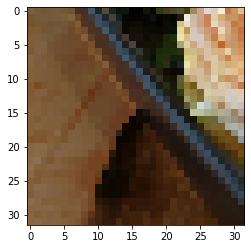

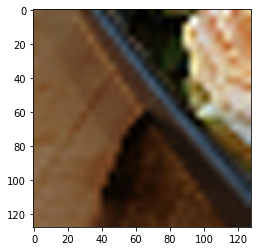

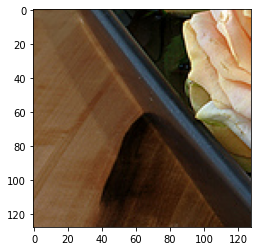

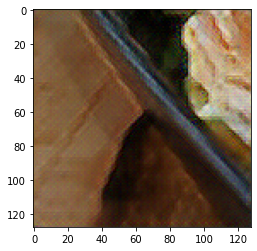

In [ ]:
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in train_dataset_mapped.take(1):
  plt.figure()
  plt.imshow(x[0].numpy())
  plt.show()
  plt.imshow(bicubic_interpolate(x[0].numpy(),(128,128)))
  plt.show()
  plt.imshow(x[1].numpy())
  plt.show()

  pred=SRResnet(x[0].numpy().reshape(1,32,32,3))
  plt.imshow(pred[0])
  plt.show()

In [ ]:
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in train_data.take(3):
  fig=plt.figure(figsize=(20,5))
  im=x['image'].numpy()
  plt.subplot(1,4,1)
  plt.imshow(im)
  plt.axis('off')

  plt.subplot(1,4,4)
  lr=bicubic_interpolate(im,(im.shape[1],im.shape[0]))
  plt.imshow(lr)  
  plt.axis('off')

  plt.subplot(1,4,2)
  pred=SRResnet(np.array([lr]))
  plt.imshow(pred[0].numpy())
  plt.axis('off')

  plt.subplot(1,4,3)
  bic=bicubic_interpolate(lr,(im.shape[1],im.shape[0]))
  plt.imshow(bic)
  plt.axis('off')

  plt.show()

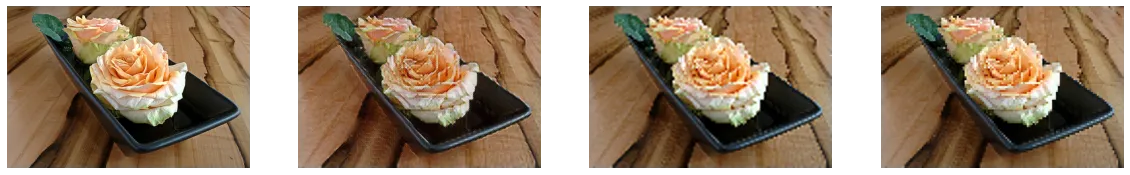

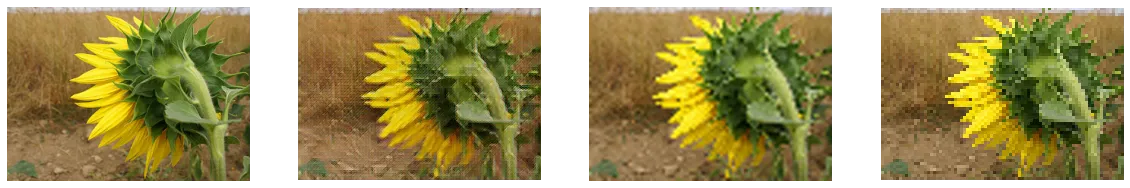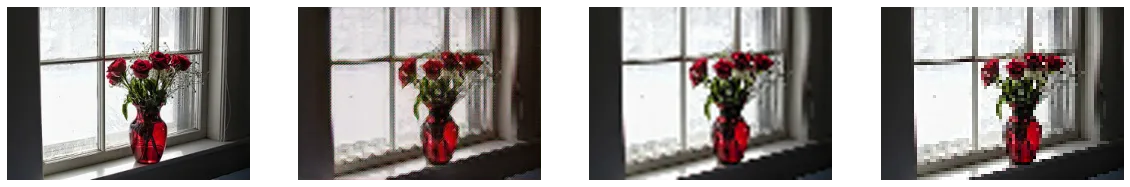